In [1]:
# Chargement des librairies
import datetime
import sys
import time
from datetime import datetime
import warnings
import numpy as np
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt

%run "functions_projet7.ipynb"

# Warnings
warnings.filterwarnings('ignore')

# Versions
print('Version des librairies utilisées :')
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
now = datetime.now().isoformat()
print('Lancé le           : ' + now)

Version des librairies utilisées :
Python                : 3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]
NumPy                 : 1.26.4
Pandas                : 2.2.1
Lancé le           : 2024-05-09T09:49:42.409117


In [2]:
import mlflow
import mlflow.sklearn

# mlflow.set_experiment('Project7')

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

import optuna

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

## <span style='background:Thistle'>Chargement des jeux de données</span>

**Chargement des dataframes issus du pré-processing**

<span style='background:Moccasin'>**Train_set/test_set**</span>

- **train_set** : jeu de données étiquetté (variable cible = TARGET) du train set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

- **test_set** : jeu de données non étiquetté (sans la variable cible TARGET) du test set, issu de la phase de pré-processing (nettoyage, gestion des valeurs manquantes, gestion des valeurs aberrantes, encodage, merge de tous les fichiers, feature engineering et feature sélection).

In [4]:
path = 'C:/Users/matis/Desktop/Data_Scientist_OpenClassRooms/Projet_7/'

fic_sav_test_set = path + 'sauvegarde/features-selection/test_set.pickle'
# Chargement de test_set
with open(fic_sav_test_set, 'rb') as df_appli_test_set:
    features_test_set = pickle.load(df_appli_test_set)
features_test_set.shape

(48744, 231)

In [5]:
fic_sav_train_set = path + 'sauvegarde/features-selection/train_set.pickle'
# Chargement de train_set
with open(fic_sav_train_set, 'rb') as df_appli_train_set:
    features_train_set = pickle.load(df_appli_train_set)
features_train_set.shape

(307507, 232)

In [6]:
fic_sav_test_set_small = path + 'sauvegarde/features-selection/test_set_small.pickle'
# Chargement de test_set_small
with open(fic_sav_test_set_small, 'rb') as df_appli_test_set_small:
    features_test_set_small = pickle.load(df_appli_test_set_small)
features_test_set_small.shape

fic_sav_train_set_small = path + 'sauvegarde/features-selection/train_set_small.pickle'
# Chargement de train_set_small
with open(fic_sav_train_set_small, 'rb') as df_appli_train_set_small:
    features_train_set_small = pickle.load(df_appli_train_set_small)
features_train_set_small.shape

(307507, 79)

In [7]:
fic_df_results = path + 'sauvegarde/modelisation/df_resultat_scores.pickle'
# Chargement de test_imp2_set
with open(fic_df_results, 'rb') as df_resultats:
    df_resultats = pickle.load(df_resultats)
df_resultats

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
0  0.042296   0.578512  0.078829  0.043860   0.042688  0.781519  0.276539   
1  0.683787   0.184241  0.290270  0.619213   0.665910  0.783201  0.280375   
2  0.040081   0.534946  0.074574  0.041559   0.040451  0.781908  0.275066   
3  0.694663   0.186402  0.293932  0.628726   0.676402  0.784745  0.281211   
4  0.044109   0.582447  0.082007  0.045735   0.044516  0.781830  0.275042   
5  0.043303   0.593923  0.080721  0.044904   0.043704  0.782081  0.278269   
6  0.661833   0.195235  0.301523  0.606118   0.646534  0.783573  0.278839   
7  0.644512   0.203653  0.309508  0.594974   0.630987  0.787229  0.285318   

   Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
0      0.686258    10.915008  11.241673  ...                    0.004946   
1      0.717727    11.996595  12.425317  ...                    0.003922   
2      0.685298    13.183495  13.664637  ...                    0.003816   
3      0.721007    12.048170  12.313410  ...                    0.003996   
4      0.686801     9.468337   9.718394  ...                    0.004382   
5      0.686658    10.401769  10.667831  ...                    0.004143   
6      0.728313     7.834742   8.164816  ...                    0.003677   
7      0.734980    54.087094  55.175894  ...                    0.004066   

   Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
0         0.059483                    0.002252        0.040836   
1         0.768356                    0.001093        0.694058   
2         0.059477                    0.002209        0.039627   
3         0.767702                    0.001650        0.693756   
4         0.058745                    0.001472        0.040030   
5         0.059326                    0.002460        0.039275   
6         0.817774                    0.001251        0.663595   
7         0.849519                    0.001246        0.641893   

   Test_recall_CV_plus_minus  Train_precision_CV  \
0                   0.004557            0.763636   
1                   0.008323            0.204906   
2                   0.004407            0.762587   
3                   0.010574            0.204621   
4                   0.002859            0.765575   
5                   0.003355            0.760979   
6                   0.010134            0.240602   
7                   0.008953            0.267810   

   Train_precision_CV_plus_minus  Test_precision_CV  \
0                       0.006599           0.565895   
1                       0.000461           0.185671   
2                       0.007938           0.562160   
3                       0.000529           0.185119   
4                       0.010206           0.575279   
5                       0.007859           0.550189   
6                       0.000429           0.196344   
7                       0.000538           0.204314   

   Test_precision_CV_plus_minus                         Model  
0                      0.043276          lgbm_hyperparam_base  
1                      0.002194      lgbm_hyperparam_base_bal  
2                      0.035772      lgbm_hyperparam_base_std  
3                      0.002367  lgbm_hyperparam_base_std_bal  
4                      0.038632   lgbm_hyperparam_base_minmax  
5                      0.033918   lgbm_hyperparam_base_robust  
6                      0.002592             lgbm_optuna_opt_1  
7                      0.002746             lgbm_optuna_opt_2  

[8 rows x 23 columns]

In [8]:
fic_df_taux = path + 'sauvegarde/modelisation/df_taux.pickle'
# Chargement de test_imp2_set
with open(fic_df_taux, 'rb') as df_taux:
    df_taux = pickle.load(df_taux)
df_taux

Modèle    FN     FP    TP     TN
0          lgbm_hyperparam_base  4755    153   210  56384
1      lgbm_hyperparam_base_bal  1570  15032  3395  41505
2      lgbm_hyperparam_base_std  4766    173   199  56364
3  lgbm_hyperparam_base_std_bal  1516  15054  3449  41483
4   lgbm_hyperparam_base_minmax  4746    157   219  56380
5   lgbm_hyperparam_base_robust  4750    147   215  56390
6             lgbm_optuna_opt_1  1679  13545  3286  42992
7             lgbm_optuna_opt_2  1765  12513  3200  44024

## <span style='background:Thistle'>Première idée sur les modèles</span>

In [8]:
def echantillonage(df_X, df_y):
    X = df_X.copy()
    y = df_y.copy()
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)
    
    return X_train, X_valid, y_train, y_valid

df_X = features_train_set.drop('TARGET', axis=1)
df_y = features_train_set['TARGET']
train_set, val_set, train_labels, val_labels = echantillonage(df_X,df_y)

print(train_set.shape, val_set.shape, train_labels.shape, val_labels.shape)

(246005, 231) (61502, 231) (246005,) (61502,)


In [9]:
train_set['TARGET']=train_labels
val_set['TARGET']=val_labels

In [10]:
train_set = train_set.reset_index()

In [11]:
sample_X = features_train_set.drop(columns = 'TARGET').sample(n= 50000)
sample_y = features_train_set['TARGET'][sample_X.index]

train_sample_set, val_sample_set, train_sample_labels, val_sample_labels = echantillonage(sample_X,sample_y)

In [12]:
train_sample_set['TARGET']=train_sample_labels
val_sample_set['TARGET']=val_sample_labels


train_sample_set = train_sample_set.reset_index()

In [13]:
print('train shape :',train_set.shape)
print('validation shape :',val_set.shape)


print('train sample shape :',train_sample_set.shape)
print('validation sample shape :',val_sample_set.shape)

train shape : (246005, 233)
validation shape : (61502, 232)
train sample shape : (40000, 233)
validation sample shape : (10000, 232)


In [33]:
# Dictionnaire de classifieurs 
classifieurs = {'Dummy Classifier': DummyClassifier(),
                'Logistic Regression': LogisticRegression(solver='lbfgs', max_iter=1000),
                'LGBM': LGBMClassifier(),
                'CatBoost': CatBoostClassifier(verbose=0),
                'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                'Random Forest': RandomForestClassifier(),
                'Gradient Boosting': GradientBoostingClassifier(),
                'AdaBoost': AdaBoostClassifier(),
                'Extra Trees': ExtraTreesClassifier(),
                'Bagging Classifier': BaggingClassifier(),
               }

Training and evaluating Dummy Classifier
Finished training Dummy Classifier. Duration: 14.44 seconds
Training and evaluating Logistic Regression
Finished training Logistic Regression. Duration: 102.79 seconds
Training and evaluating LGBM
[LightGBM] [Info] Number of positive: 2661, number of negative: 29339
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37861
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 232
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083156 -> initscore=-2.400216
[LightGBM] [Info] Start training from score -2.400216
[LightGBM] [Info] Number of positive: 2671, number of negative: 29329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 37852


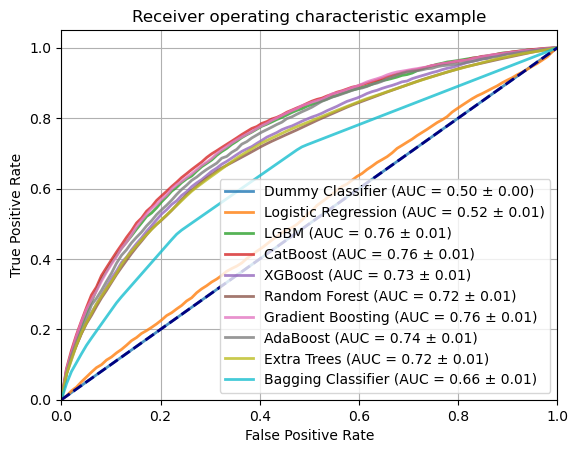

Model  Accuracy       AUC  Precision    Recall  F1 Score  \
0     Dummy Classifier  0.916300  0.500000   0.000000  0.000000  0.000000   
1  Logistic Regression  0.915700  0.524378   0.033333  0.000291  0.000577   
2                 LGBM  0.916050  0.755509   0.475732  0.037225  0.068964   
3             CatBoost  0.916400  0.762968   0.506176  0.033698  0.063120   
4              XGBoost  0.913750  0.729554   0.402847  0.061451  0.106526   
5        Random Forest  0.916300  0.718234   0.483333  0.002084  0.004149   
6    Gradient Boosting  0.916350  0.759331   0.507741  0.029826  0.056250   
7             AdaBoost  0.915425  0.744897   0.446886  0.040229  0.073561   
8          Extra Trees  0.916300  0.720354   0.000000  0.000000  0.000000   
9   Bagging Classifier  0.912525  0.655885   0.303106  0.034990  0.062704   

   Duration (s)  
0     14.437106  
1    102.792960  
2     25.767222  
3    232.737668  
4     28.925791  
5    363.728751  
6    809.791891  
7    167.412745  
8    109.194871  
9    809.409461

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

def plot_roc_curve(classifiers, X, y, n_splits=5, dataset_name='DefaultDataset'):
    results = []
    kf = KFold(n_splits=n_splits)

    for name_clf, clf in classifiers.items():
        print(f'Training and evaluating {name_clf}')
        tprs = []
        aucs = []
        accs = []
        precs = []
        recs = []
        f1s = []
        mean_fpr = np.linspace(0, 1, 100)

        start_time = time.time()  # Start time of model training and evaluation

        for i, (train, test) in enumerate(kf.split(X)):
            run_name = f"{name_clf} - Fold {i+1}"
            with mlflow.start_run(run_name=run_name):
                mlflow.set_tag('dataset', dataset_name)
                clf.fit(X.iloc[train], y.iloc[train])
                y_pred = clf.predict(X.iloc[test])
                y_proba = clf.predict_proba(X.iloc[test])[:, 1]
    
                fpr, tpr, thresholds = roc_curve(y.iloc[test], y_proba)
                interp_tpr = np.interp(mean_fpr, fpr, tpr)
                interp_tpr[0] = 0.0
                tprs.append(interp_tpr)
                roc_auc = roc_auc_score(y.iloc[test], y_proba)
                aucs.append(roc_auc)
    
                # Calculate other metrics
                acc = accuracy_score(y.iloc[test], y_pred)
                prec = precision_score(y.iloc[test], y_pred)
                rec = recall_score(y.iloc[test], y_pred)
                f1 = f1_score(y.iloc[test], y_pred)
                accs.append(acc)
                precs.append(prec)
                recs.append(rec)
                f1s.append(f1)
                mlflow.log_metric("accuracy", acc)
                mlflow.log_metric("precision", prec)
                mlflow.log_metric("recall", rec)
                mlflow.log_metric("f1", f1)
                mlflow.sklearn.log_model(clf, "model")
                
                # Logging dataset information as an artifact
                dataset_info = f"Dataset used: {dataset_name}"
                with open("dataset_info.txt", "w") as f:
                    f.write(dataset_info)
                mlflow.log_artifact("dataset_info.txt")

        total_time = time.time() - start_time  # Total time for training and evaluation
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr,
                 label=f'{name_clf} (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
                 lw=2, alpha=.8)

        results.append({
            'Model': name_clf,
            'Accuracy': np.mean(accs),
            'AUC': np.mean(aucs),
            'Precision': np.mean(precs),
            'Recall': np.mean(recs),
            'F1 Score': np.mean(f1s),
            'Duration (s)': total_time  # Store duration
        })
        
        print(f"Finished training {name_clf}. Duration: {total_time:.2f} seconds")

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.grid(True)  # Enable grid
    plt.show()

    results_df = pd.DataFrame(results)
    return results_df

# Usage of the function
results_df = plot_roc_curve(classifieurs, train_sample_set.drop('TARGET', axis=1), train_sample_labels, n_splits = 5, dataset_name='Train Sample Set')
results_df


**Test jeu de données réduit**

In [35]:
df_X_small = features_train_set_small.drop('TARGET', axis=1)
df_y_small = features_train_set_small['TARGET']
train_set_small, val_set_small, train_labels_small, val_labels_small = echantillonage(df_X_small, df_y_small)

print(train_set_small.shape, val_set_small.shape, train_labels_small.shape, val_labels_small.shape)

(246005, 78) (61502, 78) (246005,) (61502,)


In [36]:
train_set_small['TARGET' ]= train_labels_small
val_set_small['TARGET'] = val_labels_small

In [37]:
train_set_small = train_set_small.reset_index()

In [38]:
sample_X_small = features_train_set_small.drop(columns = 'TARGET').sample(n= 50000)
sample_y_small = features_train_set_small['TARGET'][sample_X_small.index]

train_sample_set_small, val_sample_set_small, train_sample_labels_small, val_sample_labels_small = echantillonage(sample_X_small, sample_y_small)

In [39]:
train_sample_set_small['TARGET']=train_sample_labels_small
val_sample_set_small['TARGET']=val_sample_labels_small

train_sample_set_small = train_sample_set_small.reset_index()

In [40]:
print('train small shape :', train_set_small.shape)
print('validation small shape :', val_set_small.shape)

print('train sample small shape :', train_sample_set_small.shape)
print('validation sample small shape :', val_sample_set_small.shape)

train small shape : (246005, 80)
validation small shape : (61502, 79)
train sample small shape : (40000, 80)
validation sample small shape : (10000, 79)


Training and evaluating Dummy Classifier
Finished training Dummy Classifier. Duration: 13.02 seconds
Training and evaluating Logistic Regression
Finished training Logistic Regression. Duration: 39.46 seconds
Training and evaluating LGBM
[LightGBM] [Info] Number of positive: 2673, number of negative: 29327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16138
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083531 -> initscore=-2.395307
[LightGBM] [Info] Start training from score -2.395307
[LightGBM] [Info] Number of positive: 2656, number of negative: 29344
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16133
[L

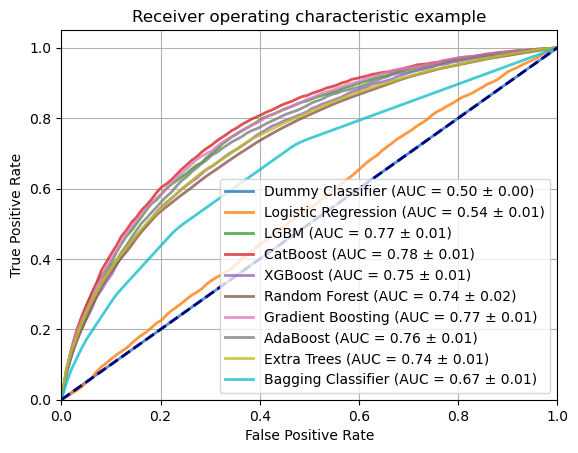

Model  Accuracy       AUC  Precision    Recall  F1 Score  \
0     Dummy Classifier  0.917575  0.500000   0.000000  0.000000  0.000000   
1  Logistic Regression  0.917450  0.535273   0.000000  0.000000  0.000000   
2                 LGBM  0.916750  0.767553   0.451045  0.046339  0.083977   
3             CatBoost  0.917375  0.779010   0.486970  0.042549  0.078187   
4              XGBoost  0.914325  0.745078   0.393981  0.073972  0.124514   
5        Random Forest  0.917450  0.735007   0.409158  0.005226  0.010312   
6    Gradient Boosting  0.917175  0.770582   0.471147  0.034993  0.065134   
7             AdaBoost  0.915600  0.757240   0.403638  0.050898  0.090364   
8          Extra Trees  0.917500  0.743190   0.556667  0.003342  0.006632   
9   Bagging Classifier  0.914275  0.668059   0.320957  0.035478  0.063762   

   Duration (s)  
0     13.018403  
1     39.463598  
2     16.932044  
3    125.546656  
4     17.485277  
5    249.305013  
6    417.352664  
7     85.448899  
8     59.148612  
9    313.264888

In [41]:
# Usage of the function
results_df_small = plot_roc_curve(classifieurs, train_sample_set_small.drop('TARGET', axis=1), train_sample_labels_small, n_splits = 5)
results_df_small

In [42]:
results_df_small['Data'] = 'train_set_small'
results_df_small

Model  Accuracy       AUC  Precision    Recall  F1 Score  \
0     Dummy Classifier  0.917575  0.500000   0.000000  0.000000  0.000000   
1  Logistic Regression  0.917450  0.535273   0.000000  0.000000  0.000000   
2                 LGBM  0.916750  0.767553   0.451045  0.046339  0.083977   
3             CatBoost  0.917375  0.779010   0.486970  0.042549  0.078187   
4              XGBoost  0.914325  0.745078   0.393981  0.073972  0.124514   
5        Random Forest  0.917450  0.735007   0.409158  0.005226  0.010312   
6    Gradient Boosting  0.917175  0.770582   0.471147  0.034993  0.065134   
7             AdaBoost  0.915600  0.757240   0.403638  0.050898  0.090364   
8          Extra Trees  0.917500  0.743190   0.556667  0.003342  0.006632   
9   Bagging Classifier  0.914275  0.668059   0.320957  0.035478  0.063762   

   Duration (s)             Data  
0     13.018403  train_set_small  
1     39.463598  train_set_small  
2     16.932044  train_set_small  
3    125.546656  train_set_small  
4     17.485277  train_set_small  
5    249.305013  train_set_small  
6    417.352664  train_set_small  
7     85.448899  train_set_small  
8     59.148612  train_set_small  
9    313.264888  train_set_small

In [43]:
results_df['Data'] = 'train_set'
results_df

Model  Accuracy       AUC  Precision    Recall  F1 Score  \
0     Dummy Classifier  0.916300  0.500000   0.000000  0.000000  0.000000   
1  Logistic Regression  0.915700  0.524378   0.033333  0.000291  0.000577   
2                 LGBM  0.916050  0.755509   0.475732  0.037225  0.068964   
3             CatBoost  0.916400  0.762968   0.506176  0.033698  0.063120   
4              XGBoost  0.913750  0.729554   0.402847  0.061451  0.106526   
5        Random Forest  0.916300  0.718234   0.483333  0.002084  0.004149   
6    Gradient Boosting  0.916350  0.759331   0.507741  0.029826  0.056250   
7             AdaBoost  0.915425  0.744897   0.446886  0.040229  0.073561   
8          Extra Trees  0.916300  0.720354   0.000000  0.000000  0.000000   
9   Bagging Classifier  0.912525  0.655885   0.303106  0.034990  0.062704   

   Duration (s)       Data  
0     14.437106  train_set  
1    102.792960  train_set  
2     25.767222  train_set  
3    232.737668  train_set  
4     28.925791  train_set  
5    363.728751  train_set  
6    809.791891  train_set  
7    167.412745  train_set  
8    109.194871  train_set  
9    809.409461  train_set

In [44]:
df_compare = pd.concat([results_df, results_df_small])
df_compare

Model  Accuracy       AUC  Precision    Recall  F1 Score  \
0     Dummy Classifier  0.916300  0.500000   0.000000  0.000000  0.000000   
1  Logistic Regression  0.915700  0.524378   0.033333  0.000291  0.000577   
2                 LGBM  0.916050  0.755509   0.475732  0.037225  0.068964   
3             CatBoost  0.916400  0.762968   0.506176  0.033698  0.063120   
4              XGBoost  0.913750  0.729554   0.402847  0.061451  0.106526   
5        Random Forest  0.916300  0.718234   0.483333  0.002084  0.004149   
6    Gradient Boosting  0.916350  0.759331   0.507741  0.029826  0.056250   
7             AdaBoost  0.915425  0.744897   0.446886  0.040229  0.073561   
8          Extra Trees  0.916300  0.720354   0.000000  0.000000  0.000000   
9   Bagging Classifier  0.912525  0.655885   0.303106  0.034990  0.062704   
0     Dummy Classifier  0.917575  0.500000   0.000000  0.000000  0.000000   
1  Logistic Regression  0.917450  0.535273   0.000000  0.000000  0.000000   
2                 LGBM  0.916750  0.767553   0.451045  0.046339  0.083977   
3             CatBoost  0.917375  0.779010   0.486970  0.042549  0.078187   
4              XGBoost  0.914325  0.745078   0.393981  0.073972  0.124514   
5        Random Forest  0.917450  0.735007   0.409158  0.005226  0.010312   
6    Gradient Boosting  0.917175  0.770582   0.471147  0.034993  0.065134   
7             AdaBoost  0.915600  0.757240   0.403638  0.050898  0.090364   
8          Extra Trees  0.917500  0.743190   0.556667  0.003342  0.006632   
9   Bagging Classifier  0.914275  0.668059   0.320957  0.035478  0.063762   

   Duration (s)             Data  
0     14.437106        train_set  
1    102.792960        train_set  
2     25.767222        train_set  
3    232.737668        train_set  
4     28.925791        train_set  
5    363.728751        train_set  
6    809.791891        train_set  
7    167.412745        train_set  
8    109.194871        train_set  
9    809.409461        train_set  
0     13.018403  train_set_small  
1     39.463598  train_set_small  
2     16.932044  train_set_small  
3    125.546656  train_set_small  
4     17.485277  train_set_small  
5    249.305013  train_set_small  
6    417.352664  train_set_small  
7     85.448899  train_set_small  
8     59.148612  train_set_small  
9    313.264888  train_set_small

**Bilan** : 
***
- **Modèles** : 
    - Catboost ,
    - LGBM,
    - XGBoost.
    - Observons les autres métriques pour départager nos 3 modèles.

- Pour notre problématique :
    - les **défaillants** forment la classe **positive**,
    - les **non-défaillants** forment la classe **négative**.

- Pour minimiser les pertes d'argent, nous devons :
    - nous efforcer de ne pas prédire un client non-défaillant s'il est défaillant ==> **minimiser le nombre de faux négatifs** (prédit non-défaillant mais client défaillant). Si un défaillant est prédit non défaillant, le groupe Home Crédit aura perdu toute la somme prêtée à l'emprunteur. Cela constitue les plus grosses pertes pour l'entreprise.
    - nous efforcer de ne pas prédire de défaillant si le client n'est pas défaillant donc **minimiser les faux positifs** (classe 1 défaillant alors que non-défaillant dans la réalité). Si un non-défaillant est prédit défaillant, le groupe Home Crédit aura perdu les intérêts de la somme prêtée à l'emprunteur.
    
- La métrique pour déterminer le **taux de vrais positif** est le Rappel/**Recall**, elle mesure parmi toutes les observations positives combien ont été classées comme positives. Pour ne pas avoir de pertes, il faut détecter tous les défaillants (classe positive) donc **maximiser la métrique recall**.
- La métrique **Precision**  mesure le nombre d'observations prédites comme positives (client défaillant) qui le sont en réalité. Si le client est prédit défaillant alors qu'il ne le sera pas le prêt ne sera pas accordé et les intérêts ne seront pas empochés. Il faut donc **maximiser la 'Precision'**.

***Note :***
***
- Si on augmente le recall, la précision diminue, il s'agit de faire un compromis entre ces 2 métriques qui dépendent l'une de l'autre, en prenant en compte le métier/problème de l'entreprise et les coûts associés pour répondre à ces questions.
- Dans notre cas, il faut trouver le plus grand nombre d'observations réellement positives (client prédit défaillant et bien défaillant) et la perte est moins grande si on prédit un client défaillant mais qu'il n'est pas défaillant (faux positifs), donc **on donnera priorité à maximiser le recall au dépend de la précision** (on parle bien de Precision pas d'accuracy).
- Le réglage du paramètre beta pour le Fbeta score permet de donner plus de poids au recall (beta>1) qu'à la précision (0<beta<1). Le score F1 est la moyenne harmonique entre le recall et la précision.

In [45]:
df_compare = df_compare.sort_values(by=['Data', 'AUC', 'Duration (s)'], ascending=[True, False, True])
df_compare

Model  Accuracy       AUC  Precision    Recall  F1 Score  \
3             CatBoost  0.916400  0.762968   0.506176  0.033698  0.063120   
6    Gradient Boosting  0.916350  0.759331   0.507741  0.029826  0.056250   
2                 LGBM  0.916050  0.755509   0.475732  0.037225  0.068964   
7             AdaBoost  0.915425  0.744897   0.446886  0.040229  0.073561   
4              XGBoost  0.913750  0.729554   0.402847  0.061451  0.106526   
8          Extra Trees  0.916300  0.720354   0.000000  0.000000  0.000000   
5        Random Forest  0.916300  0.718234   0.483333  0.002084  0.004149   
9   Bagging Classifier  0.912525  0.655885   0.303106  0.034990  0.062704   
1  Logistic Regression  0.915700  0.524378   0.033333  0.000291  0.000577   
0     Dummy Classifier  0.916300  0.500000   0.000000  0.000000  0.000000   
3             CatBoost  0.917375  0.779010   0.486970  0.042549  0.078187   
6    Gradient Boosting  0.917175  0.770582   0.471147  0.034993  0.065134   
2                 LGBM  0.916750  0.767553   0.451045  0.046339  0.083977   
7             AdaBoost  0.915600  0.757240   0.403638  0.050898  0.090364   
4              XGBoost  0.914325  0.745078   0.393981  0.073972  0.124514   
8          Extra Trees  0.917500  0.743190   0.556667  0.003342  0.006632   
5        Random Forest  0.917450  0.735007   0.409158  0.005226  0.010312   
9   Bagging Classifier  0.914275  0.668059   0.320957  0.035478  0.063762   
1  Logistic Regression  0.917450  0.535273   0.000000  0.000000  0.000000   
0     Dummy Classifier  0.917575  0.500000   0.000000  0.000000  0.000000   

   Duration (s)             Data  
3    232.737668        train_set  
6    809.791891        train_set  
2     25.767222        train_set  
7    167.412745        train_set  
4     28.925791        train_set  
8    109.194871        train_set  
5    363.728751        train_set  
9    809.409461        train_set  
1    102.792960        train_set  
0     14.437106        train_set  
3    125.546656  train_set_small  
6    417.352664  train_set_small  
2     16.932044  train_set_small  
7     85.448899  train_set_small  
4     17.485277  train_set_small  
8     59.148612  train_set_small  
5    249.305013  train_set_small  
9    313.264888  train_set_small  
1     39.463598  train_set_small  
0     13.018403  train_set_small

In [47]:
df_compare.sort_values(by=['Data', 'AUC'], ascending=[True, False])

Model  Accuracy       AUC  Precision    Recall  F1 Score  \
3             CatBoost  0.916400  0.762968   0.506176  0.033698  0.063120   
6    Gradient Boosting  0.916350  0.759331   0.507741  0.029826  0.056250   
2                 LGBM  0.916050  0.755509   0.475732  0.037225  0.068964   
7             AdaBoost  0.915425  0.744897   0.446886  0.040229  0.073561   
4              XGBoost  0.913750  0.729554   0.402847  0.061451  0.106526   
8          Extra Trees  0.916300  0.720354   0.000000  0.000000  0.000000   
5        Random Forest  0.916300  0.718234   0.483333  0.002084  0.004149   
9   Bagging Classifier  0.912525  0.655885   0.303106  0.034990  0.062704   
1  Logistic Regression  0.915700  0.524378   0.033333  0.000291  0.000577   
0     Dummy Classifier  0.916300  0.500000   0.000000  0.000000  0.000000   
3             CatBoost  0.917375  0.779010   0.486970  0.042549  0.078187   
6    Gradient Boosting  0.917175  0.770582   0.471147  0.034993  0.065134   
2                 LGBM  0.916750  0.767553   0.451045  0.046339  0.083977   
7             AdaBoost  0.915600  0.757240   0.403638  0.050898  0.090364   
4              XGBoost  0.914325  0.745078   0.393981  0.073972  0.124514   
8          Extra Trees  0.917500  0.743190   0.556667  0.003342  0.006632   
5        Random Forest  0.917450  0.735007   0.409158  0.005226  0.010312   
9   Bagging Classifier  0.914275  0.668059   0.320957  0.035478  0.063762   
1  Logistic Regression  0.917450  0.535273   0.000000  0.000000  0.000000   
0     Dummy Classifier  0.917575  0.500000   0.000000  0.000000  0.000000   

   Duration (s)             Data  
3    232.737668        train_set  
6    809.791891        train_set  
2     25.767222        train_set  
7    167.412745        train_set  
4     28.925791        train_set  
8    109.194871        train_set  
5    363.728751        train_set  
9    809.409461        train_set  
1    102.792960        train_set  
0     14.437106        train_set  
3    125.546656  train_set_small  
6    417.352664  train_set_small  
2     16.932044  train_set_small  
7     85.448899  train_set_small  
4     17.485277  train_set_small  
8     59.148612  train_set_small  
5    249.305013  train_set_small  
9    313.264888  train_set_small  
1     39.463598  train_set_small  
0     13.018403  train_set_small

- Léger avantage au modèle Catboost. Gradient Boosting, LGBM, AdaBoost et xgboost ont des résultats proches.

In [48]:
df_compare.sort_values(by=['Data', 'Recall'], ascending=[True, False])

Model  Accuracy       AUC  Precision    Recall  F1 Score  \
4              XGBoost  0.913750  0.729554   0.402847  0.061451  0.106526   
7             AdaBoost  0.915425  0.744897   0.446886  0.040229  0.073561   
2                 LGBM  0.916050  0.755509   0.475732  0.037225  0.068964   
9   Bagging Classifier  0.912525  0.655885   0.303106  0.034990  0.062704   
3             CatBoost  0.916400  0.762968   0.506176  0.033698  0.063120   
6    Gradient Boosting  0.916350  0.759331   0.507741  0.029826  0.056250   
5        Random Forest  0.916300  0.718234   0.483333  0.002084  0.004149   
1  Logistic Regression  0.915700  0.524378   0.033333  0.000291  0.000577   
8          Extra Trees  0.916300  0.720354   0.000000  0.000000  0.000000   
0     Dummy Classifier  0.916300  0.500000   0.000000  0.000000  0.000000   
4              XGBoost  0.914325  0.745078   0.393981  0.073972  0.124514   
7             AdaBoost  0.915600  0.757240   0.403638  0.050898  0.090364   
2                 LGBM  0.916750  0.767553   0.451045  0.046339  0.083977   
3             CatBoost  0.917375  0.779010   0.486970  0.042549  0.078187   
9   Bagging Classifier  0.914275  0.668059   0.320957  0.035478  0.063762   
6    Gradient Boosting  0.917175  0.770582   0.471147  0.034993  0.065134   
5        Random Forest  0.917450  0.735007   0.409158  0.005226  0.010312   
8          Extra Trees  0.917500  0.743190   0.556667  0.003342  0.006632   
1  Logistic Regression  0.917450  0.535273   0.000000  0.000000  0.000000   
0     Dummy Classifier  0.917575  0.500000   0.000000  0.000000  0.000000   

   Duration (s)             Data  
4     28.925791        train_set  
7    167.412745        train_set  
2     25.767222        train_set  
9    809.409461        train_set  
3    232.737668        train_set  
6    809.791891        train_set  
5    363.728751        train_set  
1    102.792960        train_set  
8    109.194871        train_set  
0     14.437106        train_set  
4     17.485277  train_set_small  
7     85.448899  train_set_small  
2     16.932044  train_set_small  
3    125.546656  train_set_small  
9    313.264888  train_set_small  
6    417.352664  train_set_small  
5    249.305013  train_set_small  
8     59.148612  train_set_small  
1     39.463598  train_set_small  
0     13.018403  train_set_small

- Le meilleur résultat est obtenu par Xgboost, suivi par Adaboost et LGBM avec un résultat 2 fois meilleur que pour LGBM mais le recall peut-être affiné en optimisant le modèle et le seuil de probabilité.

In [49]:
df_compare.sort_values(by=['Data', 'Precision'], ascending=[True, False])

Model  Accuracy       AUC  Precision    Recall  F1 Score  \
6    Gradient Boosting  0.916350  0.759331   0.507741  0.029826  0.056250   
3             CatBoost  0.916400  0.762968   0.506176  0.033698  0.063120   
5        Random Forest  0.916300  0.718234   0.483333  0.002084  0.004149   
2                 LGBM  0.916050  0.755509   0.475732  0.037225  0.068964   
7             AdaBoost  0.915425  0.744897   0.446886  0.040229  0.073561   
4              XGBoost  0.913750  0.729554   0.402847  0.061451  0.106526   
9   Bagging Classifier  0.912525  0.655885   0.303106  0.034990  0.062704   
1  Logistic Regression  0.915700  0.524378   0.033333  0.000291  0.000577   
8          Extra Trees  0.916300  0.720354   0.000000  0.000000  0.000000   
0     Dummy Classifier  0.916300  0.500000   0.000000  0.000000  0.000000   
8          Extra Trees  0.917500  0.743190   0.556667  0.003342  0.006632   
3             CatBoost  0.917375  0.779010   0.486970  0.042549  0.078187   
6    Gradient Boosting  0.917175  0.770582   0.471147  0.034993  0.065134   
2                 LGBM  0.916750  0.767553   0.451045  0.046339  0.083977   
5        Random Forest  0.917450  0.735007   0.409158  0.005226  0.010312   
7             AdaBoost  0.915600  0.757240   0.403638  0.050898  0.090364   
4              XGBoost  0.914325  0.745078   0.393981  0.073972  0.124514   
9   Bagging Classifier  0.914275  0.668059   0.320957  0.035478  0.063762   
1  Logistic Regression  0.917450  0.535273   0.000000  0.000000  0.000000   
0     Dummy Classifier  0.917575  0.500000   0.000000  0.000000  0.000000   

   Duration (s)             Data  
6    809.791891        train_set  
3    232.737668        train_set  
5    363.728751        train_set  
2     25.767222        train_set  
7    167.412745        train_set  
4     28.925791        train_set  
9    809.409461        train_set  
1    102.792960        train_set  
8    109.194871        train_set  
0     14.437106        train_set  
8     59.148612  train_set_small  
3    125.546656  train_set_small  
6    417.352664  train_set_small  
2     16.932044  train_set_small  
5    249.305013  train_set_small  
7     85.448899  train_set_small  
4     17.485277  train_set_small  
9    313.264888  train_set_small  
1     39.463598  train_set_small  
0     13.018403  train_set_small

- Le meilleur résultat est obtenu par GradientBoosting, suivi par CatBoost puis Random Forest et LGBM

In [51]:
df_compare.sort_values(by=['Data', 'Duration (s)'], ascending=[True, True])

Model  Accuracy       AUC  Precision    Recall  F1 Score  \
0     Dummy Classifier  0.916300  0.500000   0.000000  0.000000  0.000000   
2                 LGBM  0.916050  0.755509   0.475732  0.037225  0.068964   
4              XGBoost  0.913750  0.729554   0.402847  0.061451  0.106526   
1  Logistic Regression  0.915700  0.524378   0.033333  0.000291  0.000577   
8          Extra Trees  0.916300  0.720354   0.000000  0.000000  0.000000   
7             AdaBoost  0.915425  0.744897   0.446886  0.040229  0.073561   
3             CatBoost  0.916400  0.762968   0.506176  0.033698  0.063120   
5        Random Forest  0.916300  0.718234   0.483333  0.002084  0.004149   
9   Bagging Classifier  0.912525  0.655885   0.303106  0.034990  0.062704   
6    Gradient Boosting  0.916350  0.759331   0.507741  0.029826  0.056250   
0     Dummy Classifier  0.917575  0.500000   0.000000  0.000000  0.000000   
2                 LGBM  0.916750  0.767553   0.451045  0.046339  0.083977   
4              XGBoost  0.914325  0.745078   0.393981  0.073972  0.124514   
1  Logistic Regression  0.917450  0.535273   0.000000  0.000000  0.000000   
8          Extra Trees  0.917500  0.743190   0.556667  0.003342  0.006632   
7             AdaBoost  0.915600  0.757240   0.403638  0.050898  0.090364   
3             CatBoost  0.917375  0.779010   0.486970  0.042549  0.078187   
5        Random Forest  0.917450  0.735007   0.409158  0.005226  0.010312   
9   Bagging Classifier  0.914275  0.668059   0.320957  0.035478  0.063762   
6    Gradient Boosting  0.917175  0.770582   0.471147  0.034993  0.065134   

   Duration (s)             Data  
0     14.437106        train_set  
2     25.767222        train_set  
4     28.925791        train_set  
1    102.792960        train_set  
8    109.194871        train_set  
7    167.412745        train_set  
3    232.737668        train_set  
5    363.728751        train_set  
9    809.409461        train_set  
6    809.791891        train_set  
0     13.018403  train_set_small  
2     16.932044  train_set_small  
4     17.485277  train_set_small  
1     39.463598  train_set_small  
8     59.148612  train_set_small  
7     85.448899  train_set_small  
3    125.546656  train_set_small  
5    249.305013  train_set_small  
9    313.264888  train_set_small  
6    417.352664  train_set_small

- Lightgbm est le plus rapide, CatBoost est très lent, GradientBoosting encore plus lent
- Sans surprise les jeux de données avec moins de variables (small) ont des temps de réponse plus rapides.

**Bilan** :
***
- Les résultats sont meilleurs pour CatBoost et GradientBoosting, mais LGBM et XgBoost sont également performants.
- Cependant CatBoost est très lent, puisque le but est un dashboard interactif, si de nouvelles données sont fournies ou si les données des clients évoluent, le temps d'exécution sera un facteur essentiel pour notre problématique.
- Les métriques peuvent être optimisées en jouant sur l'équilibrage du jeu de données, sur l'optimisation du modèle et sur le réglage du seuil de probabilité.
- Après analyse des résultats et des contraintes de notre problématique, **le modèle retenu sera Lightgbm**.

## <span style='background:Thistle'>Préparation du jeu de données</span>

In [16]:
# Nombre aléatoire pour la reproductibilité des résultats
seed = 21
print(f'Nombre aléatoire : {seed}')

Nombre aléatoire : 21


### <span style='background:PowderBlue'>Split du jeu d'entraînement en entraînement/validation</span>

In [22]:
# Vecteur y cible
y = features_train_set['TARGET']
print(f'y : {y.shape}')

y : (307507,)


In [23]:
# Matrice X
# Passage de l'identifiant du client en index pour la modélisation
features_train_set.set_index('SK_ID_CURR', inplace=True)
# Suppression de la variable cible pour la modélisation
X = features_train_set.drop(['TARGET'], axis=1)
print(f'X : {X.shape}')

X : (307507, 230)


In [24]:
# Découpage du jeu d'entraînement en :
# X_train : pour entraîner le modèle et trouver les meilleurs
#           hyperparamètres
# X_valid : pour évaluer les performances du modèle
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.2,
                                                      shuffle=True,
                                                      stratify=y,
                                                      random_state=seed)
print(f'X_train : {X_train.shape} - y_train : {y_train.shape}')
print(f'X_valid : {X_valid.shape} - y_valid : {y_valid.shape}')

X_train : (246005, 230) - y_train : (246005,)
X_valid : (61502, 230) - y_valid : (61502,)


## <span style='background:Thistle'>Choix des métriques</span>

### <span style='background:PowderBlue'>Métriques de classification binaire</span>

**Problématique**
***
- Pour notre problématique :
    - les **défaillants** forment la classe **positive**,
    - les **non-défaillants** forment la classe **négative**.
- Pour minimiser les pertes d'argent, nous devons :
    - nous efforcer de ne pas prédire un client non-défaillant s'il est défaillant ==> **minimiser le nombre de faux négatifs (erreur de type II)** (prédit non-défaillant mais client défaillant). Si un défaillant est prédit non défaillant, le groupe Home Crédit aura perdu toute la somme prêtée à l'emprunteur. Cela constitue les plus grosses pertes pour l'entreprise.
    - nous efforcer de ne pas prédire de défaillant si le client n'est pas défaillant donc **minimiser les faux positifs (erreur de type I)** (classe 1 défaillant alors que non-défaillant dans la réalité). Si un non-défaillant est prédit défaillant, le groupe Home Crédit aura perdu les intérêts de la somme prêtée à l'emprunteur.
    
**Métriques**
***
-  **Recall** : la métrique pour déterminer le **taux de vrais positif** est le Rappel(Sensibilité)/**Recall**, elle mesure parmi toutes les observations positives combien ont été classées comme positives. Pour ne pas avoir de pertes, il faut détecter tous les défaillants (classe positive) donc **maximiser la métrique recall**.

- **Precision** : elle mesure le nombre d'observations prédites comme positives (client défaillant) qui le sont en réalité. Si le client est prédit défaillant alors qu'il ne le sera pas le prêt ne sera pas accordé et les intérêts ne seront pas empochés. Il faut donc **maximiser la 'Precision'**.

- **F-mesure ou F1** : compromis entre le rappel et précision.
    -  Si on augmente le recall, la précision diminue, il s'agit de faire un compromis entre ces 2 métriques qui dépendent l'une de l'autre, en prenant en compte le métier/problème de l'entreprise et les coûts associés pour répondre à ces questions.
    - Dans notre cas, il faut trouver le plus grand nombre d'observations réellement positives (client prédit défaillant et bien défaillant) et la perte est moins grande si on prédit un client défaillant mais qu'il n'est pas défaillant (faux positifs), donc **on donnera priorité à maximiser le recall au dépend de la précision** (on parle bien de Precision pas d'accuracy).
    - Le réglage du paramètre beta pour le Fbeta score permet de donner plus de poids au recall (beta>1) qu'à la précision (0<beta<1). Le score F1 est la moyenne harmonique entre le recall et la précision.

- **Score ROC AUC** : le score ROC AUC est équivalent au calcul de la corrélation de rang entre les prédictions et la cible. Du point de vue de l'interprétation, il est plus utile car il nous indique que cette métrique montre à quel point votre modèle est bon pour classer les prédictions. Elle vous indique la probabilité qu'une instance positive choisie au hasard soit classée plus haut qu'une instance négative choisie au hasard.

- **Score PR AUC** : calcule de l'aire sous la courbe précision-rappel pour obtenir un nombre qui vous donne des informations sur la performance du modèle. A utiliser : 
    - lorsque vous voulez communiquer la décision de précision/rappel à d'autres parties prenantes et que vous voulez choisir le seuil qui correspond au problème de l'entreprise.
    - lorsque vos données sont fortement déséquilibrées. Puisque l'AUC de PR se concentre principalement sur la classe positive (PPV et TPR), elle se soucie moins de la classe négative fréquente.
    - quand vous vous souciez plus de la classe positive que de la classe négative. Si vous vous souciez davantage de la classe positive et donc du PPV et du TPR, vous devriez opter pour la courbe Precision-Recall et la PR AUC (précision moyenne).


**Notes :**
***
- La librairie sklearn permet de calculer tous ses scores.
- Une fonction permettra d calculer et de sauvegarder ses différents scores lors de la modélisation

### <span style='background:PowderBlue'>Métriques métiers</span>

**Score pénalisant les faux négatifs**
- Les métriques ci-dessus ne pénalisent pas les faux négatifs sauf le Fbeta qui en utilisant une valeur supérieure à 1 pénalise plus les faux négatifs.
- Nous allons donc créer une métrique métier tentant d'optimiser notre modèle de classification grâce à la personnalisation de la fonction de perte pour définir à la main le coût des faux positifs/négatifs et des vrais positifs/négatifs.

**Seuil de probabilité**
- La valeur du seuil de probabilité à 0.5 par défaut pourra également être réglée pour tenter d'optimiser les performances du modèles pour notre métrique métier. Le seuil optimal de bascule de la classe 0 à la classe 1 devra être déterminée pour chacun des modèles entraînés avec la métrique métier comme score.

## <span style='background:Thistle'>Modélisation</span>

In [109]:
df_resultats = pd.DataFrame({})
df_taux = pd.DataFrame({})

In [9]:
def afficher_matrice_confusion(y_true, y_pred, title):

    plt.figure(figsize=(6, 4))

    cm = confusion_matrix(y_true, y_pred)
    
    labels = ['Non défaillants', 'Défaillants']
    
    sns.heatmap(cm,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d',
                cmap=plt.cm.Blues)
    plt.title(f'Matrice de confusion de : {title}')
    plt.ylabel('Classe réelle')
    plt.xlabel('Classe prédite')
    plt.show()    

from sklearn.metrics import confusion_matrix, recall_score, fbeta_score, precision_score, roc_auc_score, average_precision_score
from sklearn.model_selection import cross_validate, RandomizedSearchCV, \
    GridSearchCV, learning_curve  # , cross_val_score

def process_classification(model, X_train, X_valid, y_train, y_valid,
                           df_resultats, titre, affiche_res=True,
                           affiche_matrice_confusion=True):
    """
    Lance un modele de classification binaire, effectue cross-validation
    et sauvegarde des scores.
    Parameters
    ----------
    model : modèle de classification initialisé, obligatoire.
    X_train : train set matrice X, obligatoire.
    X_valid : test set matrice X, obligatoire.
    y_train : train set vecteur y, obligatoire.
    y_valid : test set, vecteur y, obligatoire.
    df_resultats : dataframe sauvegardant les scores, obligatoire
    titre : titre à inscrire dans le tableau de sauvegarde, obligatoire.
    affiche_res : affiche le tableau de résultat (optionnel, True par défaut).
    Returns
    -------
    df_resultats : Le dataframe de sauvegarde des performances.
    y_pred : Les prédictions pour le modèle
    """
    # Top début d'exécution
    time_start = time.time()

    # Entraînement du modèle avec le jeu d'entraînement du jeu d'entrainement
    model.fit(X_train, y_train)

    # Sauvegarde du modèle de classification entraîné
    with open(path + 'sauvegarde/modelisation/modele_' + titre + '.pickle', 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)
    
    # Top fin d'exécution
    time_end_train = time.time()
    
    # Prédictions avec le jeu de validation du jeu d'entraînement
    y_pred = model.predict(X_valid)

    # Top fin d'exécution
    time_end = time.time()

    # Probabilités
    y_proba = model.predict_proba(X_valid)[:, 1]
    
    # Calcul des métriques
    # Rappel/recall sensibilité
    recall = recall_score(y_valid, y_pred)
    # Précision
    precision = precision_score(y_valid, y_pred)
    # F-mesure ou Fbeta
    f1_score = fbeta_score(y_valid, y_pred, beta=1)
    f5_score = fbeta_score(y_valid, y_pred, beta=5)
    f10_score = fbeta_score(y_valid, y_pred, beta=10)
    # Score ROC AUC aire sous la courbe ROC
    roc_auc = roc_auc_score(y_valid, y_proba)
    # Score PR AUC aire sous la courbe précion/rappel
    pr_auc = average_precision_score(y_valid, y_proba)
    # Métrique métier
    banque_score = custom_score(y_valid, y_pred)

    # durée d'exécution d'entraînement
    time_exec_train = time_end_train - time_start
    # durée d'exécution entraînement + validation
    time_execution = time_end - time_start

    # cross validation
    scoring = ['roc_auc', 'recall', 'precision']
    scores = cross_validate(model, X_train, y_train, cv=10,
                            scoring=scoring, return_train_score=True)

    # Sauvegarde des performances
    nouveau_df = pd.DataFrame({
        'Modèle': [titre],
        'Recall': [recall],
        'Précision': [precision],
        'F1': [f1_score],
        'F5': [f5_score],
        'F10': [f10_score],
        'ROC_AUC': [roc_auc],
        'PR_AUC': [pr_auc],
        'Metier_score': [banque_score],
        'Durée_train': [time_exec_train],
        'Durée_tot': [time_execution],
        # Cross-validation
        'Train_roc_auc_CV': [scores['train_roc_auc'].mean()],
        'Train_roc_auc_CV +/-': [scores['train_roc_auc'].std()],
        'Test_roc_auc_CV': [scores['test_roc_auc'].mean()],
        'Test_roc_auc_CV +/-': [scores['test_roc_auc'].std()],
        'Train_recall_CV': [scores['train_recall'].mean()],
        'Train_recall_CV +/-': [scores['train_recall'].std()],
        'Test_recall_CV': [scores['test_recall'].mean()],
        'Test_recall_CV +/-': [scores['test_recall'].std()],
        'Train_precision_CV': [scores['train_precision'].mean()],
        'Train_precision_CV +/-': [scores['train_precision'].std()],
        'Test_precision_CV': [scores['test_precision'].mean()],
        'Test_precision_CV +/-': [scores['test_precision'].std()],
    })

    df_resultats = pd.concat([df_resultats, nouveau_df], ignore_index=True)

    # Sauvegarde du tableau de résultat
    with open(path + 'sauvegarde/modelisation/df_resultat_scores.pickle', 'wb') as df:
        pickle.dump(df_resultats, df, pickle.HIGHEST_PROTOCOL)
    
    if affiche_res:
        mask = df_resultats['Modèle'] == titre
        display(df_resultats[mask])

    if affiche_matrice_confusion:
        afficher_matrice_confusion(y_valid, y_pred, titre)

    return df_resultats

def custom_score(y_reel, y_pred, taux_tn=1, taux_fp=-1, taux_fn=-10, taux_tp=1):
    '''
    Métrique métier tentant de minimiser le risque d'accord prêt pour la
    banque en pénalisant les faux négatifs.
    Parameters
    ----------
    y_reel : classe réélle, obligatoire (0 ou 1).
    y_pred : classe prédite, obligatoire (0 ou 1).
    taux_tn : Taux de vrais négatifs, optionnel (1 par défaut),
              le prêt est remboursé : la banque gagne de l'argent.
    taux_fp : Taux de faux positifs, optionnel (-1 par défaut),
               le prêt est refusé par erreur : la banque perd les intérêts,
               manque à gagner mais ne perd pas réellement d'argent (erreur de
               type I).
    taux_fn : Taux de faux négatifs, optionnel (-10 par défaut),
              le prêt est accordé mais le client fait défaut : la banque perd
              de l'argent (erreur de type II)..
    taux_tp : Taux de vrais positifs, optionnel (1 par défaut),
              Le prêt est refusé à juste titre : la banque ne gagne ni ne perd
              d'argent.
    Returns
    -------
    score : gain normalisé (entre 0 et 1) un score élevé montre une meilleure
            performance
    '''
    # Matrice de Confusion
    (tn, fp, fn, tp) = confusion_matrix(y_reel, y_pred).ravel()
    # Gain total
    gain_tot = tn * taux_tn + fp * taux_fp + fn * taux_fn + tp * taux_tp
    # Gain maximum : toutes les prédictions sont correctes
    gain_max = (fp + tn) * taux_tn + (fn + tp) * taux_tp
    # Gain minimum : on accorde aucun prêt, la banque ne gagne rien
    gain_min = (fp + tn) * taux_fp + (fn + tp) * taux_fn
    
    custom_score = (gain_tot - gain_min) / (gain_max - gain_min)
    
    # Gain normalisé (entre 0 et 1) un score élevé montre une meilleure
    # performance
    return custom_score

In [10]:
import mlflow
import mlflow.sklearn
import time
import pandas as pd
import pickle
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_validate

def process_classification(model, X_train, X_valid, y_train, y_valid, df_resultats, titre, affiche_res=True, affiche_matrice_confusion=True):
    """
    Lance un modèle de classification binaire, effectue la validation et la sauvegarde des scores avec MLflow.
    """
    with mlflow.start_run(run_name=titre) as run:
        # Enregistrement des paramètres du modèle
        mlflow.log_params(model.get_params())

        # Démarrage de l'exécution
        time_start = time.time()

        # Entraînement du modèle
        model.fit(X_train, y_train)

        # Top fin d'exécution
        time_end_train = time.time()

        # Prédiction et calcul des probabilités
        y_pred = model.predict(X_valid)
        y_proba = model.predict_proba(X_valid)[:, 1]

        # Top fin d'exécution
        time_end = time.time()

        # Métrique métier
        banque_score = custom_score(y_valid, y_pred)

        # durée d'exécution d'entraînement
        time_exec_train = time_end_train - time_start
        # durée d'exécution entraînement + validation
        time_execution = time_end - time_start

        recall = recall_score(y_valid, y_pred)
        # Précision
        precision = precision_score(y_valid, y_pred)
        # Score ROC AUC aire sous la courbe ROC
        roc_auc = roc_auc_score(y_valid, y_proba)
    
        # cross validation
        scoring = ['roc_auc', 'recall', 'precision']
        scores = cross_validate(model, X_train, y_train, cv=10,
                                scoring=scoring, return_train_score=True)

        # Calcul des métriques
        metrics = {
            'Recall': recall_score(y_valid, y_pred),
            'Precision': precision_score(y_valid, y_pred),
            'F1 Score': f1_score(y_valid, y_pred),
            'F5 Score': fbeta_score(y_valid, y_pred, beta=5),
            'F10 Score': fbeta_score(y_valid, y_pred, beta=10),
            'ROC AUC': roc_auc_score(y_valid, y_proba),
            'PR AUC': average_precision_score(y_valid, y_proba),
            'Metier_score': banque_score,
            'Durée_train': time_exec_train,
            'Durée_tot': time_execution,
            # Cross-validation
            'Train_roc_auc_CV': scores['train_roc_auc'].mean(),
            'Train_roc_auc_CV_plus_minus': scores['train_roc_auc'].std(),
            'Test_roc_auc_CV': scores['test_roc_auc'].mean(),
            'Test_roc_auc_CV_plus_minus': scores['test_roc_auc'].std(),
            'Train_recall_CV': scores['train_recall'].mean(),
            'Train_recall_CV_plus_minus': scores['train_recall'].std(),
            'Test_recall_CV': scores['test_recall'].mean(),
            'Test_recall_CV_plus_minus': scores['test_recall'].std(),
            'Train_precision_CV': scores['train_precision'].mean(),
            'Train_precision_CV_plus_minus': scores['train_precision'].std(),
            'Test_precision_CV': scores['test_precision'].mean(),
            'Test_precision_CV_plus_minus': scores['test_precision'].std(),
        }
        
        # Log metrics, ensuring each is a scalar
        for key, value in metrics.items():
            mlflow.log_metric(key, value if isinstance(value, (int, float)) else value[0])


        # Log des métriques
        # mlflow.log_metrics(metrics)

        # Enregistrement du modèle
        mlflow.sklearn.log_model(model, "model")

        # Création d'une entrée de DataFrame pour le suivi des résultats
        metrics.update({'Model': titre})
        df_new_entry = pd.DataFrame([metrics])

        # Concaténation avec le DataFrame des résultats existants
        df_resultats = pd.concat([df_resultats, df_new_entry], ignore_index=True)

        # Sauvegarde du DataFrame des résultats
        df_resultats.to_csv("path_to_save_df_resultats.csv", index=False)

        if affiche_res:
            display(df_resultats[df_resultats['Model'] == titre])

        if affiche_matrice_confusion:
            # Fonction afficher_matrice_confusion à définir ou à importer
            afficher_matrice_confusion(y_valid, y_pred, titre)

    return df_resultats


In [11]:
def sauvegarder_taux(titre_modele, FN, FP, TP, TN, df_taux):
    """
    Lance un modele de classification binaire, effectue cross-validation
    et sauvegarde des scores.
    Parameters
    ----------
    model : modèle de lassification initialisé, obligatoire.
    FN : nombre de faux négatifs, obligatoire.
    FP : nombre de faux positifs, obligatoire.
    TN : train set vecteur y, obligatoire.
    TP : test set, vecteur y, obligatoire.
    df_taux : dataframe sauvegardant les taux, obligatoire
    titre : titre à inscrire dans le tableau de sauvegarde, obligatoire.
    Returns
    -------
    df_taux : Le dataframe de sauvegarde des taux.
    """

    # Création d'un nouveau DataFrame avec les données à ajouter
    new_data = pd.DataFrame({
        'Modèle': [titre_modele],
        'FN': [FN],
        'FP': [FP],
        'TP': [TP],
        'TN': [TN]
    })

    # Utilisation de pd.concat pour ajouter les nouvelles données
    df_taux = pd.concat([df_taux, new_data], ignore_index=True)

    # Sauvegarde du tableau de résultat
    with open(path + 'sauvegarde/modelisation/df_taux.pickle', 'wb') as df:
        pickle.dump(df_taux, df, pickle.HIGHEST_PROTOCOL)
    
    return df_taux

In [12]:
mlflow.set_experiment('Test modèles')

<Experiment: artifact_location='file:///C:/Users/matis/mlruns/746471858698557474', creation_time=1714733461055, experiment_id='746471858698557474', last_update_time=1714733461055, lifecycle_stage='active', name='Test modèles', tags={}>

### <span style='background:PowderBlue'>Modèle LGBM de base</span>

**Sans rééquilibrage**

In [114]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base = LGBMClassifier(random_state=seed, verbose=0,
                           force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
0  0.042296   0.578512  0.078829   0.04386   0.042688  0.781519  0.276539   

   Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
0      0.686258    10.915008  11.241673  ...                    0.004946   

   Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
0         0.059483                    0.002252        0.040836   

   Test_recall_CV_plus_minus  Train_precision_CV  \
0                   0.004557            0.763636   

   Train_precision_CV_plus_minus  Test_precision_CV  \
0                       0.006599           0.565895   

   Test_precision_CV_plus_minus                 Model  
0                      0.043276  lgbm_hyperparam_base  

[1 rows x 23 columns]

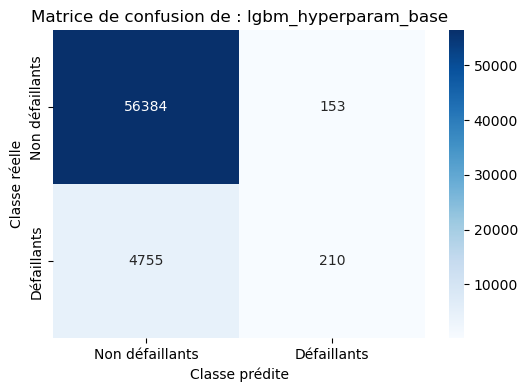

In [115]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_base, X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_hyperparam_base')

In [116]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_hyperparam_base',
                                        4755, 153, 210, 56384, df_taux)

**Avec rééquilibrage**

In [117]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_bal = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True,
                               class_weight='balanced')

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
1  0.683787   0.184241   0.29027  0.619213    0.66591  0.783201  0.280375   

   Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
1      0.717727    11.996595  12.425317  ...                    0.003922   

   Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
1         0.768356                    0.001093        0.694058   

   Test_recall_CV_plus_minus  Train_precision_CV  \
1                   0.008323            0.204906   

   Train_precision_CV_plus_minus  Test_precision_CV  \
1                       0.000461           0.185671   

   Test_precision_CV_plus_minus                     Model  
1                      0.002194  lgbm_hyperparam_base_bal  

[1 rows x 23 columns]

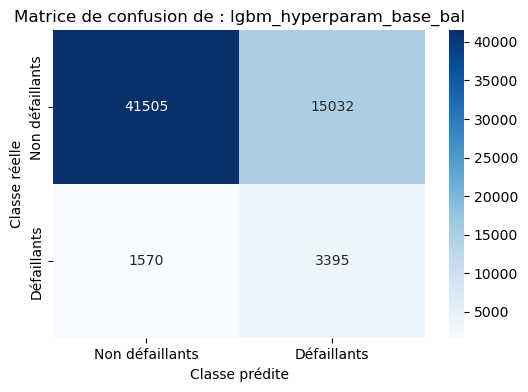

In [118]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_base_bal, X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_hyperparam_base_bal')

In [119]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_hyperparam_base_bal',
                            1570, 15032, 3395, 41505, df_taux)

In [120]:
df_taux

Modèle    FN     FP    TP     TN
0      lgbm_hyperparam_base  4755    153   210  56384
1  lgbm_hyperparam_base_bal  1570  15032  3395  41505

### <span style='background:PowderBlue'>Optimisation LGBM - Standardisation</span>

<span style='background:Moccasin'>**Standardisation - StandardScaler**</span>

In [121]:
# StandardScaler
scaler_std = StandardScaler()

# Jeu d'entraînement du jeu d'entraînement
X_train_std = scaler_std.fit_transform(X_train.copy(deep=True))
# Jeu de validation du jeu d'entraînement
X_valid_std = scaler_std.transform(X_valid.copy(deep=True))

# Sauvegarde de la standardisation
with open(path + 'sauvegarde/modelisation/standardisation_std.pickle', 'wb') as f:
    pickle.dump(scaler_std, f, pickle.HIGHEST_PROTOCOL)

**Sans rééquilibrage**

In [122]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_std = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
2  0.040081   0.534946  0.074574  0.041559   0.040451  0.781908  0.275066   

   Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
2      0.685298    13.183495  13.664637  ...                    0.003816   

   Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
2         0.059477                    0.002209        0.039627   

   Test_recall_CV_plus_minus  Train_precision_CV  \
2                   0.004407            0.762587   

   Train_precision_CV_plus_minus  Test_precision_CV  \
2                       0.007938            0.56216   

   Test_precision_CV_plus_minus                     Model  
2                      0.035772  lgbm_hyperparam_base_std  

[1 rows x 23 columns]

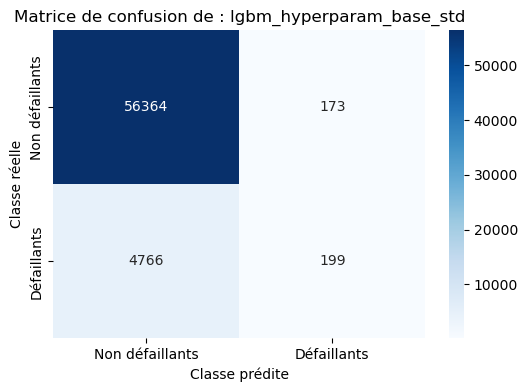

In [123]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_base_std, X_train_std,
                                        X_valid_std, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_hyperparam_base_std')

In [124]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_hyperparam_base_std',
                            4766, 173, 199, 56364, df_taux)

**Avec rééquilibrage**

In [125]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_std_bal = LGBMClassifier(random_state=seed, verbose=0,
                                   force_col_wise=True,
                                   class_weight='balanced')

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
3  0.694663   0.186402  0.293932  0.628726   0.676402  0.784745  0.281211   

   Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
3      0.721007     12.04817   12.31341  ...                    0.003996   

   Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
3         0.767702                     0.00165        0.693756   

   Test_recall_CV_plus_minus  Train_precision_CV  \
3                   0.010574            0.204621   

   Train_precision_CV_plus_minus  Test_precision_CV  \
3                       0.000529           0.185119   

   Test_precision_CV_plus_minus                         Model  
3                      0.002367  lgbm_hyperparam_base_std_bal  

[1 rows x 23 columns]

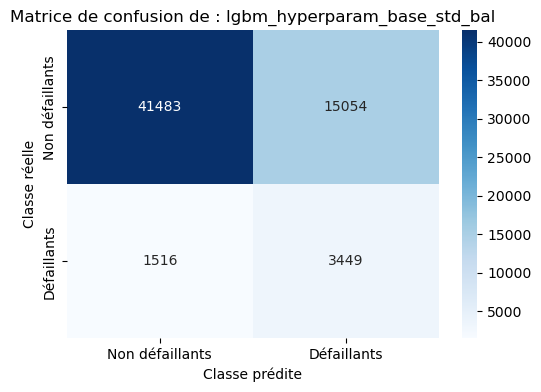

In [126]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_base_std_bal, X_train_std,
                                        X_valid_std, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_hyperparam_base_std_bal')

In [127]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_hyperparam_base_std_bal',
                                        1516, 15054, 3449, 41483, df_taux)

<span style='background:Moccasin'>**Standardisation - MinMaxScaler**</span>

In [128]:
# MinMaxScaler
scaler_min = MinMaxScaler()

# Jeu de la target de consommation d'énergie non transformée en log10
X_train_min = scaler_min.fit_transform(X_train.copy(deep=True))
X_valid_min = scaler_min.transform(X_valid.copy(deep=True))

# Sauvegarde de la standardisation
with open(path + 'sauvegarde/modelisation/scaler_min.pickle', 'wb') as f:
    pickle.dump(scaler_min, f, pickle.HIGHEST_PROTOCOL)

In [129]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_min = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score  ROC AUC    PR AUC  \
4  0.044109   0.582447  0.082007  0.045735   0.044516  0.78183  0.275042   

   Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
4      0.686801     9.468337   9.718394  ...                    0.004382   

   Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
4         0.058745                    0.001472         0.04003   

   Test_recall_CV_plus_minus  Train_precision_CV  \
4                   0.002859            0.765575   

   Train_precision_CV_plus_minus  Test_precision_CV  \
4                       0.010206           0.575279   

   Test_precision_CV_plus_minus                        Model  
4                      0.038632  lgbm_hyperparam_base_minmax  

[1 rows x 23 columns]

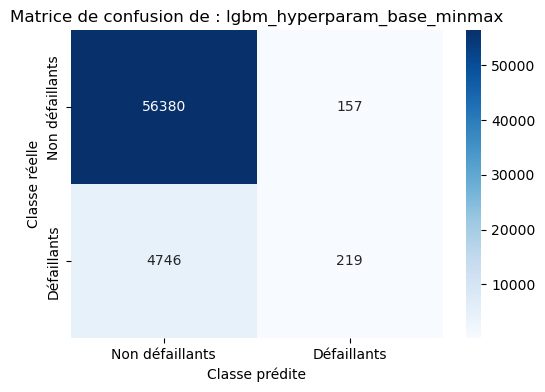

In [130]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_base_min, X_train_min,
                                        X_valid_min, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_hyperparam_base_minmax')

In [131]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_hyperparam_base_minmax',
                                        4746, 157, 219, 56380, df_taux)

<span style='background:Moccasin'>**Standardisation - RobustScaler**</span>

In [132]:
# RobustScaler
scaler_rob = RobustScaler()

X_train_rob = scaler_rob.fit_transform(X_train.copy(deep=True))
X_valid_rob = scaler_rob.transform(X_valid.copy(deep=True))

# Sauvegarde de la standardisation
with open(path + 'sauvegarde/modelisation/scaler_rob.pickle', 'wb') as f:
    pickle.dump(scaler_rob, f, pickle.HIGHEST_PROTOCOL)

In [133]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_base_rob = LGBMClassifier(random_state=seed, verbose=0,
                               force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
5  0.043303   0.593923  0.080721  0.044904   0.043704  0.782081  0.278269   

   Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
5      0.686658    10.401769  10.667831  ...                    0.004143   

   Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
5         0.059326                     0.00246        0.039275   

   Test_recall_CV_plus_minus  Train_precision_CV  \
5                   0.003355            0.760979   

   Train_precision_CV_plus_minus  Test_precision_CV  \
5                       0.007859           0.550189   

   Test_precision_CV_plus_minus                        Model  
5                      0.033918  lgbm_hyperparam_base_robust  

[1 rows x 23 columns]

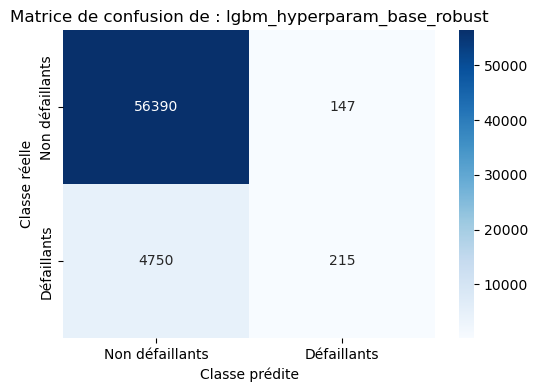

In [134]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_base_rob, X_train_rob,
                                        X_valid_rob, y_train, y_valid,
                                        df_resultats,
                                        'lgbm_hyperparam_base_robust')

In [135]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_hyperparam_base_robust',
                                        4750, 147, 215, 56390, df_taux)

**Bilan** :
Le nombre de faux négatifs sont globalement les mêmes pour le jeux d'entraînement non standardisé. Ce résultat nous conforte sur la connaissance théorique, à savoir que les algorithmes non basés sur des calculs de distances peuvent manipuler les données non standardisées.  

### <span style='background:PowderBlue'>Optimisation : OPTUNA intégré à LGBM</span>

#### <span style='background:Moccasin'>Optimisation LGBM : Optuna intégrée à LightGBM - Score ROC_AUC</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [18]:
# Modèle et hyperparamètres à étudier
def create_model(trial):
#     n_estimators = trial.suggest_int('n_estimators', 50, 10000)
    max_depth = trial.suggest_int('max_depth', 3, 11)
#     learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    lambda_l1 = trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
    lambda_l2 = trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.4, 1.0),
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
    bagging_freq = trial.suggest_int('bagging_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        class_weight='balanced',
#         n_estimators=n_estimators, 
        max_depth=max_depth, 
#         learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        lambda_l1=lambda_l1,
        lambda_l2=lambda_l2,
        num_leaves=num_leaves,
        feature_fraction=feature_fraction,
        bagging_fraction=bagging_fraction,
        bagging_freq=bagging_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [137]:
# Objective fonction
def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, y_proba)
    return score

In [17]:
# Recherche des p
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-05-09 09:55:13,320] A new study created in memory with name: no-name-004bfbe1-c7a9-4380-9e54-112676c768af


NameError: name 'objective' is not defined

In [140]:
params = study.best_params
print(f'Nombre d\'essai terminés : {len(study.trials)}')
print('Meilleurs hyperparamètres:\n')
print(params)

Nombre d'essai terminés : 100
Meilleurs hyperparamètres:

{'max_depth': 11, 'subsample': 0.6116516491088692, 'colsample_bytree': 0.2575879174421226, 'lambda_l1': 1.5239880391648468, 'lambda_l2': 6.252272977355993, 'num_leaves': 82, 'feature_fraction': 0.8889976022754118, 'bagging_fraction': 0.9513218034284208, 'bagging_freq': 2, 'min_child_samples': 72}


In [141]:
param_lgbm_optuna_opt_1 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced                                 
                           'max_depth': 11,
                           'subsample': 0.6116516491088692,               
                           'colsample_bytree': 0.2575879174421226,                          
                           'reg_alpha': 1.5239880391648468,
                           'reg_lambda': 6.252272977355993,
                           'num_leaves': 82,
                           'min_child_weight': 0.8889976022754118,
                           'subsample': 0.9513218034284208,
                           'subsample_freq': 2,
                           'min_child_samples': 72,
                           'verbosity' : -1}

In [142]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_1 = LGBMClassifier(**param_lgbm_optuna_opt_1,
                                      force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
6  0.661833   0.195235  0.301523  0.606118   0.646534  0.783573  0.278839   

   Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
6      0.728313     7.834742   8.164816  ...                    0.003677   

   Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
6         0.817774                    0.001251        0.663595   

   Test_recall_CV_plus_minus  Train_precision_CV  \
6                   0.010134            0.240602   

   Train_precision_CV_plus_minus  Test_precision_CV  \
6                       0.000429           0.196344   

   Test_precision_CV_plus_minus              Model  
6                      0.002592  lgbm_optuna_opt_1  

[1 rows x 23 columns]

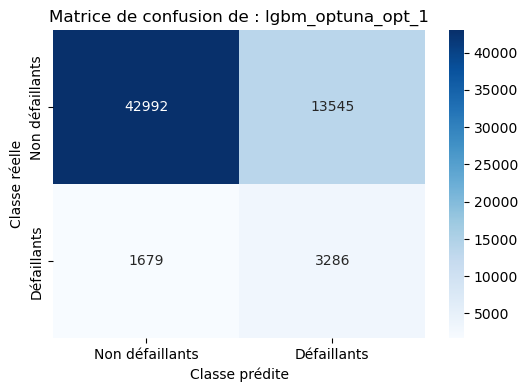

In [143]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_optuna_opt_1,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_1')

In [144]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_optuna_opt_1',
                                        1679, 13545, 3286, 42992, df_taux)

**Avec les hyperparamètres n_estimators et learning_rate**

In [145]:
# Modèle et hyperparamètres à étudier
def create_model_2(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 11)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        class_weight='balanced',
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [146]:
# Objective fonction
def objective_2(trial):
    model = create_model_2(trial)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, y_proba)
    return score

In [147]:
# Recherche des p
study_2 = optuna.create_study(direction='maximize')
study_2.optimize(objective_2, n_trials=100)

[I 2024-05-03 22:15:42,405] A new study created in memory with name: no-name-5e50e251-a0d9-4919-afbf-312fab894de8
[I 2024-05-03 22:15:56,136] Trial 0 finished with value: 0.7246060520821048 and parameters: {'n_estimators': 179, 'max_depth': 6, 'learning_rate': 0.5511219747909446, 'subsample': 0.5714809730191774, 'colsample_bytree': 0.9549437558760789, 'reg_alpha': 3.4440340884294764, 'reg_lambda': 0.0007286325822955965, 'num_leaves': 45, 'min_child_weight': 0.917605093150711, 'subsample_freq': 1, 'min_child_samples': 62}. Best is trial 0 with value: 0.7246060520821048.
[I 2024-05-03 22:16:25,644] Trial 1 finished with value: 0.7645224550700616 and parameters: {'n_estimators': 323, 'max_depth': 8, 'learning_rate': 0.15115105532864234, 'subsample': 0.8504188457953363, 'colsample_bytree': 0.8924486951110261, 'reg_alpha': 1.633922354787037e-08, 'reg_lambda': 3.0667842093597584e-06, 'num_leaves': 82, 'min_child_weight': 0.7186122898471409, 'subsample_freq': 6, 'min_child_samples': 66}. Best

In [148]:
params_2 = study_2.best_params
print(f'Nombre d\'essai terminés : {len(study_2.trials)}')
print('Best hyperparamètres:\n')
print(params_2)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'n_estimators': 470, 'max_depth': 9, 'learning_rate': 0.025924509204548363, 'subsample': 0.835963240449635, 'colsample_bytree': 0.7441531937411647, 'reg_alpha': 4.65660530154486e-05, 'reg_lambda': 2.1806516403544483e-05, 'num_leaves': 77, 'min_child_weight': 0.5906441532519994, 'subsample_freq': 3, 'min_child_samples': 44}


In [149]:
param_lgbm_optuna_opt_2 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced        
                           'colsample_bytree': 0.7441531937411647,
                           'max_depth': 9,
                           'min_child_weight': 0.5906441532519994,
                           'num_leaves': 77,
                           'reg_alpha': 4.65660530154486e-05,
                           'reg_lambda': 2.1806516403544483e-05,
                           'subsample': 0.835963240449635,
                           'subsample_freq': 3,
                           'min_child_samples': 44,
                           'n_estimators': 470,
                           'learning_rate': 0.025924509204548363,
                           'verbosity' : -1}

In [150]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_2 = LGBMClassifier(**param_lgbm_optuna_opt_2,
                                   force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
7  0.644512   0.203653  0.309508  0.594974   0.630987  0.787229  0.285318   

   Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
7       0.73498    54.087094  55.175894  ...                    0.004066   

   Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
7         0.849519                    0.001246        0.641893   

   Test_recall_CV_plus_minus  Train_precision_CV  \
7                   0.008953             0.26781   

   Train_precision_CV_plus_minus  Test_precision_CV  \
7                       0.000538           0.204314   

   Test_precision_CV_plus_minus              Model  
7                      0.002746  lgbm_optuna_opt_2  

[1 rows x 23 columns]

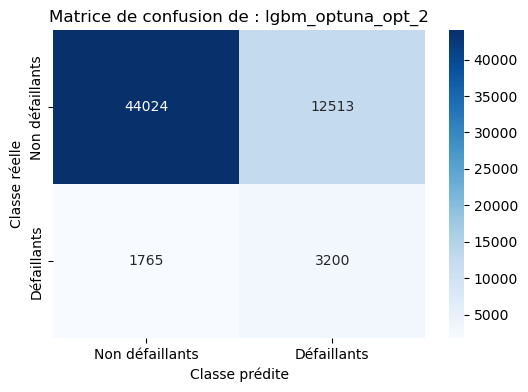

In [151]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_optuna_opt_2,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_2')

In [156]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_optuna_opt_2',
                                        1765, 12513, 3200, 44024, df_taux)

In [157]:
df_taux

Modèle    FN     FP    TP     TN
0          lgbm_hyperparam_base  4755    153   210  56384
1      lgbm_hyperparam_base_bal  1570  15032  3395  41505
2      lgbm_hyperparam_base_std  4766    173   199  56364
3  lgbm_hyperparam_base_std_bal  1516  15054  3449  41483
4   lgbm_hyperparam_base_minmax  4746    157   219  56380
5   lgbm_hyperparam_base_robust  4750    147   215  56390
6             lgbm_optuna_opt_1  1679  13545  3286  42992
7             lgbm_optuna_opt_2  1765  12513  3200  44024

In [158]:
# Sauvegarde du tableau de résultat
with open(path + 'sauvegarde/modelisation/df_resultat_scores.pickle', 'wb') as df:
    pickle.dump(df_resultats, df, pickle.HIGHEST_PROTOCOL)

#### <span style='background:Moccasin'>Optimisation LGBM : Optuna intégrée à LightGBM - Score Métrique métier</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [25]:
# Modèle et hyperparamètres à étudier
def create_model_3(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'custom_score',
        class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [26]:
# Objective fonction
def objective_3(trial):
    model = create_model_3(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = custom_score(y_valid, y_pred)
    return score

In [27]:
# Recherche des paramètres
study_3 = optuna.create_study(direction='maximize')
study_3.optimize(objective_3, n_trials=100)

[I 2024-05-09 09:56:52,874] A new study created in memory with name: no-name-67960f1e-c45c-42ed-8f09-faf8296a14ca
[I 2024-05-09 09:57:01,471] Trial 0 finished with value: 0.71341590682752 and parameters: {'max_depth': 10, 'subsample': 0.32253061384300563, 'colsample_bytree': 0.36591205860205633, 'reg_alpha': 3.269835802831298, 'reg_lambda': 5.024300134052708e-05, 'num_leaves': 27, 'min_child_weight': 0.6161898075657611, 'subsample_freq': 1, 'min_child_samples': 47}. Best is trial 0 with value: 0.71341590682752.
[I 2024-05-09 09:57:13,679] Trial 1 finished with value: 0.7226890255174758 and parameters: {'max_depth': 11, 'subsample': 0.4821067105004959, 'colsample_bytree': 0.5715937655853455, 'reg_alpha': 0.00017358141758594826, 'reg_lambda': 0.03421322123862068, 'num_leaves': 65, 'min_child_weight': 0.8953879183915736, 'subsample_freq': 4, 'min_child_samples': 16}. Best is trial 1 with value: 0.7226890255174758.
[I 2024-05-09 09:57:20,649] Trial 2 finished with value: 0.726791858738498 

In [28]:
params_3 = study_3.best_params
print(f'Nombre d\'essai terminés : {len(study_3.trials)}')
print('Best hyperparamètres:\n')
print(params_3)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 10, 'subsample': 0.951115951695195, 'colsample_bytree': 0.759692996149713, 'reg_alpha': 0.0007395299742089536, 'reg_lambda': 0.004164360249132748, 'num_leaves': 256, 'min_child_weight': 0.8946082751939394, 'subsample_freq': 2, 'min_child_samples': 73}


In [29]:
param_lgbm_optuna_opt_3 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced        
                           'colsample_bytree': 0.759692996149713,
                           'max_depth': 10,
                           'min_child_weight': 0.8946082751939394,
                           'num_leaves': 256,
                           'reg_alpha': 0.0007395299742089536,
                           'reg_lambda': 0.004164360249132748,
                           'subsample': 0.951115951695195,
                           'subsample_freq': 2,
                           'min_child_samples': 73,
                           'verbosity' : -1}

In [30]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_3 = LGBMClassifier(**param_lgbm_optuna_opt_3,
                                      force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score  ROC AUC    PR AUC  \
8  0.557503   0.219962   0.31546  0.526432   0.549159  0.77682  0.269833   

   Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
8      0.738808    19.993802  20.465173  ...                     0.00432   

   Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
8         0.936545                    0.002389        0.545871   

   Test_recall_CV_plus_minus  Train_precision_CV  \
8                   0.008567            0.371712   

   Train_precision_CV_plus_minus  Test_precision_CV  \
8                       0.001999           0.223189   

   Test_precision_CV_plus_minus              Model  
8                      0.003333  lgbm_optuna_opt_3  

[1 rows x 23 columns]

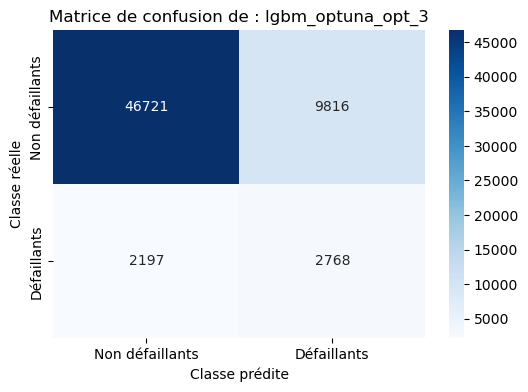

In [31]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_optuna_opt_3,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_3')

In [32]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_optuna_opt_3',
                                        2197, 9816, 2768, 46721, df_taux)

#### <span style='background:Moccasin'>Optimisation LGBM : Optuna intégrée à LightGBM - Score PR_AUC</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [33]:
# Modèle et hyperparamètres à étudier
def create_model_4(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'pr_auc',
        class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [34]:
# Objective fonction
def objective_4(trial):
    model = create_model_3(trial)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_valid)[:,1]
    score = average_precision_score(y_valid, y_proba)
    return score

In [35]:
# Recherche des paramètres
study_4 = optuna.create_study(direction='maximize')
study_4.optimize(objective_4, n_trials=100)

[I 2024-05-09 10:31:46,092] A new study created in memory with name: no-name-92e93518-36ec-4b01-94f1-d3cf60608a65
[I 2024-05-09 10:31:52,658] Trial 0 finished with value: 0.2716189145193235 and parameters: {'max_depth': 4, 'subsample': 0.904526167800574, 'colsample_bytree': 0.9124163810198993, 'reg_alpha': 2.152373071458895e-06, 'reg_lambda': 0.00051913265563468, 'num_leaves': 140, 'min_child_weight': 0.5475604842979046, 'subsample_freq': 5, 'min_child_samples': 42}. Best is trial 0 with value: 0.2716189145193235.
[I 2024-05-09 10:31:57,445] Trial 1 finished with value: 0.26197417496220055 and parameters: {'max_depth': 3, 'subsample': 0.6962898216911119, 'colsample_bytree': 0.7396383423930877, 'reg_alpha': 6.925988247017159e-08, 'reg_lambda': 0.001294413042485223, 'num_leaves': 81, 'min_child_weight': 0.6298055179354414, 'subsample_freq': 1, 'min_child_samples': 77}. Best is trial 0 with value: 0.2716189145193235.
[I 2024-05-09 10:32:05,309] Trial 2 finished with value: 0.2636914894301

In [36]:
params_4 = study_4.best_params
print(f'Nombre d\'essai terminés : {len(study_4.trials)}')
print('Best hyperparamètres:\n')
print(params_4)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 10, 'subsample': 0.9331981987944917, 'colsample_bytree': 0.9234637718650685, 'reg_alpha': 2.8530313129574635e-08, 'reg_lambda': 0.00020562391310663912, 'num_leaves': 36, 'min_child_weight': 0.4111962732940035, 'subsample_freq': 3, 'min_child_samples': 55}


In [37]:
param_lgbm_optuna_opt_4 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced        
                           'colsample_bytree': 0.9234637718650685,
                           'max_depth': 10,
                           'min_child_weight': 0.4111962732940035,
                           'num_leaves': 36,
                           'reg_alpha': 2.8530313129574635e-08,
                           'reg_lambda': 0.00020562391310663912,
                           'subsample': 0.9331981987944917,
                           'subsample_freq': 3,
                           'min_child_samples': 55,
                           'verbosity' : -1}

In [38]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_4 = LGBMClassifier(**param_lgbm_optuna_opt_4,
                                      force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
9  0.685398   0.186221   0.29287  0.621339   0.667677  0.782982  0.277108   

   Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
9      0.720172    15.487197  15.836781  ...                    0.004554   

   Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
9         0.774818                    0.001584        0.690987   

   Test_recall_CV_plus_minus  Train_precision_CV  \
9                   0.012756            0.209677   

   Train_precision_CV_plus_minus  Test_precision_CV  \
9                       0.000671           0.187276   

   Test_precision_CV_plus_minus              Model  
9                      0.002812  lgbm_optuna_opt_4  

[1 rows x 23 columns]

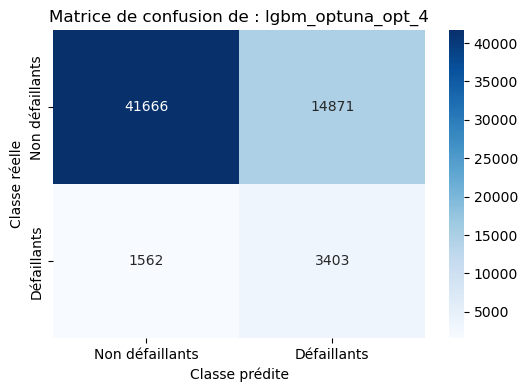

In [39]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_optuna_opt_4,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_4')

In [40]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_optuna_opt_4',
                                        1562, 14871, 3403, 41666, df_taux)

#### <span style='background:Moccasin'>Optimisation LGBM : Optuna intégrée à LightGBM - Score F10</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [41]:
# Modèle et hyperparamètres à étudier
def create_model_5(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'f10_score',
        class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

# Objective fonction
def objective_5(trial):
    model = create_model_3(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = fbeta_score(y_valid, y_pred, beta=10)
    return score

In [42]:
# Recherche des paramètres
study_5 = optuna.create_study(direction='maximize')
study_5.optimize(objective_5, n_trials=100)

[I 2024-05-09 11:03:25,292] A new study created in memory with name: no-name-49561575-7e9a-46b9-af3d-5bb4e3362375
[I 2024-05-09 11:03:40,921] Trial 0 finished with value: 0.4639593509518521 and parameters: {'max_depth': 11, 'subsample': 0.10041128513994035, 'colsample_bytree': 0.9224125676907625, 'reg_alpha': 0.016250852644312693, 'reg_lambda': 2.97771252613664e-07, 'num_leaves': 213, 'min_child_weight': 0.8830992294847331, 'subsample_freq': 2, 'min_child_samples': 7}. Best is trial 0 with value: 0.4639593509518521.
[I 2024-05-09 11:03:51,198] Trial 1 finished with value: 0.6260809974184556 and parameters: {'max_depth': 9, 'subsample': 0.21447550449047154, 'colsample_bytree': 0.4149414373404824, 'reg_alpha': 0.00017859981806120844, 'reg_lambda': 5.059753725069633e-08, 'num_leaves': 73, 'min_child_weight': 0.4683014991394252, 'subsample_freq': 3, 'min_child_samples': 71}. Best is trial 1 with value: 0.6260809974184556.
[I 2024-05-09 11:04:16,513] Trial 2 finished with value: 0.613315983

In [43]:
params_5 = study_5.best_params
print(f'Nombre d\'essai terminés : {len(study_5.trials)}')
print('Best hyperparamètres:\n')
print(params_5)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 8, 'subsample': 0.5572465639400604, 'colsample_bytree': 0.942643005209126, 'reg_alpha': 1.3788599856023566e-05, 'reg_lambda': 1.4867533700934656e-07, 'num_leaves': 14, 'min_child_weight': 0.5225481447282847, 'subsample_freq': 2, 'min_child_samples': 47}


In [175]:
param_lgbm_optuna_opt_5 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,
                           'class_weight' : 'balanced', # Balanced        
                           'colsample_bytree': 0.942643005209126,
                           'max_depth': 8,
                           'min_child_samples': 47,
                           'min_child_weight': 0.5225481447282847,
                           'num_leaves': 14,
                           'reg_alpha': 1.3788599856023566e-05,
                           'reg_lambda': 1.4867533700934656e-07,
                           'subsample': 0.5572465639400604,
                           'subsample_freq': 2,
                           'verbosity' : -1}

In [176]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_5 = LGBMClassifier(**param_lgbm_optuna_opt_5,
                                      force_col_wise=True)

In [177]:
lgbm_optuna_opt_5

LGBMClassifier(class_weight='balanced', colsample_bytree=0.942643005209126,
               force_col_wise=True, max_depth=8, min_child_samples=47,
               min_child_weight=0.5225481447282847, n_jobs=-1, num_leaves=14,
               objective='binary', reg_alpha=1.3788599856023566e-05,
               reg_lambda=1.4867533700934656e-07, subsample=0.5572465639400604,
               subsample_freq=2, verbosity=-1)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
10  0.703726   0.180085  0.286781   0.63294   0.684033  0.780131  0.271803   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
10      0.713774     7.075671   7.349205  ...                    0.004401   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
10         0.736595                    0.002177        0.706294   

    Test_recall_CV_plus_minus  Train_precision_CV  \
10                   0.010543            0.186979   

    Train_precision_CV_plus_minus  Test_precision_CV  \
10                       0.000638            0.17959   

    Test_precision_CV_plus_minus              Model  
10                      0.002657  lgbm_optuna_opt_5  

[1 rows x 23 columns]

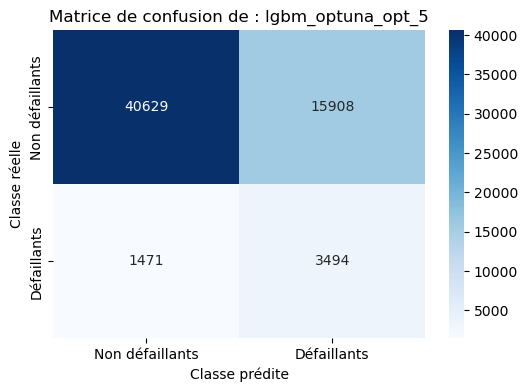

In [46]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_optuna_opt_5,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_5')

In [47]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_optuna_opt_5',
                                        1471, 15908, 3494, 40629, df_taux)

#### <span style='background:Moccasin'>Optimisation LGBM : Optuna intégrée à LightGBM - Score F1</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [48]:
# Modèle et hyperparamètres à étudier
def create_model_F1(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'f1_score',
        class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [49]:
# Objective fonction
def objective_F1(trial):
    model = create_model_F1(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = fbeta_score(y_valid, y_pred, beta=1)
    return score

In [50]:
# Recherche des paramètres
study_F1 = optuna.create_study(direction='maximize')
study_F1.optimize(objective_F1, n_trials=100)

[I 2024-05-09 11:35:19,550] A new study created in memory with name: no-name-e57e4000-d82a-4e7c-9240-1d57bb0eb42b
[I 2024-05-09 11:35:31,012] Trial 0 finished with value: 0.30245535714285715 and parameters: {'max_depth': 7, 'subsample': 0.8791428356511404, 'colsample_bytree': 0.3685058864559887, 'reg_alpha': 6.860681169854384e-08, 'reg_lambda': 3.1888024212331824e-07, 'num_leaves': 144, 'min_child_weight': 0.7286677884203876, 'subsample_freq': 3, 'min_child_samples': 99}. Best is trial 0 with value: 0.30245535714285715.
[I 2024-05-09 11:35:38,690] Trial 1 finished with value: 0.28451091627986935 and parameters: {'max_depth': 6, 'subsample': 0.19021355680568044, 'colsample_bytree': 0.14309556894888426, 'reg_alpha': 1.1099578272241482e-06, 'reg_lambda': 1.8897649046593735e-07, 'num_leaves': 142, 'min_child_weight': 0.9798549297540396, 'subsample_freq': 4, 'min_child_samples': 17}. Best is trial 0 with value: 0.30245535714285715.
[I 2024-05-09 11:35:50,030] Trial 2 finished with value: 0.

In [51]:
params_F1 = study_F1.best_params
print(f'Nombre d\'essai terminés : {len(study_F1.trials)}')
print('Best hyperparamètres:\n')
print(params_F1)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.7684079703092203, 'colsample_bytree': 0.7487495631206145, 'reg_alpha': 0.02998009377883562, 'reg_lambda': 2.133728126441071, 'num_leaves': 254, 'min_child_weight': 0.5039632040210911, 'subsample_freq': 6, 'min_child_samples': 38}


In [52]:
param_lgbm_optuna_opt_F1 = {'objective' : 'binary',
                            'boosting_type' : 'gbdt',
                            'n_jobs' : -1,
                            'class_weight' : 'balanced', # Balanced        
                            'colsample_bytree': 0.7487495631206145,
                            'max_depth': 11,
                            'min_child_samples': 38,
                            'min_child_weight': 0.5039632040210911,
                            'num_leaves': 254,
                            'reg_alpha': 0.02998009377883562,
                            'reg_lambda': 2.133728126441071,
                            'subsample': 0.7684079703092203,
                            'subsample_freq': 6,
                            'verbosity' : -1}

In [53]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_F1 = LGBMClassifier(**param_lgbm_optuna_opt_F1,
                                    force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC   PR AUC  \
11  0.543807   0.224402  0.317703  0.515581   0.536249  0.773951  0.26584   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
11       0.74012    20.169611  20.578243  ...                    0.004989   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
11         0.941753                    0.002256        0.539627   

    Test_recall_CV_plus_minus  Train_precision_CV  \
11                    0.00926            0.382401   

    Train_precision_CV_plus_minus  Test_precision_CV  \
11                       0.002817           0.226665   

    Test_precision_CV_plus_minus               Model  
11                      0.003687  lgbm_optuna_opt_F1  

[1 rows x 23 columns]

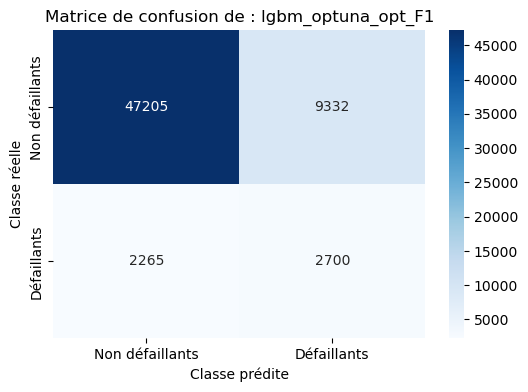

In [54]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_optuna_opt_F1,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_F1')

In [55]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_optuna_opt_F1',
                                        2265, 9332, 2700, 47205, df_taux)

#### <span style='background:Moccasin'>Optimisation LGBM : Optuna intégrée à LightGBM - Score F5</span>

**Sans les hyperparamètres n_estimators et learning_rate**

In [56]:
# Modèle et hyperparamètres à étudier
def create_model_F5(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'f5_score',
        class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [57]:
# Objective fonction
def objective_F5(trial):
    model = create_model_F5(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    score = fbeta_score(y_valid, y_pred, beta=5)
    return score

In [58]:
# Recherche des paramètres
study_F5 = optuna.create_study(direction='maximize')
study_F5.optimize(objective_F5, n_trials=100)

[I 2024-05-09 12:21:31,305] A new study created in memory with name: no-name-31bcf6f5-6259-40b4-931c-87b3c1ea59df
[I 2024-05-09 12:21:48,713] Trial 0 finished with value: 0.5650545842094651 and parameters: {'max_depth': 11, 'subsample': 0.8055803752934466, 'colsample_bytree': 0.8982996521563966, 'reg_alpha': 0.05396497143961828, 'reg_lambda': 4.725322169882623e-05, 'num_leaves': 126, 'min_child_weight': 0.9618157875633189, 'subsample_freq': 1, 'min_child_samples': 6}. Best is trial 0 with value: 0.5650545842094651.
[I 2024-05-09 12:21:58,501] Trial 1 finished with value: 0.5823490907021089 and parameters: {'max_depth': 11, 'subsample': 0.3546504229210714, 'colsample_bytree': 0.3896637321640434, 'reg_alpha': 0.6480983126811173, 'reg_lambda': 1.1403703639231385e-05, 'num_leaves': 89, 'min_child_weight': 0.5392028635795626, 'subsample_freq': 6, 'min_child_samples': 52}. Best is trial 1 with value: 0.5823490907021089.
[I 2024-05-09 12:22:05,279] Trial 2 finished with value: 0.6221616964509

In [59]:
params_F5 = study_F5.best_params
print(f'Nombre d\'essai terminés : {len(study_F5.trials)}')
print('Best hyperparamètres:\n')
print(params_F5)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 8, 'subsample': 0.279042104708411, 'colsample_bytree': 0.6836083568347792, 'reg_alpha': 0.21553073625748978, 'reg_lambda': 0.00925933949533366, 'num_leaves': 12, 'min_child_weight': 0.7206088709853578, 'subsample_freq': 4, 'min_child_samples': 90}


In [60]:
param_lgbm_optuna_opt_F5 = {'objective' : 'binary',
                            'boosting_type' : 'gbdt',
                            'n_jobs' : -1,
                            'class_weight' : 'balanced', # Balanced        
                            'colsample_bytree': 0.6836083568347792,
                            'max_depth': 8,
                            'min_child_samples': 90,
                            'min_child_weight': 0.7206088709853578,
                            'num_leaves': 12,
                            'reg_alpha': 0.21553073625748978,
                            'reg_lambda': 0.00925933949533366,
                            'subsample': 0.279042104708411,
                            'subsample_freq': 4,
                            'verbosity' : -1}

In [61]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_opt_F5 = LGBMClassifier(**param_lgbm_optuna_opt_F5,
                                    force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
12  0.701309   0.176931  0.282573  0.629547   0.681317  0.777379  0.270662   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
12      0.709528     5.050652   5.320714  ...                     0.00453   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
12         0.731599                    0.001719        0.707553   

    Test_recall_CV_plus_minus  Train_precision_CV  \
12                   0.008285            0.182828   

    Train_precision_CV_plus_minus  Test_precision_CV  \
12                       0.000447           0.176802   

    Test_precision_CV_plus_minus               Model  
12                      0.001904  lgbm_optuna_opt_F5  

[1 rows x 23 columns]

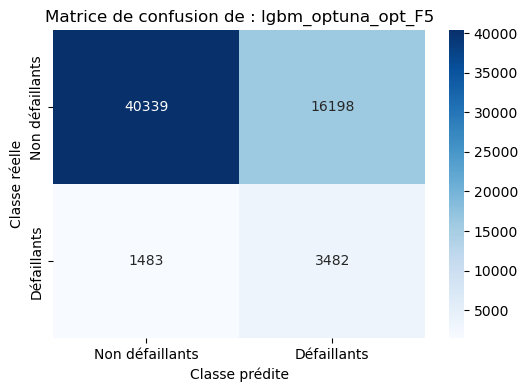

In [62]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_optuna_opt_F5,
                                        X_train, X_valid,
                                        y_train, y_valid, df_resultats,
                                        'lgbm_optuna_opt_F5')

In [63]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_optuna_opt_F5',
                                        1483, 16198, 3482, 40339, df_taux)

### <span style='background:PowderBlue'>Optimisation : rééquilibrage des classes</span>

**Répartition variable cible?**

In [64]:
from collections import Counter

# Jeu d'entraînement du jeu d'entraînement
# Répartition des la cible 0 (non-défaillants) - 1 (défaillants)?
y_train_distrib = Counter(y_train)
print('Répartition des classes : ')
print(y_train_distrib)
# Pourcentage
y_train_distrib_norm = y_train.value_counts(normalize=True)*100
print('\nRépartition des classes (en %) :')
print(y_train_distrib_norm)

Répartition des classes : 
Counter({0: 226145, 1: 19860})

Répartition des classes (en %) :
TARGET
0    91.926993
1     8.073007
Name: proportion, dtype: float64


In [65]:
# Jeu de validation du jeu d'entraînement
# Répartition des la cible 0 (non-défaillants) - 1 (défaillants)?
y_valid_distrib = Counter(y_valid)
print('Répartition des classes : ')
print(y_valid_distrib)
# Pourcentage
y_valid_distrib_norm = y_valid.value_counts(normalize=True)*100
print('\nRépartition des classes (en %) :')
print(y_valid_distrib_norm)

Répartition des classes : 
Counter({0: 56537, 1: 4965})

Répartition des classes (en %) :
TARGET
0    91.927092
1     8.072908
Name: proportion, dtype: float64


**Bilan** :
- La variable cible est fortement déséquilibrée 90% de non défaillants et 10% de défaillants ==> on tentera un rééquilibrage de la variable cible pour optimiser le modèle.

Plusieurs méthodes de réquilibrage sont à notre disposition :
- undersampling : consiste en un sous-échantillonnage de la classe majoritaire.
- oversampling : sur-échantillonnage de la classe minoritaire (ex : SMOTE, ADASYN).
- une combinaison d'oversampling suivi d'undersampling (possible avec SMOTE).
- hyperparamètre du modèle Ligthgbm : class_weight='balanced'.

#### <span style='background:Moccasin'>Rééquilibrage - oversampling : SMOTE</span>

**SMOTE - paramètres par défaut**

In [66]:
# Répartition des classes au départ
counter_original = Counter(y_train)
print(counter_original)
# Application de l'oversampling via SMOTE avec les paramètres par défaut
oversample = SMOTE()
X_train_smote, y_train_smote = \
    oversample.fit_resample(X_train, y_train)
X_valid_smote, y_valid_smote = \
    oversample.fit_resample(X_valid, y_valid)
# Répartition après oversampling SMOTE paramètres par défaut
counter_smote_def = Counter(y_train_smote)
print(counter_smote_def)

Counter({0: 226145, 1: 19860})
Counter({0: 226145, 1: 226145})


#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base**</span>

In [67]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_base = LGBMClassifier(random_state=seed, verbose=0,
                                 force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
13  0.913349    0.99668  0.953197  0.916295   0.914105  0.979584  0.985288   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
13      0.926212    19.094489  19.777648  ...                    0.087564   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
13         0.914488                     0.02799        0.910524   

    Test_recall_CV_plus_minus  Train_precision_CV  \
13                   0.262973             0.99702   

    Train_precision_CV_plus_minus  Test_precision_CV  \
13                       0.001014           0.996835   

    Test_precision_CV_plus_minus                       Model  
13                      0.001135  lgbm_smote_hyperparam_base  

[1 rows x 23 columns]

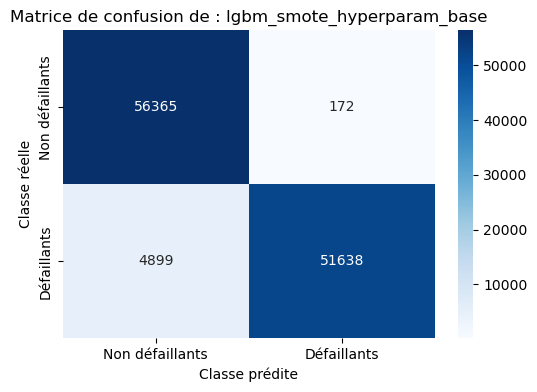

In [68]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_smote_base,
                                        X_train_smote, X_valid_smote,
                                        y_train_smote, y_valid_smote,
                                        df_resultats,
                                        'lgbm_smote_hyperparam_base')

In [69]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_smote_hyperparam_base',
                                        4899, 172, 51638, 56365, df_taux)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
14  0.042296   0.578512  0.078829   0.04386   0.042688  0.781519  0.276539   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
14      0.686258    10.028843  10.406575  ...                    0.004946   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
14         0.059483                    0.002252        0.040836   

    Test_recall_CV_plus_minus  Train_precision_CV  \
14                   0.004557            0.763636   

    Train_precision_CV_plus_minus  Test_precision_CV  \
14                       0.006599           0.565895   

    Test_precision_CV_plus_minus                             Model  
14                      0.043276  lgbm_smote_hyperparam_base_train  

[1 rows x 23 columns]

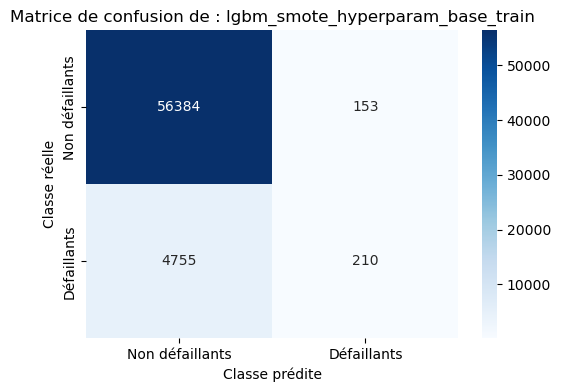

In [70]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_smote_base,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_hyperparam_base_train')

In [71]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_smote_hyperparam_base_train',
                                        4755, 153, 210, 56384, df_taux)

#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base + class_weight='balanced'**</span>

In [72]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_base_bal = LGBMClassifier(class_weight='balanced',
                                     random_state=seed, verbose=0,
                                     force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
15  0.913349    0.99668  0.953197  0.916295   0.914105  0.979584  0.985288   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
15      0.926212    24.502382  25.396447  ...                    0.087564   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
15         0.914488                     0.02799        0.910524   

    Test_recall_CV_plus_minus  Train_precision_CV  \
15                   0.262973            0.997019   

    Train_precision_CV_plus_minus  Test_precision_CV  \
15                       0.001014           0.996835   

    Test_precision_CV_plus_minus                Model  
15                      0.001135  lgbm_smote_base_bal  

[1 rows x 23 columns]

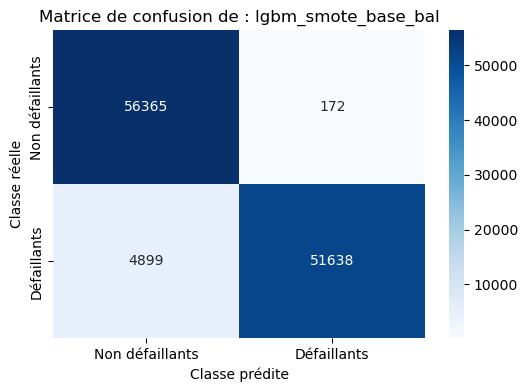

In [73]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_smote_base_bal,
                                        X_train_smote, X_valid_smote,
                                        y_train_smote, y_valid_smote,
                                        df_resultats,
                                        'lgbm_smote_base_bal')

In [74]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_smote_base_bal',
                                        4899, 172, 51638, 56365, df_taux)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
16  0.683787   0.184241   0.29027  0.619213    0.66591  0.783201  0.280375   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
16      0.717727    11.095966  11.441344  ...                    0.003922   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
16         0.768356                    0.001093        0.694058   

    Test_recall_CV_plus_minus  Train_precision_CV  \
16                   0.008323            0.204906   

    Train_precision_CV_plus_minus  Test_precision_CV  \
16                       0.000461           0.185671   

    Test_precision_CV_plus_minus                      Model  
16                      0.002194  lgbm_smote_base_bal_train  

[1 rows x 23 columns]

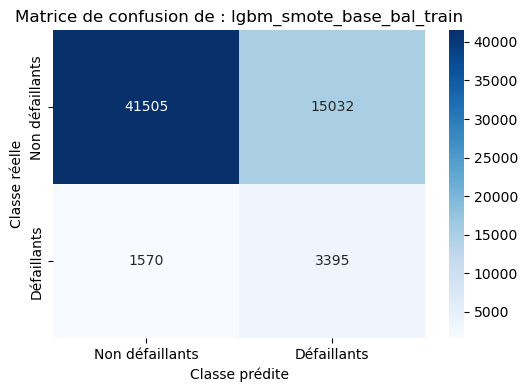

In [75]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_smote_base_bal,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_base_bal_train')

In [76]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_smote_base_bal_train',
                                        1570, 15032, 3395, 41505, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score ROC_AUC**</span>

In [77]:
# Modèle et hyperparamètres à étudier
def create_model_7(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [78]:
# Objective fonction
def objective_7(trial):
    model = create_model_7(trial)
    model.fit(X_train_smote, y_train_smote)
    y_proba_smote = model.predict_proba(X_valid_smote)[:,1]
    score = roc_auc_score(y_valid_smote, y_proba_smote)
    return score

In [79]:
# Recherche des paramètres
study_7 = optuna.create_study(direction='maximize')
study_7.optimize(objective_7, n_trials=100)

[I 2024-05-09 13:09:36,983] A new study created in memory with name: no-name-c420adff-41c0-4a89-b337-2aa049c8f7bf
[I 2024-05-09 13:09:52,912] Trial 0 finished with value: 0.9790844697205606 and parameters: {'max_depth': 8, 'subsample': 0.7963645270365959, 'colsample_bytree': 0.4726010207207031, 'reg_alpha': 1.8939804888194092e-05, 'reg_lambda': 0.2673386122549685, 'num_leaves': 32, 'min_child_weight': 0.959068376710845, 'subsample_freq': 3, 'min_child_samples': 19}. Best is trial 0 with value: 0.9790844697205606.
[I 2024-05-09 13:10:13,561] Trial 1 finished with value: 0.9793431465528999 and parameters: {'max_depth': 9, 'subsample': 0.5666479305775532, 'colsample_bytree': 0.5114718027732396, 'reg_alpha': 0.003732225308062863, 'reg_lambda': 2.915228237597456e-07, 'num_leaves': 161, 'min_child_weight': 0.7801794991195752, 'subsample_freq': 4, 'min_child_samples': 90}. Best is trial 1 with value: 0.9793431465528999.
[I 2024-05-09 13:10:34,306] Trial 2 finished with value: 0.97924472776480

In [80]:
params_7 = study_7.best_params
print(f'Nombre d\'essai terminés : {len(study_7.trials)}')
print('Best hyperparamètres:\n')
print(params_7)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.9452245779238514, 'colsample_bytree': 0.8228847541512331, 'reg_alpha': 2.4293721680115077, 'reg_lambda': 1.0557439232121982e-08, 'num_leaves': 89, 'min_child_weight': 0.8003264529698282, 'subsample_freq': 1, 'min_child_samples': 54}


In [81]:
param_lgbm_optuna_opt_7 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,    
                           'colsample_bytree': 0.8228847541512331,
                           'max_depth': 11,
                           'min_child_samples': 54,
                           'min_child_weight': 0.8003264529698282,
                           'num_leaves': 89,
                           'reg_alpha': 2.4293721680115077,
                           'reg_lambda': 1.0557439232121982e-08,
                           'subsample': 0.9452245779238514,
                           'subsample_freq': 1,
                           'verbosity' : -1}

In [82]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_7 = LGBMClassifier(**param_lgbm_optuna_opt_7,
                                         force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score  ROC AUC    PR AUC  \
17  0.914445   0.996031  0.953496  0.917335   0.915188     0.98  0.985547   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
17      0.927047    28.833652  29.398747  ...                    0.084884   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
17         0.918905                    0.026883        0.911219   

    Test_recall_CV_plus_minus  Train_precision_CV  \
17                   0.263175            0.997361   

    Train_precision_CV_plus_minus  Test_precision_CV  \
17                       0.000887           0.995735   

    Test_precision_CV_plus_minus                    Model  
17                      0.001451  lgbm_optuna_smote_opt_7  

[1 rows x 23 columns]

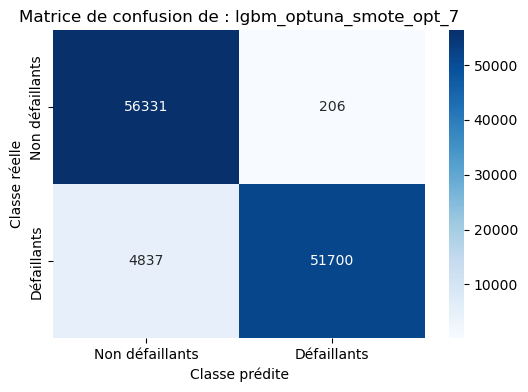

In [83]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_optuna_smote_opt_7,
                                        X_train_smote, X_valid_smote,
                                        y_train_smote, y_valid_smote,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_7')

In [84]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_optuna_smote_opt_7',
                                        4837, 206, 51700, 56331, df_taux)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
18  0.052165   0.532922  0.095028   0.05404   0.052635  0.784147  0.277895   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
18       0.68859    17.082819  17.521447  ...                    0.003993   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
18         0.115469                    0.002445        0.049496   

    Test_recall_CV_plus_minus  Train_precision_CV  \
18                   0.003748            0.885453   

    Train_precision_CV_plus_minus  Test_precision_CV  \
18                       0.005022           0.536421   

    Test_precision_CV_plus_minus                          Model  
18                      0.027584  lgbm_optuna_smote_opt_7_train  

[1 rows x 23 columns]

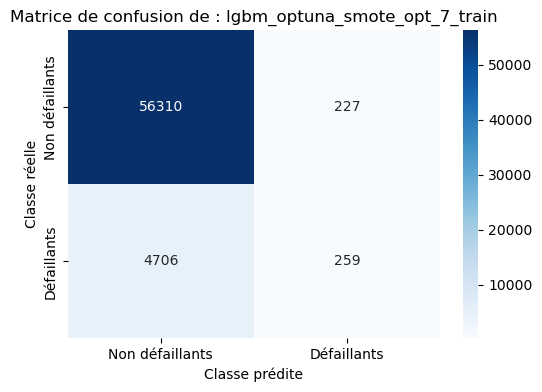

In [85]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_optuna_smote_opt_7,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_7_train')

In [86]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_optuna_smote_opt_7_train',
                                        4706, 227, 259, 56310, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score F10**</span>

In [87]:
# Modèle et hyperparamètres à étudier
def create_model_6(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'f10_score',
#         class_weight='balanced',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [88]:
# Objective fonction
def objective_6(trial):
    model = create_model_6(trial)
    model.fit(X_train_smote, y_train_smote)
    y_pred_smote = model.predict(X_valid_smote)
    score = fbeta_score(y_valid_smote, y_pred_smote, beta=10)
    return score

In [89]:
# Recherche des paramètres
study_6 = optuna.create_study(direction='maximize')
study_6.optimize(objective_6, n_trials=100)

[I 2024-05-09 14:12:04,661] A new study created in memory with name: no-name-e71efa09-7326-476e-9a54-7c49ffbef6af
[I 2024-05-09 14:12:14,446] Trial 0 finished with value: 0.9091032263141907 and parameters: {'max_depth': 3, 'subsample': 0.7732355659091212, 'colsample_bytree': 0.9538536609511501, 'reg_alpha': 0.00013078380431445777, 'reg_lambda': 2.2190623443062952e-08, 'num_leaves': 98, 'min_child_weight': 0.6155937521223752, 'subsample_freq': 5, 'min_child_samples': 5}. Best is trial 0 with value: 0.9091032263141907.
[I 2024-05-09 14:12:27,708] Trial 1 finished with value: 0.9156960996393706 and parameters: {'max_depth': 11, 'subsample': 0.16561622322385083, 'colsample_bytree': 0.627324621125636, 'reg_alpha': 3.902459856122863e-08, 'reg_lambda': 0.00011285521240654468, 'num_leaves': 78, 'min_child_weight': 0.9862162007109556, 'subsample_freq': 5, 'min_child_samples': 17}. Best is trial 1 with value: 0.9156960996393706.
[I 2024-05-09 14:12:38,567] Trial 2 finished with value: 0.91227330

In [90]:
params_6 = study_6.best_params
print(f'Nombre d\'essai terminés : {len(study_6.trials)}')
print('Best hyperparamètres:\n')
print(params_6)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.11886916428602304, 'colsample_bytree': 0.9326054657780497, 'reg_alpha': 6.50502574647442e-07, 'reg_lambda': 3.4176747655835844e-08, 'num_leaves': 218, 'min_child_weight': 0.7352573050920377, 'subsample_freq': 7, 'min_child_samples': 10}


In [91]:
param_lgbm_optuna_opt_6 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,    
                           'colsample_bytree': 0.9326054657780497,
                           'max_depth': 11,
                           'min_child_samples': 10,
                           'min_child_weight': 0.7352573050920377,
                           'num_leaves': 218,
                           'reg_alpha': 6.50502574647442e-07,
                           'reg_lambda': 3.4176747655835844e-08,
                           'subsample': 0.11886916428602304,
                           'subsample_freq': 7,
                           'verbosity' : -1}

In [92]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_6 = LGBMClassifier(**param_lgbm_optuna_opt_6,
                                         force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
19  0.917382   0.985558  0.950249  0.919829    0.91801  0.976732  0.983593   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
19      0.928024    25.517595  26.323805  ...                    0.080254   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
19         0.929416                    0.023303        0.910794   

    Test_recall_CV_plus_minus  Train_precision_CV  \
19                   0.263004            0.989738   

    Train_precision_CV_plus_minus  Test_precision_CV  \
19                       0.003426           0.984698   

    Test_precision_CV_plus_minus                    Model  
19                      0.005174  lgbm_optuna_smote_opt_6  

[1 rows x 23 columns]

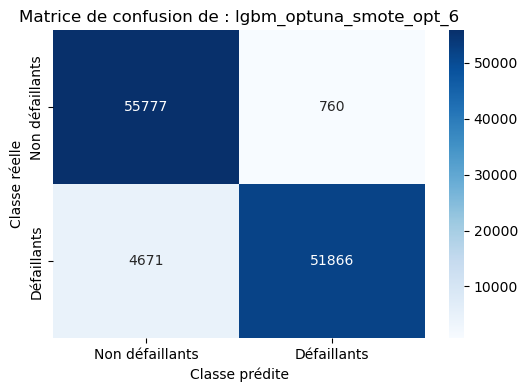

In [93]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_optuna_smote_opt_6,
                                        X_train_smote, X_valid_smote,
                                        y_train_smote, y_valid_smote,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_6')

In [94]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_optuna_smote_opt_6',
                                        4671, 760, 51866, 55777, df_taux)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
20  0.097281   0.317554  0.148936  0.099947   0.097954  0.729359  0.203951   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
20      0.693611    10.940406  11.335533  ...                    0.005252   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
20         0.241569                    0.007505        0.100906   

    Test_recall_CV_plus_minus  Train_precision_CV  \
20                   0.007949            0.654072   

    Train_precision_CV_plus_minus  Test_precision_CV  \
20                       0.007734           0.305343   

    Test_precision_CV_plus_minus                          Model  
20                      0.018145  lgbm_optuna_smote_opt_6_train  

[1 rows x 23 columns]

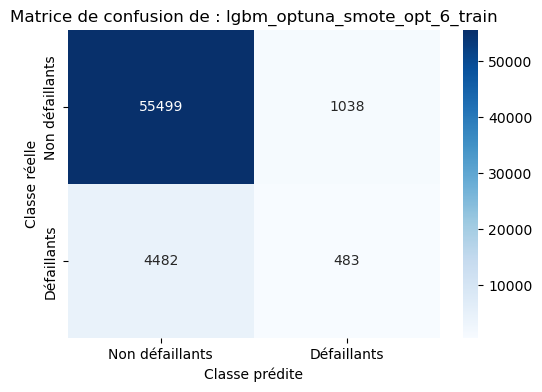

In [95]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_optuna_smote_opt_6,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_6_train')

In [96]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_optuna_smote_opt_6_train',
                                        4482, 1038, 483, 55499, df_taux)

#### <span style='background:Moccasin'>Rééquilibrage - oversampling : SMOTE auto</span>

In [97]:
from collections import Counter

# Répartition des classes au départ
counter_original = Counter(y_train)
print(counter_original)
# Application de l'oversampling via SMOTE avec les paramètres par défaut
oversample = SMOTE(sampling_strategy='auto', k_neighbors=5, n_jobs=-1,
                   random_state=seed)
X_train_smote_1, y_train_smote_1 = \
    oversample.fit_resample(X_train, y_train)
X_valid_smote_1, y_valid_smote_1 = \
    oversample.fit_resample(X_valid, y_valid)
# Répartition après oversampling SMOTE paramètres par défaut
counter_smote_1 = Counter(y_train_smote_1)
print(counter_smote_1)

Counter({0: 226145, 1: 19860})
Counter({0: 226145, 1: 226145})


#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base**</span>

In [98]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_base_1 = LGBMClassifier(random_state=seed, verbose=0,
                                   force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score  ROC AUC    PR AUC  \
21  0.913596    0.99672   0.95335  0.916536   0.914351  0.97962  0.985319   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
21      0.926427    25.828941  26.600116  ...                    0.088778   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
21         0.914631                     0.02799         0.91067   

    Test_recall_CV_plus_minus  Train_precision_CV  \
21                   0.262977            0.996893   

    Train_precision_CV_plus_minus  Test_precision_CV  \
21                       0.001045           0.996607   

    Test_precision_CV_plus_minus              Model  
21                      0.001174  lgbm_smote_base_1  

[1 rows x 23 columns]

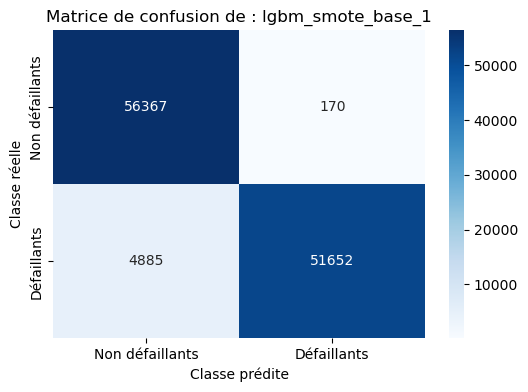

In [99]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_smote_base_1,
                                        X_train_smote_1, X_valid_smote_1,
                                        y_train_smote_1, y_valid_smote_1,
                                        df_resultats,
                                        'lgbm_smote_base_1')

In [100]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_smote_base_1',
                                        4885, 170, 51652, 56367, df_taux)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
22  0.042296   0.578512  0.078829   0.04386   0.042688  0.781519  0.276539   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
22      0.686258     9.248401   9.569677  ...                    0.004946   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
22         0.059483                    0.002252        0.040836   

    Test_recall_CV_plus_minus  Train_precision_CV  \
22                   0.004557            0.763636   

    Train_precision_CV_plus_minus  Test_precision_CV  \
22                       0.006599           0.565895   

    Test_precision_CV_plus_minus                    Model  
22                      0.043276  lgbm_smote_base_1_train  

[1 rows x 23 columns]

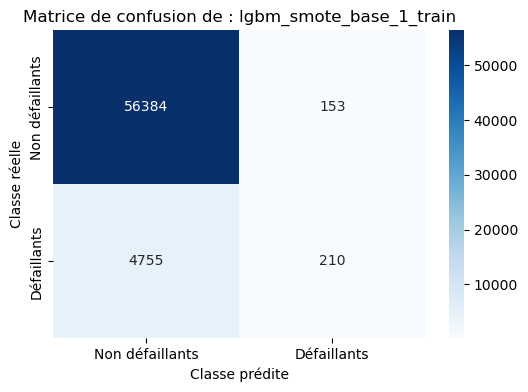

In [101]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_smote_base_1,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_base_1_train')

In [102]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_smote_base_1_train',
                                        4755, 153, 210, 56384, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score ROC_AUC**</span>

In [103]:
# Modèle et hyperparamètres à étudier
def create_model_8(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [104]:
# Objective fonction
def objective_8(trial):
    model = create_model_8(trial)
    model.fit(X_train_smote_1, y_train_smote_1)
    y_proba_smote_1 = model.predict_proba(X_valid_smote_1)[:,1]
    score = roc_auc_score(y_valid_smote_1, y_proba_smote_1)
    return score

In [105]:
# Recherche des paramètres
study_8 = optuna.create_study(direction='maximize')
study_8.optimize(objective_8, n_trials=100)

[I 2024-05-09 15:35:03,871] A new study created in memory with name: no-name-94e330a4-4007-4995-9395-299fde5c8bb0
[I 2024-05-09 15:35:12,033] Trial 0 finished with value: 0.9760850136416572 and parameters: {'max_depth': 3, 'subsample': 0.5345641274195522, 'colsample_bytree': 0.6504399171942064, 'reg_alpha': 2.5722462662303434e-06, 'reg_lambda': 5.2558424586010895e-06, 'num_leaves': 241, 'min_child_weight': 0.9773585538990083, 'subsample_freq': 3, 'min_child_samples': 17}. Best is trial 0 with value: 0.9760850136416572.
[I 2024-05-09 15:35:30,610] Trial 1 finished with value: 0.9785307067136636 and parameters: {'max_depth': 7, 'subsample': 0.1941534271860984, 'colsample_bytree': 0.4593087293233208, 'reg_alpha': 5.04998068984367e-05, 'reg_lambda': 0.0033248149198216626, 'num_leaves': 219, 'min_child_weight': 0.5567215565154058, 'subsample_freq': 6, 'min_child_samples': 55}. Best is trial 1 with value: 0.9785307067136636.
[I 2024-05-09 15:36:08,433] Trial 2 finished with value: 0.97963614

In [106]:
params_8 = study_8.best_params
print(f'Nombre d\'essai terminés : {len(study_8.trials)}')
print('Best hyperparamètres:\n')
print(params_8)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.9994488281687574, 'colsample_bytree': 0.9393847948270955, 'reg_alpha': 2.9982783904254053, 'reg_lambda': 7.576493611498456e-06, 'num_leaves': 131, 'min_child_weight': 0.8709901646915732, 'subsample_freq': 1, 'min_child_samples': 88}


In [107]:
param_lgbm_optuna_opt_8 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,    
                           'colsample_bytree': 0.9393847948270955,
                           'max_depth': 11,
                           'min_child_samples': 88,
                           'min_child_weight': 0.8709901646915732,
                           'num_leaves': 131,
                           'reg_alpha': 2.9982783904254053,
                           'reg_lambda': 7.576493611498456e-06,
                           'subsample': 0.9994488281687574,
                           'subsample_freq': 1,
                           'verbosity' : -1}

In [108]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_8 = LGBMClassifier(**param_lgbm_optuna_opt_8,
                                         force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
23  0.914693   0.995783  0.953517  0.917567   0.915431  0.980069  0.985605   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
23      0.927221     32.55001  33.305237  ...                    0.082617   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
23         0.921345                    0.026108        0.911365   

    Test_recall_CV_plus_minus  Train_precision_CV  \
23                   0.263194            0.997886   

    Train_precision_CV_plus_minus  Test_precision_CV  \
23                       0.000713            0.99539   

    Test_precision_CV_plus_minus                    Model  
23                      0.001602  lgbm_optuna_smote_opt_8  

[1 rows x 23 columns]

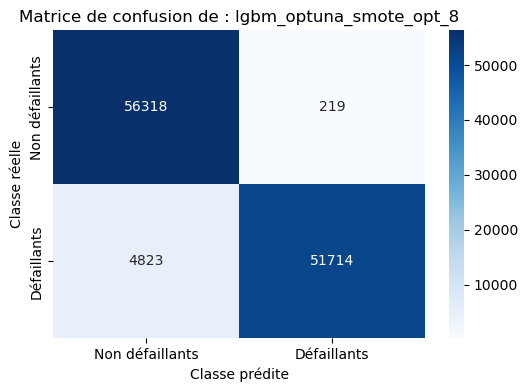

In [109]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_optuna_smote_opt_8,
                                        X_train_smote_1, X_valid_smote_1,
                                        y_train_smote_1, y_valid_smote_1,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_8')

In [110]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_optuna_smote_opt_8',
                                        4823, 219, 51714, 56318, df_taux)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
24  0.055992   0.544031  0.101534  0.057993   0.056494  0.781768  0.275801   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
24      0.689765    17.094382  17.482986  ...                    0.003676   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
24          0.14859                    0.002056        0.049144   

    Test_recall_CV_plus_minus  Train_precision_CV  \
24                   0.005195            0.932745   

    Train_precision_CV_plus_minus  Test_precision_CV  \
24                       0.001882           0.528106   

    Test_precision_CV_plus_minus                          Model  
24                      0.033898  lgbm_optuna_smote_opt_8_train  

[1 rows x 23 columns]

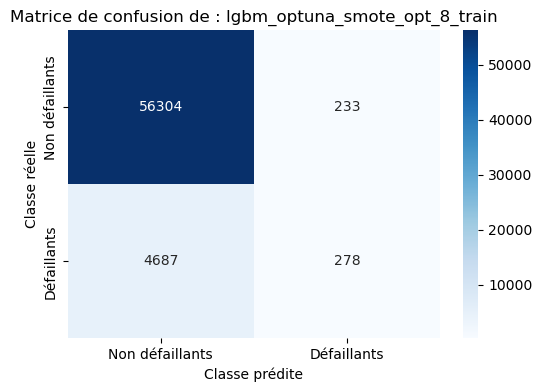

In [111]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_optuna_smote_opt_8,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_8_train')

In [112]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_optuna_smote_opt_8_train',
                                        4687, 233, 278, 56304, df_taux)

#### <span style='background:Moccasin'>Rééquilibrage - combinaison oversampling/undersampling : SMOTE</span>

In [113]:
# Répartition des classes au départ
counter_original = Counter(y_train)
print(counter_original)

# define pipeline
over = SMOTE(sampling_strategy=0.1, random_state=seed)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=seed)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
X_train_smote_combi, y_train_smote_combi = \
    pipeline.fit_resample(X_train, y_train)
X_valid_smote_combi, y_valid_smote_combi = \
    pipeline.fit_resample(X_valid, y_valid)
# Répartition après oversampling SMOTE paramètres par défaut
counter_smote_combi = Counter(y_train_smote_combi)
print(counter_smote_combi)

Counter({0: 226145, 1: 19860})
Counter({0: 45228, 1: 22614})


#### <span style='background:LightGreen'>**Modèle LightGBM - hyperparamètres de base**</span>

In [114]:
# Initialisation du modèle avec les hyperparamètres de base
lgbm_smote_base_2 = LGBMClassifier(random_state=seed, verbose=0,
                                   force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
25  0.49885   0.707299  0.585062  0.504569    0.50031  0.804837  0.708098   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
25      0.604965     4.504401   4.615155  ...                    0.052876   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
25         0.564154                    0.005931        0.495829   

    Test_recall_CV_plus_minus  Train_precision_CV  \
25                    0.13674            0.773663   

    Train_precision_CV_plus_minus  Test_precision_CV  \
25                       0.010619           0.693007   

    Test_precision_CV_plus_minus                  Model  
25                      0.032145  lgbm_smote_combi_base  

[1 rows x 23 columns]

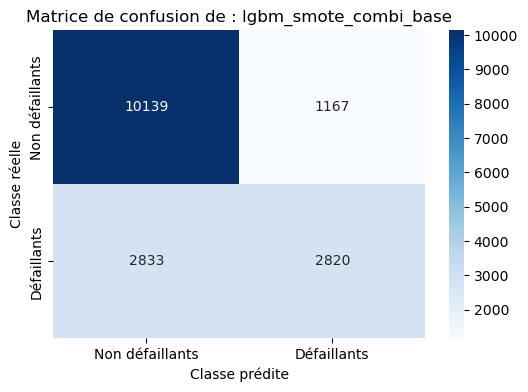

In [115]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_smote_base_2,
                                        X_train_smote_combi,
                                        X_valid_smote_combi,
                                        y_train_smote_combi,
                                        y_valid_smote_combi,
                                        df_resultats,
                                        'lgbm_smote_combi_base')

In [116]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_smote_combi_base',
                                        2833, 1167, 2820, 10139, df_taux)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
26  0.042296   0.578512  0.078829   0.04386   0.042688  0.781519  0.276539   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
26      0.686258    10.651432  10.995544  ...                    0.004946   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
26         0.059483                    0.002252        0.040836   

    Test_recall_CV_plus_minus  Train_precision_CV  \
26                   0.004557            0.763636   

    Train_precision_CV_plus_minus  Test_precision_CV  \
26                       0.006599           0.565895   

    Test_precision_CV_plus_minus                        Model  
26                      0.043276  lgbm_smote_combi_base_train  

[1 rows x 23 columns]

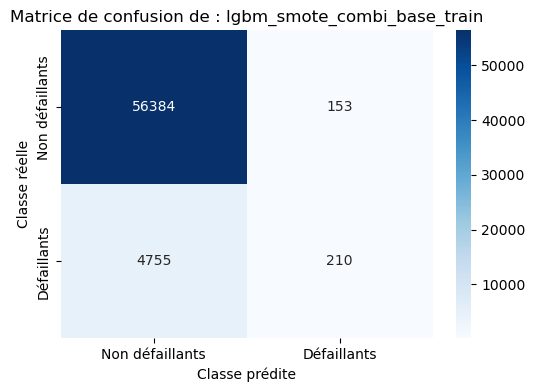

In [117]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_smote_base_2,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_smote_combi_base_train')

In [118]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_smote_combi_base_train',
                                        4755, 153, 210, 56384, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score ROC_AUC**</span>

In [119]:
# Modèle et hyperparamètres à étudier
def create_model_9(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'auc',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [120]:
# Objective fonction
def objective_9(trial):
    model = create_model_9(trial)
    model.fit(X_train_smote_combi, y_train_smote_combi)
    y_proba_smote_combi = model.predict_proba(X_valid_smote_combi)[:,1]
    score = roc_auc_score(y_valid_smote_combi, y_proba_smote_combi)
    return score

In [121]:
# Recherche des paramètres
study_9 = optuna.create_study(direction='maximize')
study_9.optimize(objective_9, n_trials=100)

[I 2024-05-09 20:34:18,378] A new study created in memory with name: no-name-c0d5b84d-4691-4b3b-9957-55ab6eac5876
[I 2024-05-09 20:34:23,318] Trial 0 finished with value: 0.8022558948973272 and parameters: {'max_depth': 11, 'subsample': 0.46082886804018774, 'colsample_bytree': 0.7649137848215803, 'reg_alpha': 0.11196018393859176, 'reg_lambda': 0.1475096790419365, 'num_leaves': 45, 'min_child_weight': 0.9980438129393032, 'subsample_freq': 5, 'min_child_samples': 47}. Best is trial 0 with value: 0.8022558948973272.
[I 2024-05-09 20:34:28,450] Trial 1 finished with value: 0.7961715911196405 and parameters: {'max_depth': 8, 'subsample': 0.4310657057760262, 'colsample_bytree': 0.691963023744765, 'reg_alpha': 0.0007730427706786968, 'reg_lambda': 2.89873586501977e-07, 'num_leaves': 245, 'min_child_weight': 0.6239258084562488, 'subsample_freq': 1, 'min_child_samples': 19}. Best is trial 0 with value: 0.8022558948973272.
[I 2024-05-09 20:34:30,188] Trial 2 finished with value: 0.799097107562993

In [122]:
params_9 = study_9.best_params
print(f'Nombre d\'essai terminés : {len(study_9.trials)}')
print('Best hyperparamètres:\n')
print(params_9)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 10, 'subsample': 0.8354137779336732, 'colsample_bytree': 0.7935632187481536, 'reg_alpha': 2.5057534791338143e-07, 'reg_lambda': 1.9490079332441526, 'num_leaves': 64, 'min_child_weight': 0.544980551691143, 'subsample_freq': 3, 'min_child_samples': 38}


In [123]:
param_lgbm_optuna_opt_9 = {'objective' : 'binary',
                           'boosting_type' : 'gbdt',
                           'n_jobs' : -1,    
                           'colsample_bytree': 0.7935632187481536,
                           'max_depth': 10,
                           'min_child_samples': 38,
                           'min_child_weight': 0.544980551691143,
                           'num_leaves': 64,
                           'reg_alpha': 2.5057534791338143e-07,
                           'reg_lambda': 1.9490079332441526,
                           'subsample': 0.8354137779336732,
                           'subsample_freq': 3,
                           'verbosity' : -1}

In [124]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_9 = LGBMClassifier(**param_lgbm_optuna_opt_9,
                                         force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
27  0.506103   0.698828  0.587052  0.511529   0.507489  0.803503  0.702499   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
27      0.608727     6.475328   6.567348  ...                    0.050828   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
27         0.621169                     0.00501        0.500074   

    Test_recall_CV_plus_minus  Train_precision_CV  \
27                   0.132848            0.824294   

    Train_precision_CV_plus_minus  Test_precision_CV  \
27                       0.009152           0.687082   

    Test_precision_CV_plus_minus                    Model  
27                      0.030795  lgbm_optuna_smote_opt_9  

[1 rows x 23 columns]

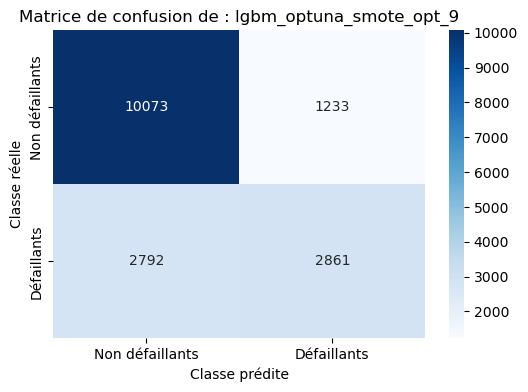

In [125]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_optuna_smote_opt_9,
                                        X_train_smote_combi,
                                        X_valid_smote_combi,
                                        y_train_smote_combi,
                                        y_valid_smote_combi,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_9')

In [126]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_optuna_smote_opt_9',
                                        2792, 1233, 2861, 10073, df_taux)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC   PR AUC  \
28  0.050151   0.575058  0.092256  0.051976   0.050608  0.781591  0.27632   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
28      0.688447    13.080277   13.38887  ...                    0.004549   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
28         0.090965                    0.001766        0.046375   

    Test_recall_CV_plus_minus  Train_precision_CV  \
28                   0.003818            0.836887   

    Train_precision_CV_plus_minus  Test_precision_CV  \
28                       0.005347           0.540644   

    Test_precision_CV_plus_minus                          Model  
28                      0.030474  lgbm_optuna_smote_opt_9_train  

[1 rows x 23 columns]

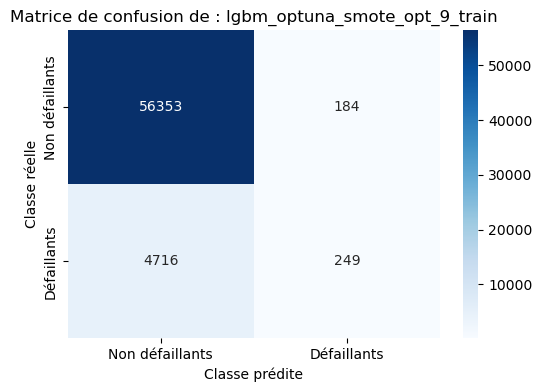

In [127]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_optuna_smote_opt_9,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_9_train')

In [128]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_optuna_smote_opt_9_train',
                                        4716, 184, 249, 56353, df_taux)

#### <span style='background:LightGreen'>**Optimisation des hyperparamètres - optuna - score F10**</span>

In [129]:
# Modèle et hyperparamètres à étudier
def create_model_10(trial):
    max_depth = trial.suggest_int('max_depth', 3, 11)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
    reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
    num_leaves = trial.suggest_int('num_leaves', 2, 256),
    min_child_weight = trial.suggest_uniform('min_child_weight', 0.4, 1.0),
    subsample_freq = trial.suggest_int('subsample_freq', 1, 7),
    min_child_samples = trial.suggest_int('min_child_samples', 5, 100),
            
    model = LGBMClassifier(
        objective = 'binary',
        metric = 'f10_score',
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        num_leaves=num_leaves,
        min_child_weight=min_child_weight,
        subsample=subsample,
        subsample_freq=subsample_freq,
        min_child_samples=min_child_samples,
        random_state=seed,
        verbose=-1)
        
    return model

In [130]:
# Objective fonction
def objective_10(trial):
    model = create_model_10(trial)
    model.fit(X_train_smote_combi, y_train_smote_combi)
    y_pred_smote_combi = model.predict(X_valid_smote_combi)
    score = fbeta_score(y_valid_smote_combi, y_pred_smote_combi, beta = 10)
    return score

In [131]:
# Recherche des paramètres
study_10 = optuna.create_study(direction='maximize')
study_10.optimize(objective_10, n_trials=100)

[I 2024-05-09 20:53:48,915] A new study created in memory with name: no-name-27ddeb43-5fb8-4ab1-815f-a585bb71462f
[I 2024-05-09 20:53:58,275] Trial 0 finished with value: 0.5023587142460719 and parameters: {'max_depth': 9, 'subsample': 0.9160579806522947, 'colsample_bytree': 0.9939743280258999, 'reg_alpha': 1.0846209652829003e-05, 'reg_lambda': 1.0919625716358389e-07, 'num_leaves': 202, 'min_child_weight': 0.9118397978558664, 'subsample_freq': 1, 'min_child_samples': 45}. Best is trial 0 with value: 0.5023587142460719.
[I 2024-05-09 20:54:02,015] Trial 1 finished with value: 0.49788907270230304 and parameters: {'max_depth': 8, 'subsample': 0.23870385709863606, 'colsample_bytree': 0.774300179426394, 'reg_alpha': 4.956727161517226e-06, 'reg_lambda': 0.19024672839103163, 'num_leaves': 57, 'min_child_weight': 0.9929071734908809, 'subsample_freq': 6, 'min_child_samples': 39}. Best is trial 0 with value: 0.5023587142460719.
[I 2024-05-09 20:54:04,863] Trial 2 finished with value: 0.492869865

In [132]:
params_10 = study_10.best_params
print(f'Nombre d\'essai terminés : {len(study_10.trials)}')
print('Best hyperparamètres:\n')
print(params_10)

Nombre d'essai terminés : 100
Best hyperparamètres:

{'max_depth': 11, 'subsample': 0.23168927943413736, 'colsample_bytree': 0.9463842854609341, 'reg_alpha': 0.0013012415102628112, 'reg_lambda': 5.204987897338694e-06, 'num_leaves': 218, 'min_child_weight': 0.44251114773996236, 'subsample_freq': 7, 'min_child_samples': 91}


In [133]:
param_lgbm_optuna_opt_10 = {'objective' : 'binary',
                            'boosting_type' : 'gbdt',
                            'n_jobs' : -1,    
                            'colsample_bytree': 0.9463842854609341,
                            'max_depth': 11,
                            'min_child_samples': 91,
                            'min_child_weight': 0.44251114773996236,
                            'num_leaves': 218,
                            'reg_alpha': 0.0013012415102628112,
                            'reg_lambda': 5.204987897338694e-06,
                            'subsample': 0.23168927943413736,
                            'subsample_freq': 7,
                            'verbosity' : -1}

In [134]:
# Initialisation du modèle avec les hyperparamètres précédemment trouvés
lgbm_optuna_smote_opt_10 = LGBMClassifier(**param_lgbm_optuna_opt_10,
                                          force_col_wise=True)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
29  0.503449   0.671702  0.575531  0.508347   0.504701  0.789365  0.678281   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
29      0.603054     4.805032   4.899562  ...                    0.023528   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
29         0.611794                    0.006676        0.479122   

    Test_recall_CV_plus_minus  Train_precision_CV  \
29                   0.053553            0.786394   

    Train_precision_CV_plus_minus  Test_precision_CV  \
29                       0.010604           0.655376   

    Test_precision_CV_plus_minus                     Model  
29                      0.015765  lgbm_optuna_smote_opt_10  

[1 rows x 23 columns]

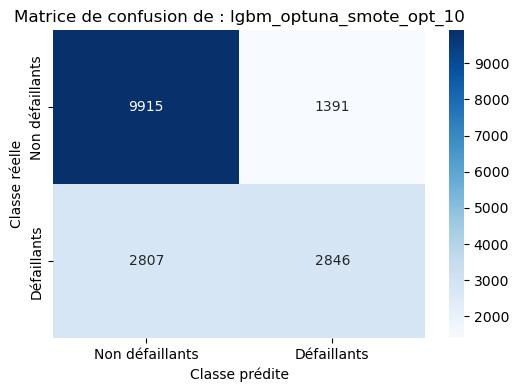

In [135]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_optuna_smote_opt_10,
                                        X_train_smote_combi,
                                        X_valid_smote_combi,
                                        y_train_smote_combi,
                                        y_valid_smote_combi,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_10')

In [136]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_optuna_smote_opt_10',
                                        2807, 1391, 2846, 9915, df_taux)

Recall  Precision  F1 Score  F5 Score  F10 Score   ROC AUC    PR AUC  \
30  0.071702   0.447236   0.12359  0.074095   0.072303  0.758984  0.245497   

    Metier_score  Durée_train  Durée_tot  ...  Test_roc_auc_CV_plus_minus  \
30      0.692413    12.604146  12.958745  ...                    0.004516   

    Train_recall_CV  Train_recall_CV_plus_minus  Test_recall_CV  \
30         0.159237                    0.003589        0.069738   

    Test_recall_CV_plus_minus  Train_precision_CV  \
30                   0.006624            0.795217   

    Train_precision_CV_plus_minus  Test_precision_CV  \
30                       0.010668           0.439336   

    Test_precision_CV_plus_minus                           Model  
30                      0.036771  lgbm_optuna_smote_opt_10_train  

[1 rows x 23 columns]

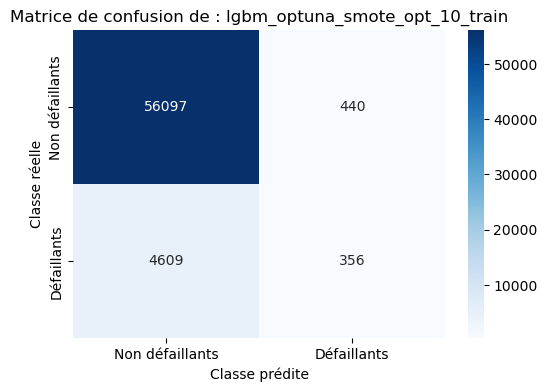

In [137]:
# Entraînement, prédictions, scoring sur le jeu d'entraînement
df_resultats = process_classification(lgbm_optuna_smote_opt_10,
                                        X_train, X_valid,
                                        y_train, y_valid,
                                        df_resultats,
                                        'lgbm_optuna_smote_opt_10_train')

In [138]:
# Sauvegarde
df_taux = sauvegarder_taux('lgbm_optuna_smote_opt_10_train',
                                        4609, 440, 356, 56097, df_taux)

### <span style='background:PowderBlue'>Bilan - Modélisations</span>

**Les différents taux des matrices de confusion**

In [139]:
df_taux_comp1 = df_taux.sort_values(by='Modèle')

In [140]:
df_taux_comp1

Modèle    FN     FP     TP     TN
0               lgbm_hyperparam_base  4755    153    210  56384
1           lgbm_hyperparam_base_bal  1570  15032   3395  41505
4        lgbm_hyperparam_base_minmax  4746    157    219  56380
5        lgbm_hyperparam_base_robust  4750    147    215  56390
2           lgbm_hyperparam_base_std  4766    173    199  56364
3       lgbm_hyperparam_base_std_bal  1516  15054   3449  41483
6                  lgbm_optuna_opt_1  1679  13545   3286  42992
7                  lgbm_optuna_opt_2  1765  12513   3200  44024
8                  lgbm_optuna_opt_3  2197   9816   2768  46721
9                  lgbm_optuna_opt_4  1562  14871   3403  41666
10                 lgbm_optuna_opt_5  1471  15908   3494  40629
11                lgbm_optuna_opt_F1  2265   9332   2700  47205
12                lgbm_optuna_opt_F5  1483  16198   3482  40339
29          lgbm_optuna_smote_opt_10  2807   1391   2846   9915
30    lgbm_optuna_smote_opt_10_train  4609    440    356  56097
19           lgbm_optuna_smote_opt_6  4671    760  51866  55777
20     lgbm_optuna_smote_opt_6_train  4482   1038    483  55499
17           lgbm_optuna_smote_opt_7  4837    206  51700  56331
18     lgbm_optuna_smote_opt_7_train  4706    227    259  56310
23           lgbm_optuna_smote_opt_8  4823    219  51714  56318
24     lgbm_optuna_smote_opt_8_train  4687    233    278  56304
27           lgbm_optuna_smote_opt_9  2792   1233   2861  10073
28     lgbm_optuna_smote_opt_9_train  4716    184    249  56353
21                 lgbm_smote_base_1  4885    170  51652  56367
22           lgbm_smote_base_1_train  4755    153    210  56384
15               lgbm_smote_base_bal  4899    172  51638  56365
16         lgbm_smote_base_bal_train  1570  15032   3395  41505
25             lgbm_smote_combi_base  2833   1167   2820  10139
26       lgbm_smote_combi_base_train  4755    153    210  56384
13        lgbm_smote_hyperparam_base  4899    172  51638  56365
14  lgbm_smote_hyperparam_base_train  4755    153    210  56384

In [141]:
modeles = ['lgbm_hyperparam_base', 
           'lgbm_hyperparam_base_bal',
           'lgbm_hyperparam_base_minmax', 
           'lgbm_hyperparam_base_robust',
           'lgbm_hyperparam_base_std', 
           'lgbm_hyperparam_base_std_bal',
           'lgbm_optuna_opt_1', 
           'lgbm_optuna_opt_2', 
           'lgbm_optuna_opt_3',
           'lgbm_optuna_opt_4', 
           'lgbm_optuna_opt_5',
           'lgbm_optuna_opt_F1', 
           'lgbm_optuna_opt_F5',
           'lgbm_optuna_smote_opt_10', 
           'lgbm_optuna_smote_opt_10_train',
           'lgbm_optuna_smote_opt_6', 
           'lgbm_optuna_smote_opt_6_train',
           'lgbm_optuna_smote_opt_7',
           'lgbm_optuna_smote_opt_7_train',
           'lgbm_optuna_smote_opt_8', 
           'lgbm_optuna_smote_opt_8_train',
           'lgbm_optuna_smote_opt_9', 
           'lgbm_optuna_smote_opt_9_train',
           'lgbm_smote_base_1', 
           'lgbm_smote_base_1_train',
           'lgbm_smote_base_bal', 
           'lgbm_smote_base_bal_train',
           'lgbm_smote_combi_base', 
           'lgbm_smote_combi_base_train',
           'lgbm_smote_hyperparam_base',
           'lgbm_smote_hyperparam_base_train']

print(len(modeles))

31


In [142]:
jeu_donnees = ['train', 
               'train',
               'train', 
               'train', 
               'train', 
               'train', 
               'train', 
               'train', 
               'train', 
               'train',
               'train', 
               'train', 
               'train', 
               'reduit',
               'train', 
               'augmente', 
               'train', 
               'augmente', 
               'train',
               'augmente',
               'train', 
               'reduit', 
               'train', 
               'augmente', 
               'train', 
               'augmente', 
               'train', 
               'reduit', 
               'train', 
               'augmente', 
               'train']
print(len(jeu_donnees))

31


In [143]:
df_taux_comp2 = pd.DataFrame({'Modèle' : modeles,
                              'Jeu_donnees' : jeu_donnees})

In [144]:
# Dataframe de sauvegarde des taux des différentes modélisations
df_taux_comp = df_taux_comp2.merge(df_taux_comp1, on='Modèle',
                                   how='right')
df_taux_comp

Modèle Jeu_donnees    FN     FP     TP     TN
0               lgbm_hyperparam_base       train  4755    153    210  56384
1           lgbm_hyperparam_base_bal       train  1570  15032   3395  41505
2        lgbm_hyperparam_base_minmax       train  4746    157    219  56380
3        lgbm_hyperparam_base_robust       train  4750    147    215  56390
4           lgbm_hyperparam_base_std       train  4766    173    199  56364
5       lgbm_hyperparam_base_std_bal       train  1516  15054   3449  41483
6                  lgbm_optuna_opt_1       train  1679  13545   3286  42992
7                  lgbm_optuna_opt_2       train  1765  12513   3200  44024
8                  lgbm_optuna_opt_3       train  2197   9816   2768  46721
9                  lgbm_optuna_opt_4       train  1562  14871   3403  41666
10                 lgbm_optuna_opt_5       train  1471  15908   3494  40629
11                lgbm_optuna_opt_F1       train  2265   9332   2700  47205
12                lgbm_optuna_opt_F5       train  1483  16198   3482  40339
13          lgbm_optuna_smote_opt_10      reduit  2807   1391   2846   9915
14    lgbm_optuna_smote_opt_10_train       train  4609    440    356  56097
15           lgbm_optuna_smote_opt_6    augmente  4671    760  51866  55777
16     lgbm_optuna_smote_opt_6_train       train  4482   1038    483  55499
17           lgbm_optuna_smote_opt_7    augmente  4837    206  51700  56331
18     lgbm_optuna_smote_opt_7_train       train  4706    227    259  56310
19           lgbm_optuna_smote_opt_8    augmente  4823    219  51714  56318
20     lgbm_optuna_smote_opt_8_train       train  4687    233    278  56304
21           lgbm_optuna_smote_opt_9      reduit  2792   1233   2861  10073
22     lgbm_optuna_smote_opt_9_train       train  4716    184    249  56353
23                 lgbm_smote_base_1    augmente  4885    170  51652  56367
24           lgbm_smote_base_1_train       train  4755    153    210  56384
25               lgbm_smote_base_bal    augmente  4899    172  51638  56365
26         lgbm_smote_base_bal_train       train  1570  15032   3395  41505
27             lgbm_smote_combi_base      reduit  2833   1167   2820  10139
28       lgbm_smote_combi_base_train       train  4755    153    210  56384
29        lgbm_smote_hyperparam_base    augmente  4899    172  51638  56365
30  lgbm_smote_hyperparam_base_train       train  4755    153    210  56384

In [145]:
# Tri par Faux Négatifs décroissant (les clients prédits non défaillants
# qui sont défaillants ==> la banque perd le montant du prêt en totalité
# ou en partie) pour le train set
mask = df_taux_comp['Jeu_donnees'] == 'train'
df_taux_comp[mask].sort_values(by='FN').style.highlight_min(subset=['FN', 'FP', 'TN', 'TP'], color='lightgreen', axis=0)

**Constitution des dataframes de comparaison pour les résultats**

In [154]:
df_resultats_comp1 = df_resultats.sort_values(by='Modèle')

In [156]:
df_resultats_comp1

Modèle    Recall  Precision  F1 Score  F5 Score  \
0               lgbm_hyperparam_base  0.042296   0.578512  0.078829  0.043860   
1           lgbm_hyperparam_base_bal  0.683787   0.184241  0.290270  0.619213   
4        lgbm_hyperparam_base_minmax  0.044109   0.582447  0.082007  0.045735   
5        lgbm_hyperparam_base_robust  0.043303   0.593923  0.080721  0.044904   
2           lgbm_hyperparam_base_std  0.040081   0.534946  0.074574  0.041559   
3       lgbm_hyperparam_base_std_bal  0.694663   0.186402  0.293932  0.628726   
6                  lgbm_optuna_opt_1  0.661833   0.195235  0.301523  0.606118   
7                  lgbm_optuna_opt_2  0.644512   0.203653  0.309508  0.594974   
8                  lgbm_optuna_opt_3  0.557503   0.219962  0.315460  0.526432   
9                  lgbm_optuna_opt_4  0.685398   0.186221  0.292870  0.621339   
10                 lgbm_optuna_opt_5  0.703726   0.180085  0.286781  0.632940   
11                lgbm_optuna_opt_F1  0.543807   0.224402  0.317703  0.515581   
12                lgbm_optuna_opt_F5  0.701309   0.176931  0.282573  0.629547   
29          lgbm_optuna_smote_opt_10  0.503449   0.671702  0.575531  0.508347   
30    lgbm_optuna_smote_opt_10_train  0.071702   0.447236  0.123590  0.074095   
19           lgbm_optuna_smote_opt_6  0.917382   0.985558  0.950249  0.919829   
20     lgbm_optuna_smote_opt_6_train  0.097281   0.317554  0.148936  0.099947   
17           lgbm_optuna_smote_opt_7  0.914445   0.996031  0.953496  0.917335   
18     lgbm_optuna_smote_opt_7_train  0.052165   0.532922  0.095028  0.054040   
23           lgbm_optuna_smote_opt_8  0.914693   0.995783  0.953517  0.917567   
24     lgbm_optuna_smote_opt_8_train  0.055992   0.544031  0.101534  0.057993   
27           lgbm_optuna_smote_opt_9  0.506103   0.698828  0.587052  0.511529   
28     lgbm_optuna_smote_opt_9_train  0.050151   0.575058  0.092256  0.051976   
21                 lgbm_smote_base_1  0.913596   0.996720  0.953350  0.916536   
22           lgbm_smote_base_1_train  0.042296   0.578512  0.078829  0.043860   
15               lgbm_smote_base_bal  0.913349   0.996680  0.953197  0.916295   
16         lgbm_smote_base_bal_train  0.683787   0.184241  0.290270  0.619213   
25             lgbm_smote_combi_base  0.498850   0.707299  0.585062  0.504569   
26       lgbm_smote_combi_base_train  0.042296   0.578512  0.078829  0.043860   
13        lgbm_smote_hyperparam_base  0.913349   0.996680  0.953197  0.916295   
14  lgbm_smote_hyperparam_base_train  0.042296   0.578512  0.078829  0.043860   

    F10 Score   ROC AUC    PR AUC  Metier_score  Durée_train  ...  \
0    0.042688  0.781519  0.276539      0.686258    10.915008  ...   
1    0.665910  0.783201  0.280375      0.717727    11.996595  ...   
4    0.044516  0.781830  0.275042      0.686801     9.468337  ...   
5    0.043704  0.782081  0.278269      0.686658    10.401769  ...   
2    0.040451  0.781908  0.275066      0.685298    13.183495  ...   
3    0.676402  0.784745  0.281211      0.721007    12.048170  ...   
6    0.646534  0.783573  0.278839      0.728313     7.834742  ...   
7    0.630987  0.787229  0.285318      0.734980    54.087094  ...   
8    0.549159  0.776820  0.269833      0.738808    19.993802  ...   
9    0.667677  0.782982  0.277108      0.720172    15.487197  ...   
10   0.684033  0.780131  0.271803      0.713774     7.075671  ...   
11   0.536249  0.773951  0.265840      0.740120    20.169611  ...   
12   0.681317  0.777379  0.270662      0.709528     5.050652  ...   
29   0.504701  0.789365  0.678281      0.603054     4.805032  ...   
30   0.072303  0.758984  0.245497      0.692413    12.604146  ...   
19   0.918010  0.976732  0.983593      0.928024    25.517595  ...   
20   0.097954  0.729359  0.203951      0.693611    10.940406  ...   
17   0.915188  0.980000  0.985547      0.927047    28.833652  ...   
18   0.052635  0.784147  0.277895      0.688590    17.082819  ...   
23   0.915431  0.980069  0.985605      0.927221    32.550

In [155]:
modeles

['lgbm_hyperparam_base',
 'lgbm_hyperparam_base_bal',
 'lgbm_hyperparam_base_minmax',
 'lgbm_hyperparam_base_robust',
 'lgbm_hyperparam_base_std',
 'lgbm_hyperparam_base_std_bal',
 'lgbm_optuna_opt_1',
 'lgbm_optuna_opt_2',
 'lgbm_optuna_opt_3',
 'lgbm_optuna_opt_4',
 'lgbm_optuna_opt_5',
 'lgbm_optuna_opt_F1',
 'lgbm_optuna_opt_F5',
 'lgbm_optuna_smote_opt_10',
 'lgbm_optuna_smote_opt_10_train',
 'lgbm_optuna_smote_opt_6',
 'lgbm_optuna_smote_opt_6_train',
 'lgbm_optuna_smote_opt_7',
 'lgbm_optuna_smote_opt_7_train',
 'lgbm_optuna_smote_opt_8',
 'lgbm_optuna_smote_opt_8_train',
 'lgbm_optuna_smote_opt_9',
 'lgbm_optuna_smote_opt_9_train',
 'lgbm_smote_base_1',
 'lgbm_smote_base_1_train',
 'lgbm_smote_base_bal',
 'lgbm_smote_base_bal_train',
 'lgbm_smote_combi_base',
 'lgbm_smote_combi_base_train',
 'lgbm_smote_hyperparam_base',
 'lgbm_smote_hyperparam_base_train']

In [157]:
metrique = ['logloss', 'logloss', 'logloss', 'logloss', 'logloss',  'logloss', 'roc_auc', 'roc_auc', 'custom', 'pr_auc', 
            'F10', 'F1', 'F5', 'F10', 'F10', 'F10', 'F10', 'roc_auc', 'roc_auc', 'roc_auc', 
            'roc_auc', 'roc_auc', 'roc_auc', 'logloss', 'logloss', 'logloss', 'logloss', 
            'logloss',
            'logloss', 'logloss', 'logloss']

optimisation = ['aucune', 'aucune', 'minmax', 'robust', 'std', 'std', 'optuna', 'optuna', 'optuna', 'optuna', 
                'optuna', 'optuna', 'optuna', 'optuna', 'optuna', 'optuna', 'optuna', 'optuna', 'optuna', 'optuna', 
                'optuna', 'optuna', 'optuna','smoteover', 'smoteover', 'smoteover', 'smoteover', 
                'smoteoverunder', 'smoteoverunder',
                'smoteover', 'smoteover']

class_weight = ['non', 'oui', 'non', 'non', 'non', 'oui', 'oui', 'oui', 'oui', 'oui', 
                'oui', 'oui', 'non', 'non', 'non', 'non', 'non', 'non', 'non', 'non', 
                'non', 'non', 'non', 'non', 'non', 'non', 'non', 
                'non', 'non', 'non', 'non']

print(len(metrique), len(optimisation), len(class_weight))

31 31 31


In [158]:
df_resultats_comp2 = pd.DataFrame({'Modèle' : modeles,
                                   'Metrique' : metrique,
                                   'Optimisation' : optimisation,
                                   'Class_weight' : class_weight})

In [159]:
# Dataframe de sauvegarde des résultats de la modélisation
df_resultats_comp = df_resultats_comp2.merge(df_resultats_comp1, on='Modèle', how='left')

In [160]:
# Dataframe de recueil de tous les résultats
df_comparaison = df_taux_comp.merge(df_resultats_comp, on='Modèle', how='left')

In [161]:
df_comparaison

Modèle Jeu_donnees    FN     FP     TP     TN  \
0               lgbm_hyperparam_base       train  4755    153    210  56384   
1           lgbm_hyperparam_base_bal       train  1570  15032   3395  41505   
2        lgbm_hyperparam_base_minmax       train  4746    157    219  56380   
3        lgbm_hyperparam_base_robust       train  4750    147    215  56390   
4           lgbm_hyperparam_base_std       train  4766    173    199  56364   
5       lgbm_hyperparam_base_std_bal       train  1516  15054   3449  41483   
6                  lgbm_optuna_opt_1       train  1679  13545   3286  42992   
7                  lgbm_optuna_opt_2       train  1765  12513   3200  44024   
8                  lgbm_optuna_opt_3       train  2197   9816   2768  46721   
9                  lgbm_optuna_opt_4       train  1562  14871   3403  41666   
10                 lgbm_optuna_opt_5       train  1471  15908   3494  40629   
11                lgbm_optuna_opt_F1       train  2265   9332   2700  47205   
12                lgbm_optuna_opt_F5       train  1483  16198   3482  40339   
13          lgbm_optuna_smote_opt_10      reduit  2807   1391   2846   9915   
14    lgbm_optuna_smote_opt_10_train       train  4609    440    356  56097   
15           lgbm_optuna_smote_opt_6    augmente  4671    760  51866  55777   
16     lgbm_optuna_smote_opt_6_train       train  4482   1038    483  55499   
17           lgbm_optuna_smote_opt_7    augmente  4837    206  51700  56331   
18     lgbm_optuna_smote_opt_7_train       train  4706    227    259  56310   
19           lgbm_optuna_smote_opt_8    augmente  4823    219  51714  56318   
20     lgbm_optuna_smote_opt_8_train       train  4687    233    278  56304   
21           lgbm_optuna_smote_opt_9      reduit  2792   1233   2861  10073   
22     lgbm_optuna_smote_opt_9_train       train  4716    184    249  56353   
23                 lgbm_smote_base_1    augmente  4885    170  51652  56367   
24           lgbm_smote_base_1_train       train  4755    153    210  56384   
25               lgbm_smote_base_bal    augmente  4899    172  51638  56365   
26         lgbm_smote_base_bal_train       train  1570  15032   3395  41505   
27             lgbm_smote_combi_base      reduit  2833   1167   2820  10139   
28       lgbm_smote_combi_base_train       train  4755    153    210  56384   
29        lgbm_smote_hyperparam_base    augmente  4899    172  51638  56365   
30  lgbm_smote_hyperparam_base_train       train  4755    153    210  56384   

   Metrique    Optimisation Class_weight    Recall  ...  Test_roc_auc_CV  \
0   logloss          aucune          non  0.042296  ...         0.784181   
1   logloss          aucune          oui  0.683787  ...         0.785470   
2   logloss          minmax          non  0.044109  ...         0.783862   
3   logloss          robust          non  0.043303  ...         0.783716   
4   logloss             std          non  0.040081  ...         0.783472   
5   logloss             std          oui  0.694663  ...         0.785640   
6   roc_auc          optuna          oui  0.661833  ...         0.785764   
7   roc_auc          optuna          oui  0.644512  ...         0.788306   
8    custom          optuna          oui  0.557503  ...         0.775636   
9    pr_auc          optuna          oui  0.685398  ...         0.785741   
10      F10          optuna          oui  0.703726  ...         0.782520   
11       F1          optuna          oui  0.543807  ...         0.775487   
12       F5          optuna          non  0.701309  ...         0.778431   
13      F10          optuna          non  0.503449  ...         0.777785   
14      F10          optuna          non  0.071702  ...         0.759330   
15      F10          optuna          non  0.917382  ...         0.973104   
16      F10          optuna          non  0.097281  ...         0.722045   
17  roc_auc          optuna          non  0.914445  ...         0.971659   
18  roc_auc          optuna          non  0.052165  ...  

In [162]:
# Les vraies répartition de la TARGET dans le jeu de validation
Counter(y_valid)

Counter({0: 56537, 1: 4965})

- Nombre de vrais non-défaillants : 56537 (TN).
- Nombre de vrais défaillants : 4965 (TP).

In [163]:
df_comp = df_comparaison.sort_values(by='FN')
df_comp.style.highlight_min(subset=['FN', 'FP', 'TN', 'TP'], color='lightgreen', axis=0)

In [164]:
df_comp.head(4).style.highlight_min(subset=['FN', 'FP', 'TN', 'TP'], color='lightgreen', axis=0)

**Bilan des taux FN, FP, TN et TP**

Modèle Metrique Optimisation Class_weight
10             lgbm_optuna_opt_5      F10       optuna          oui
12            lgbm_optuna_opt_F5       F5       optuna          non
5   lgbm_hyperparam_base_std_bal  logloss          std          oui
9              lgbm_optuna_opt_4   pr_auc       optuna          oui

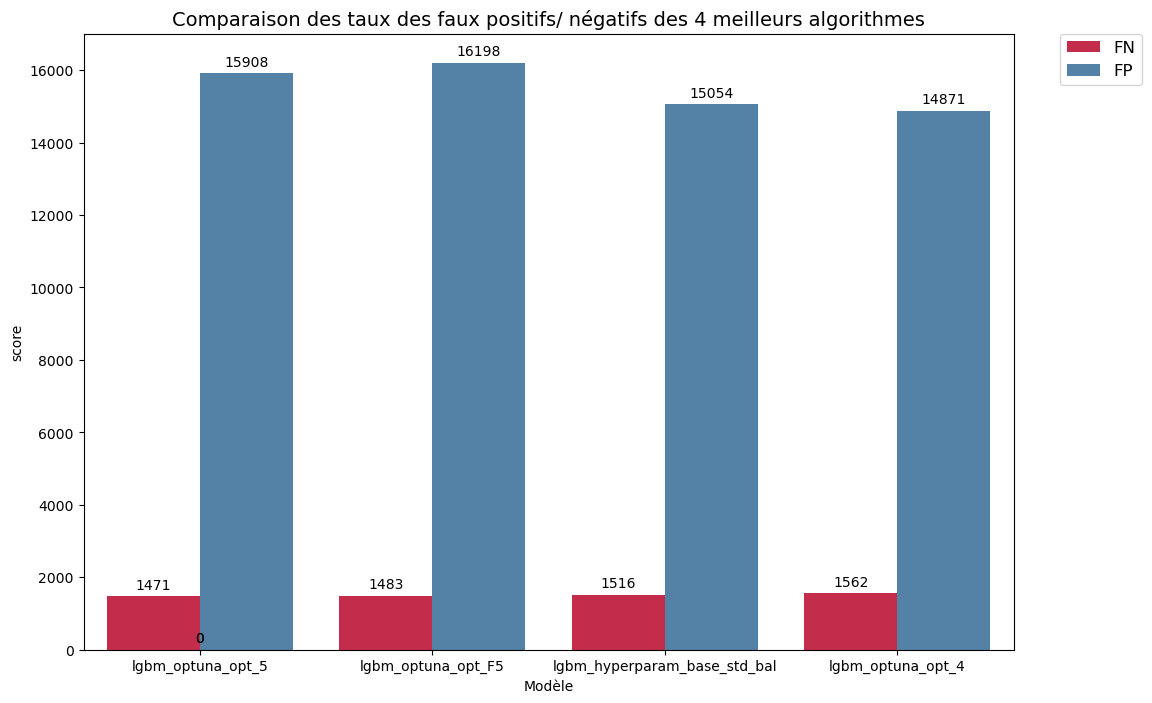

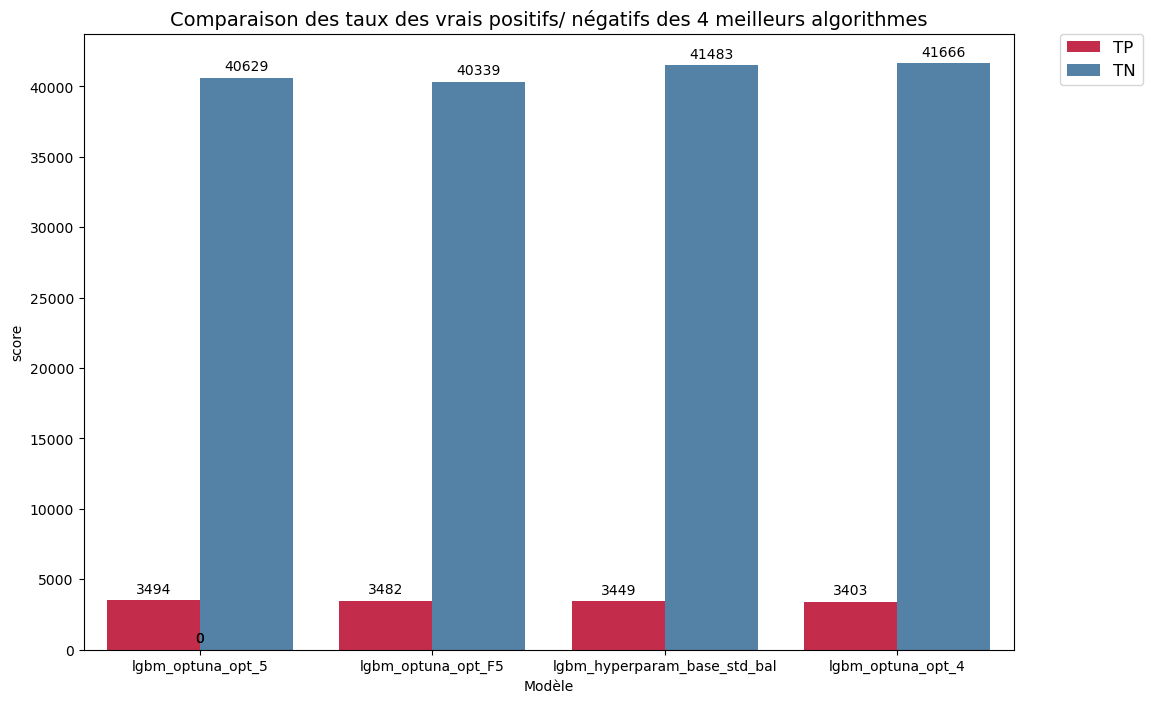

In [165]:
# Comparaison visuelle des 4 algorithmes les plus performants
df_comp_best = df_comp[df_comp['Modèle'].isin(
    ['lgbm_optuna_opt_5', 'lgbm_optuna_opt_F5',
     'lgbm_hyperparam_base_std_bal', 'lgbm_optuna_opt_4'])]

# Renseignements sur les modèles
df_comp_display = df_comp_best[['Modèle', 'Metrique', 'Optimisation',
                               'Class_weight']]
display(df_comp_display)

# Faux négatifs/Faux positifs
comparaison_taux_melt_false = \
    pd.melt(df_comp_best, id_vars=['Modèle'], value_name='score',
            value_vars=['FN', 'FP'])
# Visualisation
plt.figure(figsize=(12, 8))
ax= sns.barplot(x=comparaison_taux_melt_false['Modèle'],
                y=comparaison_taux_melt_false['score'],
            hue=comparaison_taux_melt_false['variable'],
            palette=['Crimson', 'SteelBlue', 'Crimson', 'SteelBlue'])
plt.title('Comparaison des taux des faux positifs/ négatifs des 4 meilleurs algorithmes', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 200,
            int(height),
            ha="center") 
plt.show()

# Vrais négatifs/Vrais positifs
comparaison_taux_melt_true = \
    pd.melt(df_comp_best, id_vars=['Modèle'], value_name='score',
            value_vars=['TP', 'TN'])
# Visualisation
plt.figure(figsize=(12, 8))
total = float(len(comparaison_taux_melt_true))
ax = sns.barplot(x=comparaison_taux_melt_true['Modèle'],
                 y=comparaison_taux_melt_true['score'],
                 hue=comparaison_taux_melt_true['variable'],
                 palette=['Crimson', 'SteelBlue', 'Crimson', 'SteelBlue'])
plt.title('Comparaison des taux des vrais positifs/ négatifs des 4 meilleurs algorithmes', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 500,
            int(height),
            ha="center") 
plt.show()

**Bilan** :
***
- Le modèle **lgbm_optuna_opt_5** (LightGBM class_weight='balanced' avec une optimisation bayésienne, la métrique F10-score) détecte :
    - le moins de faux négatifs (des clients détectés non défaillants mais qui ne remboursent pas le prêt) 
    - et le plus de vrais positifs (des clients détéctés défaillants qui sont défaillants),

On peut désormais tenter d'optimiser ce modèle **lgbm_otuna_opt_5** en recherchant le seuil de probabilité optimal ayant un impact sur la décision de classer en classe 0 (non-défaillant) ou 1 (défaillant).

**Bilan des différentes métriques**

Modèle Metrique Optimisation Class_weight
10             lgbm_optuna_opt_5      F10       optuna          oui
12            lgbm_optuna_opt_F5       F5       optuna          non
5   lgbm_hyperparam_base_std_bal  logloss          std          oui
9              lgbm_optuna_opt_4   pr_auc       optuna          oui

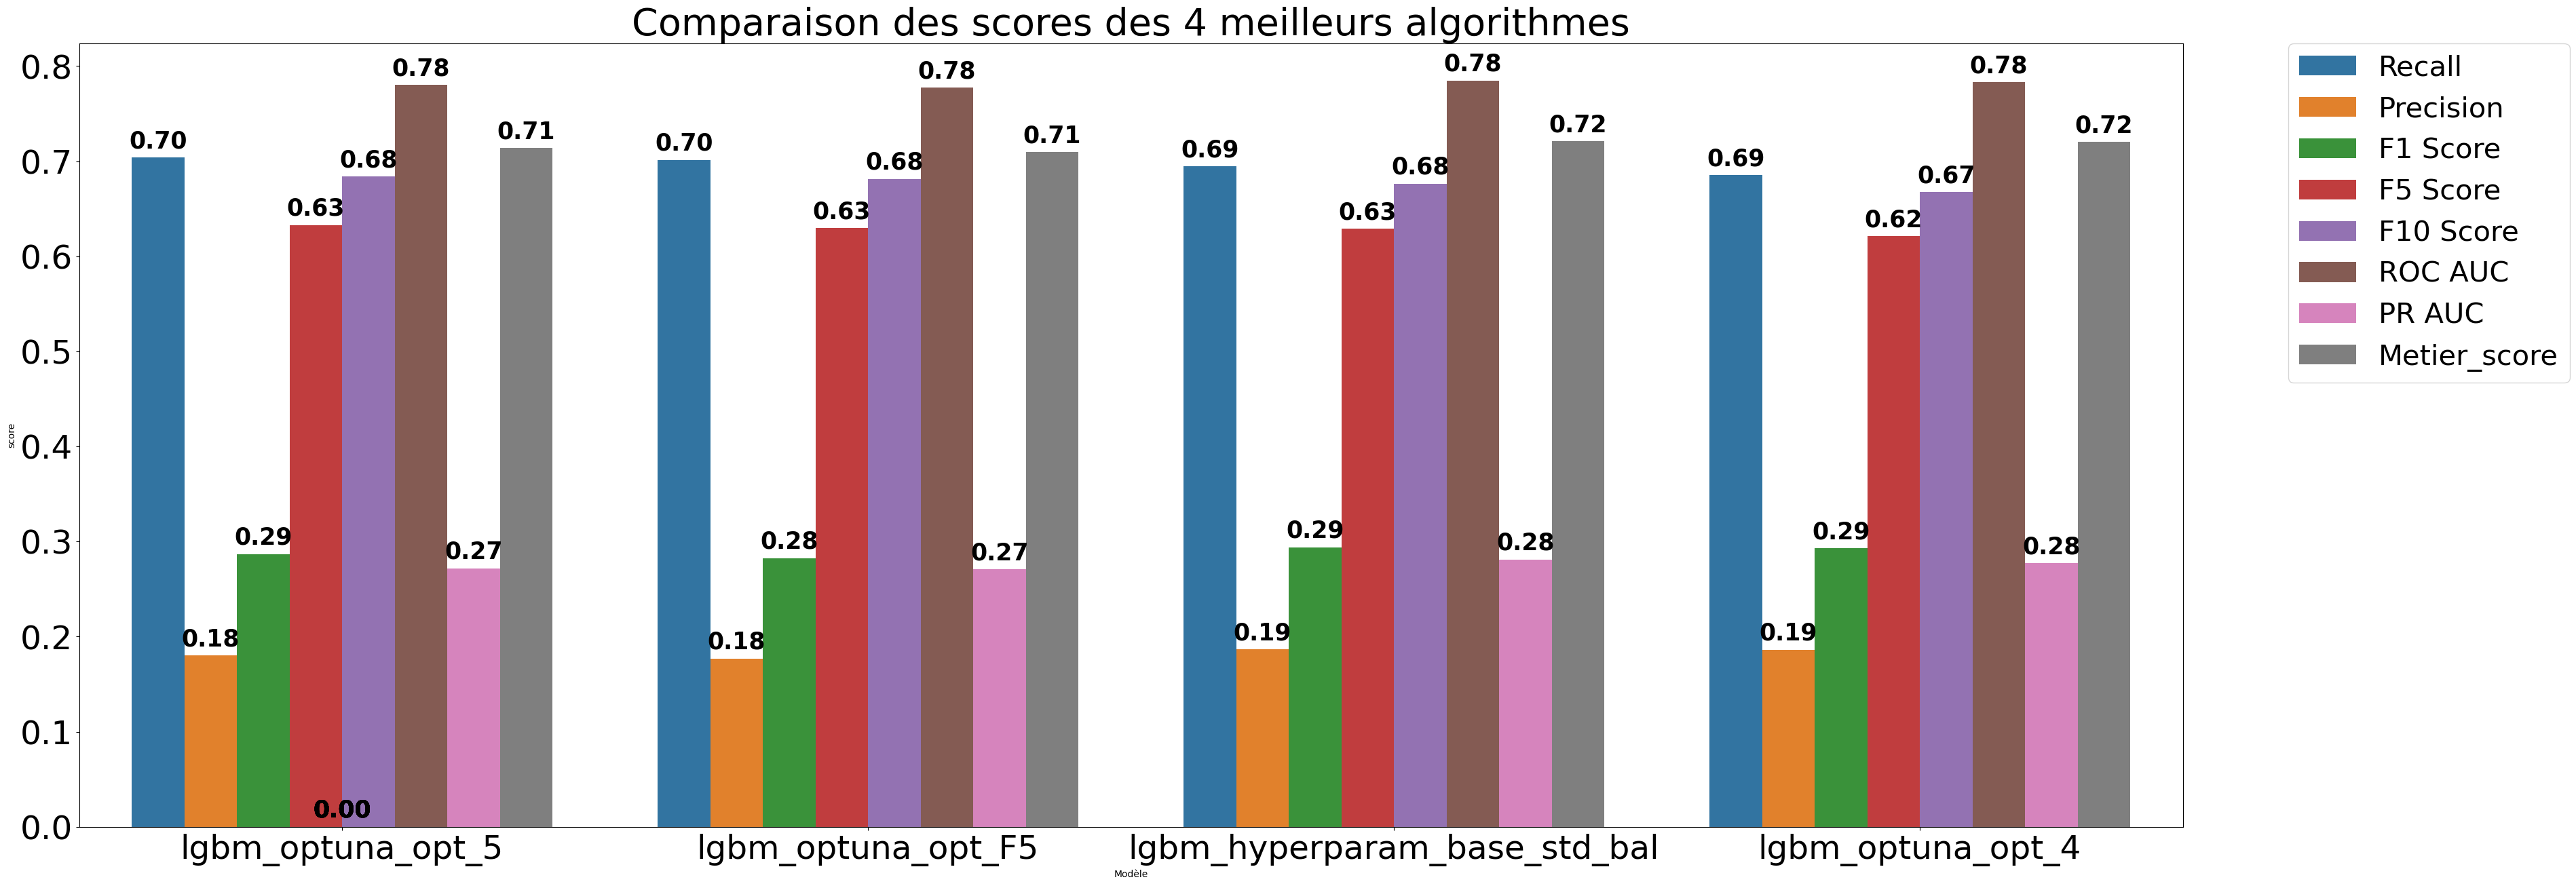

Modèle    Recall  Precision  F1 Score  F5 Score  \
10             lgbm_optuna_opt_5  0.703726   0.180085  0.286781  0.632940   
12            lgbm_optuna_opt_F5  0.701309   0.176931  0.282573  0.629547   
5   lgbm_hyperparam_base_std_bal  0.694663   0.186402  0.293932  0.628726   
9              lgbm_optuna_opt_4  0.685398   0.186221  0.292870  0.621339   

    F10 Score   ROC AUC    PR AUC  Metier_score  
10   0.684033  0.780131  0.271803      0.713774  
12   0.681317  0.777379  0.270662      0.709528  
5    0.676402  0.784745  0.281211      0.721007  
9    0.667677  0.782982  0.277108      0.720172

In [170]:
# Comparaison visuelle des 4 algorithmes les plus performants
df_comp_score = df_comp[df_comp['Modèle'].isin(
    ['lgbm_optuna_opt_5', 'lgbm_optuna_opt_F5',
     'lgbm_hyperparam_base_std_bal', 'lgbm_optuna_opt_4'])]

# Renseignements sur les modèles
df_comp_display = df_comp_score[['Modèle', 'Metrique', 'Optimisation',
                               'Class_weight']]
display(df_comp_display)

# Scores
comparaison_score_melt = \
    pd.melt(df_comp_score, id_vars=['Modèle'], value_name='score',
            value_vars=['Recall', 'Precision', 'F1 Score', 'F5 Score', 'F10 Score',
                        'ROC AUC', 'PR AUC', 'Metier_score'])
# Visualisation
plt.figure(figsize=(40, 15))
ax= sns.barplot(x=comparaison_score_melt['Modèle'],
                y=comparaison_score_melt['score'],
            hue=comparaison_score_melt['variable'])
plt.title('Comparaison des scores des 4 meilleurs algorithmes',
          fontsize=40)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=30)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center",
            fontsize=25,
            fontweight='bold') 
plt.show()

df_comp_score[['Modèle', 'Recall', 'Precision', 'F1 Score', 'F5 Score', 'F10 Score', 'ROC AUC',
               'PR AUC', 'Metier_score']]

**Bilan** :
***
- Les différentes métriques sont proches pour tous les modèles avec un léger avantage pour le rappel pour le modèle **lgbm_otuna_opt_5** qui s'explique pour le nombre beta=10 qui favorise la détection des classes positives.

### <span style='background:PowderBlue'>Recherche de seuil de probabilité optimal</span>

In [171]:
df_res_seuil = pd.DataFrame({})

**Seuil de probabilité optimal du modèle lgbm_optuna_opt_5**

In [178]:
# Sauvegarde du modèle de classification entraîné
with open(path + 'sauvegarde/modelisation/modele_' + 'lgbm_optuna_opt_5_v2' + '.pickle', 'wb') as f:
    pickle.dump(lgbm_optuna_opt_5, f, pickle.HIGHEST_PROTOCOL)

In [179]:
# Chargement du meilleur modèle
fic_lgbm_optuna_opt_5 = path + 'sauvegarde/modelisation/modele_lgbm_optuna_opt_5_v2.pickle'
with open(fic_lgbm_optuna_opt_5, 'rb') as df_mod2:
    lgbm_optuna_opt_5 = pickle.load(df_mod2)
lgbm_optuna_opt_5

LGBMClassifier(class_weight='balanced', colsample_bytree=0.942643005209126,
               force_col_wise=True, max_depth=8, min_child_samples=47,
               min_child_weight=0.5225481447282847, n_jobs=-1, num_leaves=14,
               objective='binary', reg_alpha=1.3788599856023566e-05,
               reg_lambda=1.4867533700934656e-07, subsample=0.5572465639400604,
               subsample_freq=2, verbosity=-1)

**Première métrique métier**

In [186]:
def determiner_seuil_probabilite(model, X_valid, y_valid, title, n=1):
    '''
    Déterminer le seuil de probabilité optimal pour la métrique métier.
    Parameters
    ----------
    model : modèle entraîné, obligatoire.
    y_valid : valeur réélle.
    X_valid : données à tester.
    title : titre pour graphique.
    n : gain pour la classe 1 (par défaut) ou 0.
    Returns
    -------
    None.
    '''
    seuils = np.arange(0, 1, 0.01)
    sav_gains = []

    model.fit(X_valid, y_valid)
 
    for seuil in seuils:

        # Score du modèle : n = 0 ou 1
        y_proba = model.predict_proba(X_valid)[:, n]

        # Score > seuil de solvabilité : retourne 1 sinon 0
        y_pred = (y_proba > seuil)
        y_pred = np.multiply(y_pred, 1)
        
        # Sauvegarde du score de la métrique métier
        sav_gains.append(custom_score(y_valid, y_pred))
    
    df_score = pd.DataFrame({'Seuils' : seuils,
                             'Gains' : sav_gains})
    
    # Score métrique métier maximal
    gain_max = df_score['Gains'].max()
    print(f'Score métrique métier maximal : {gain_max}')
    # Seuil optimal pour notre métrique
    seuil_max = df_score.loc[df_score['Gains'].argmax(), 'Seuils']
    print(f'Seuil maximal : {seuil_max}')

    # Affichage du gain en fonction du seuil de solvabilité
    plt.figure(figsize=(12, 6))
    plt.plot(seuils, sav_gains)
    plt.xlabel('Seuil de probabilité')
    plt.ylabel('Métrique métier')
    plt.title(title)
    plt.xticks(np.linspace(0.1, 1, 10))

Score métrique métier maximal : 0.7750657467096828
Seuil maximal : 0.63


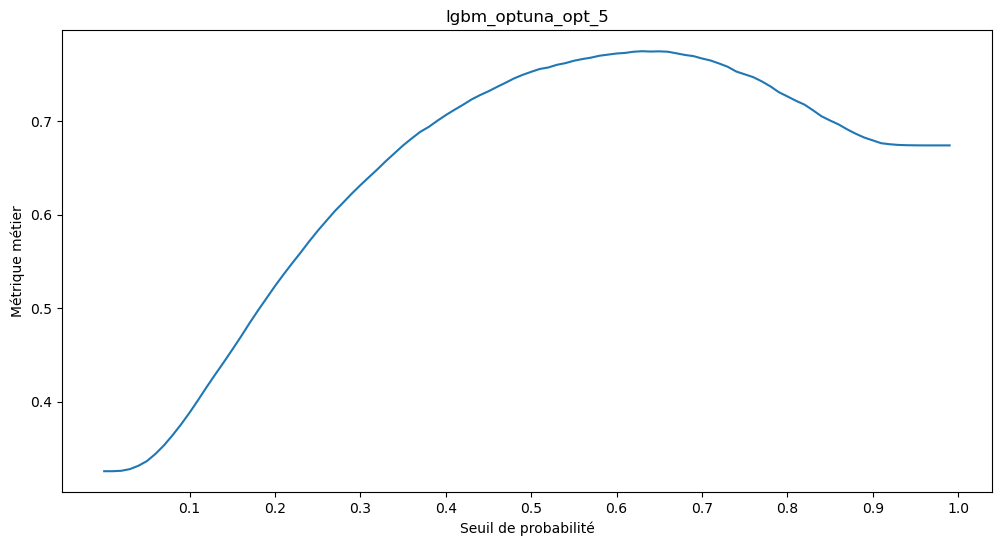

In [187]:
# taux_tn=1, taux_fp=-1, taux_fn=-10, taux_tp=1
determiner_seuil_probabilite(lgbm_optuna_opt_5,
                                          X_valid, y_valid,
                                          'lgbm_optuna_opt_5')

**Scores du modèle en prenant en compte le seuil**

In [191]:
def process_classification_seuil(model, seuil, X_train, X_valid, y_train,
                                 y_valid, df_res_seuil, titre,
                                 affiche_res=True,
                                 affiche_matrice_confusion=True):
    """
    Lance un modele de classification binaire, effectue cross-validation
    et sauvegarde des scores.
    Parameters
    ----------
    model : modèle de lassification initialisé, obligatoire.
    seuil : seuil de probabilité optimal.
    X_train : train set matrice X, obligatoire.
    X_valid : test set matrice X, obligatoire.
    y_train : train set vecteur y, obligatoire.
    y_valid : test set, vecteur y, obligatoire.
    df_res_seuil : dataframe sauvegardant les scores, obligatoire
    titre : titre à inscrire dans le tableau de sauvegarde, obligatoire.
    affiche_res : affiche le tableau de résultat (optionnel, True par défaut).
    Returns
    -------
    df_resultats : Le dataframe de sauvegarde des performances.
    y_pred : Les prédictions pour le modèle
    """
    # Top début d'exécution
    time_start = time.time()

    # Entraînement du modèle avec le jeu d'entraînement du jeu d'entrainement
    model.fit(X_train, y_train)

    # Sauvegarde du modèle de classification entraîné
    with open(path + 'sauvegarde/modelisation/modele_' + titre + '.pickle', 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)
    
    # Top fin d'exécution
    time_end_train = time.time()
    
    # Score du modèle : n = 0 ou 1
    # Probabilités
    y_proba = model.predict_proba(X_valid)[:, 1]

    # Prédictions avec le jeu de validation du jeu d'entraînement
    # Score > seuil de probabilité : retourne 1 sinon 0
    y_pred = (y_proba > seuil)
    y_pred = np.multiply(y_pred, 1)

    # Top fin d'exécution
    time_end = time.time()

    # Calcul des métriques
    # Rappel/recall sensibilité
    recall = recall_score(y_valid, y_pred)
    # Précision
    precision = precision_score(y_valid, y_pred)
    # F-mesure ou Fbeta
    f1_score = fbeta_score(y_valid, y_pred, beta=1)
    f5_score = fbeta_score(y_valid, y_pred, beta=5)
    f10_score = fbeta_score(y_valid, y_pred, beta=10)
    # Score ROC AUC aire sous la courbe ROC
    roc_auc = roc_auc_score(y_valid, y_proba)
    # Score PR AUC aire sous la courbe précion/rappel
    pr_auc = average_precision_score(y_valid, y_proba)
    # Métrique métier
    banque_score = custom_score(y_valid, y_pred)

    # durée d'exécution d'entraînement
    time_exec_train = time_end_train - time_start
    # durée d'exécution entraînement + validation
    time_execution = time_end - time_start

    # cross validation
    scoring = ['roc_auc', 'recall', 'precision']
    scores = cross_validate(model, X_train, y_train, cv=10,
                            scoring=scoring, return_train_score=True)

    # Préparation des nouvelles données
    new_data = pd.DataFrame({
        'Modèle': [titre],
        'Recall': [recall],
        'Précision': [precision],
        'F1': [f1_score],
        'F5': [f5_score],
        'F10': [f10_score],
        'ROC_AUC': [roc_auc],
        'PR_AUC': [pr_auc],
        'Metier_score': [banque_score],
        'Durée_train': [time_exec_train],
        'Durée_tot': [time_execution],
        'Train_roc_auc_CV': [scores['train_roc_auc'].mean()],
        'Train_roc_auc_CV +/-': [scores['train_roc_auc'].std()],
        'Test_roc_auc_CV': [scores['test_roc_auc'].mean()],
        'Test_roc_auc_CV +/-': [scores['test_roc_auc'].std()],
        'Train_recall_CV': [scores['train_recall'].mean()],
        'Train_recall_CV +/-': [scores['train_recall'].std()],
        'Test_recall_CV': [scores['test_recall'].mean()],
        'Test_recall_CV +/-': [scores['test_recall'].std()],
        'Train_precision_CV': [scores['train_precision'].mean()],
        'Train_precision_CV +/-': [scores['train_precision'].std()],
        'Test_precision_CV': [scores['test_precision'].mean()],
        'Test_precision_CV +/-': [scores['test_precision'].std()],
    })

    # Utilisation de concat pour ajouter les nouvelles données
    df_res_seuil = pd.concat([df_res_seuil, new_data], ignore_index=True)

    # Sauvegarde du tableau de résultat et autres étapes...
    with open(path + 'sauvegarde/modelisation/df_res_seuil.pickle', 'wb') as df:
        pickle.dump(df_res_seuil, df, pickle.HIGHEST_PROTOCOL)

    if affiche_res:
        mask = df_res_seuil['Modèle'] == titre
        display(df_res_seuil[mask])

    if affiche_matrice_confusion:
        afficher_matrice_confusion(y_valid, y_pred, titre)

    return df_res_seuil

Modèle    Recall  Précision        F1        F5       F10  \
0  lgbm_optuna_opt_5_seuil  0.516213    0.23557  0.323509  0.493597  0.510196   

    ROC_AUC    PR_AUC  Metier_score  Durée_train  ...  Test_roc_auc_CV  \
0  0.780131  0.271803      0.743239     7.160922  ...          0.78252   

   Test_roc_auc_CV +/-  Train_recall_CV  Train_recall_CV +/-  Test_recall_CV  \
0             0.004401         0.736595             0.002177        0.706294   

   Test_recall_CV +/-  Train_precision_CV  Train_precision_CV +/-  \
0            0.010543            0.186979                0.000638   

   Test_precision_CV  Test_precision_CV +/-  
0            0.17959               0.002657  

[1 rows x 23 columns]

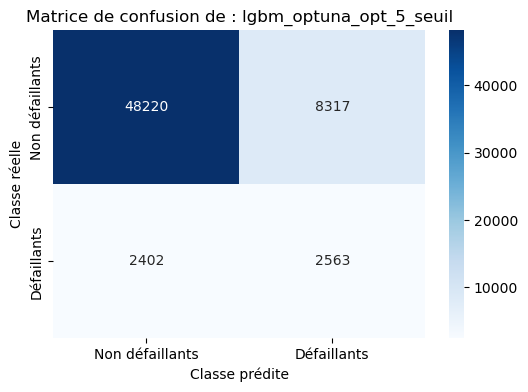

In [192]:
df_res_seuil = process_classification_seuil(lgbm_optuna_opt_5, 0.63,
                                             X_train, X_valid, y_train,
                                             y_valid, df_res_seuil,
                                            'lgbm_optuna_opt_5_seuil')

**Bilan** :
- La métrique métier n'est pas efficace puisqu'on détecte plus de vrais négatifs (prédits non-défaillants mais défaillants).

**Deuxième métrique métier**

In [193]:
def determiner_seuil_probabilite_F10(model, X_valid, y_valid, title, n=1):
    '''
    Déterminer le seuil de probabilité optimal pour la métrique métier.
    Parameters
    ----------
    model : modèle entraîné, obligatoire.
    y_valid : valeur réélle.
    X_valid : données à tester.
    title : titre pour graphique.
    n : gain pour la classe 1 (par défaut) ou 0.
    Returns
    -------
    None.
    '''
    seuils = np.arange(0, 1, 0.01)
    scores_F10 = []
 
    for seuil in seuils:

        # Score du modèle : n = 0 ou 1
        y_proba = model.predict_proba(X_valid)[:, n]

        # Score > seuil de solvabilité : retourne 1 sinon 0
        y_pred = (y_proba > seuil)
        y_pred = np.multiply(y_pred, 1)
        
        # Sauvegarde du score de la métrique métier
        scores_F10.append(fbeta_score(y_valid, y_pred, beta=10))
    
    df_score = pd.DataFrame({'Seuils' : seuils,
                             'Gains' : scores_F10})
    
    # Score métrique métier maximal
    gain_max = df_score['Gains'].max()
    print(f'Score F10 maximal : {gain_max}')
    # Seuil optimal pour notre métrique
    seuil_max = df_score.loc[df_score['Gains'].argmax(), 'Seuils']
    print(f'Seuil maximal : {seuil_max}')

    # Affichage du gain en fonction du seuil de solvabilité
    plt.figure(figsize=(12, 6))
    plt.plot(seuils, scores_F10)
    plt.xlabel('Seuil de probabilité')
    plt.ylabel('Score F10')
    plt.title(title)
    plt.xticks(np.linspace(0.1, 1, 10))

Score F10 maximal : 0.9002635012777461
Seuil maximal : 0.12


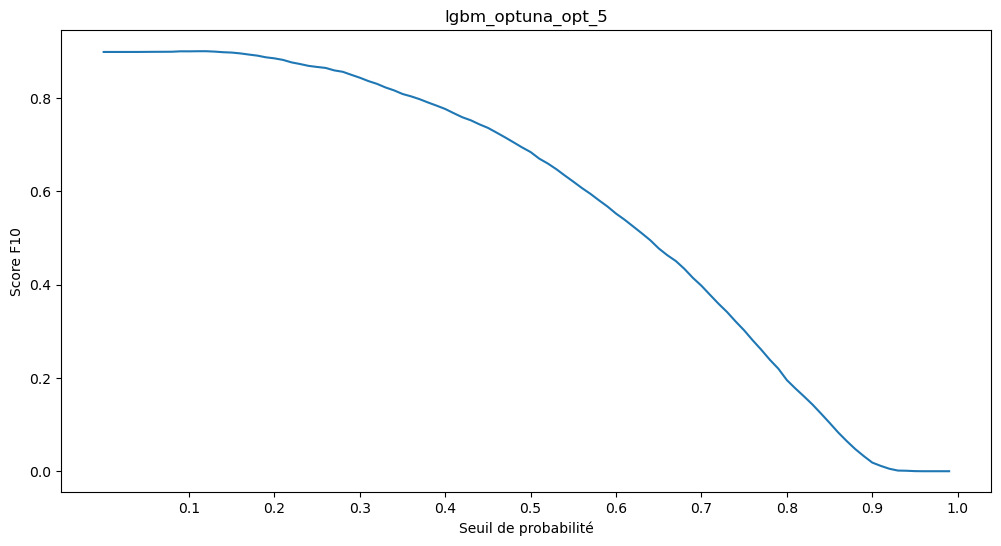

In [194]:
# Score F10 en fonction du seuil
determiner_seuil_probabilite_F10(lgbm_optuna_opt_5,
                                              X_valid, y_valid,
                                             'lgbm_optuna_opt_5')

**Scores du modèle en prenant en compte le seuil**

Modèle    Recall  Précision        F1        F5  \
1  lgbm_optuna_opt_5_seuil_1  0.993353   0.086803  0.159656  0.708687   

        F10   ROC_AUC    PR_AUC  Metier_score  Durée_train  ...  \
1  0.900264  0.780131  0.271803      0.378999     8.231265  ...   

   Test_roc_auc_CV  Test_roc_auc_CV +/-  Train_recall_CV  Train_recall_CV +/-  \
1          0.78252             0.004401         0.736595             0.002177   

   Test_recall_CV  Test_recall_CV +/-  Train_precision_CV  \
1        0.706294            0.010543            0.186979   

   Train_precision_CV +/-  Test_precision_CV  Test_precision_CV +/-  
1                0.000638            0.17959               0.002657  

[1 rows x 23 columns]

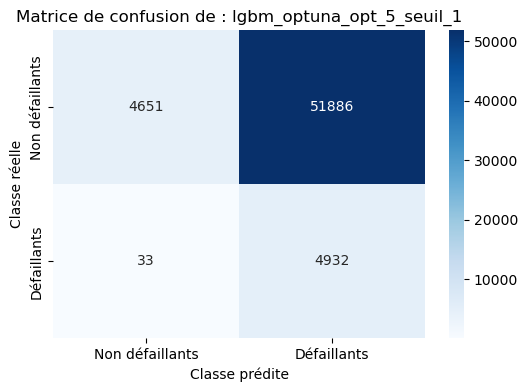

In [195]:
df_res_seuil = process_classification_seuil(lgbm_optuna_opt_5, 0.12,
                                              X_train, X_valid, y_train,
                                              y_valid, df_res_seuil,
                                             'lgbm_optuna_opt_5_seuil_1')

- Le taux de FN est très faible mais cela signifie que le prêt n'est plus accordé à personne ! Ce n'est pas le but de la banque qui doit gagner de l'argent avec les intérêts des prêts accordés.
- Le compromis faux négatifs et faux positifs devra être discuté avec nos clients pour régler au mieux le seuil de probabilité avec le nombre de faux négatifs/positifs à atteindre. 
- Sans client disponible et sans consigne dans le projet, le seuil par défaut à 0.5 sera conservé et le modèle final sera **lgbm_optuna_opt_5**.

In [197]:
# Sauvegarde du meilleur modèle dans best_model
fic_best_model = path + 'sauvegarde/modelisation/best_model.pickle'
with open(fic_best_model, 'wb') as f:
    pickle.dump(lgbm_optuna_opt_5, f, pickle.HIGHEST_PROTOCOL)

## <span style='background:Thistle'>Interprétabilité du modèle</span>

In [198]:
# Chargement du meilleur modèle
fic_best_model = path + 'sauvegarde/modelisation/best_model.pickle'
with open(fic_best_model, 'rb') as df_best_model:
    best_model = pickle.load(df_best_model)
best_model

LGBMClassifier(class_weight='balanced', colsample_bytree=0.942643005209126,
               force_col_wise=True, max_depth=8, min_child_samples=47,
               min_child_weight=0.5225481447282847, n_jobs=-1, num_leaves=14,
               objective='binary', reg_alpha=1.3788599856023566e-05,
               reg_lambda=1.4867533700934656e-07, subsample=0.5572465639400604,
               subsample_freq=2, verbosity=-1)

### <span style='background:PowderBlue'>LightGBM - Features importances</span>

**Features importances**

In [196]:
def plot_features_importance(features_importance, nom_variables, figsize=(10, 12)):
    '''
    Affiche la liste des variables avec leurs importances par ordre décroissant.
    Parameters
    ----------
    features_importance: les features importances, obligatoire
    nom_variables : nom des variables, obligatoire
    figsize : taille du graphique, plus grande pour une meilleure lisibilité
    Returns
    -------
    None.
    '''
    df_feat_imp = pd.DataFrame({'feature': nom_variables,
                                'importance': features_importance})
    df_feat_imp_tri = df_feat_imp.sort_values(by='importance', ascending=True)
    
    # BarGraph de visualisation
    plt.figure(figsize=figsize)
    plt.barh(df_feat_imp_tri['feature'], df_feat_imp_tri['importance'], color='skyblue')
    plt.yticks(fontsize=8)  # Taille de police réduite
    plt.xlabel('Feature Importances', fontsize=14)
    plt.ylabel('Variables', fontsize=14)
    plt.title('Comparaison des Features Importances', fontsize=18)
    plt.tight_layout()  # Ajustement de l'espace pour que tout s'affiche correctement
    plt.show()


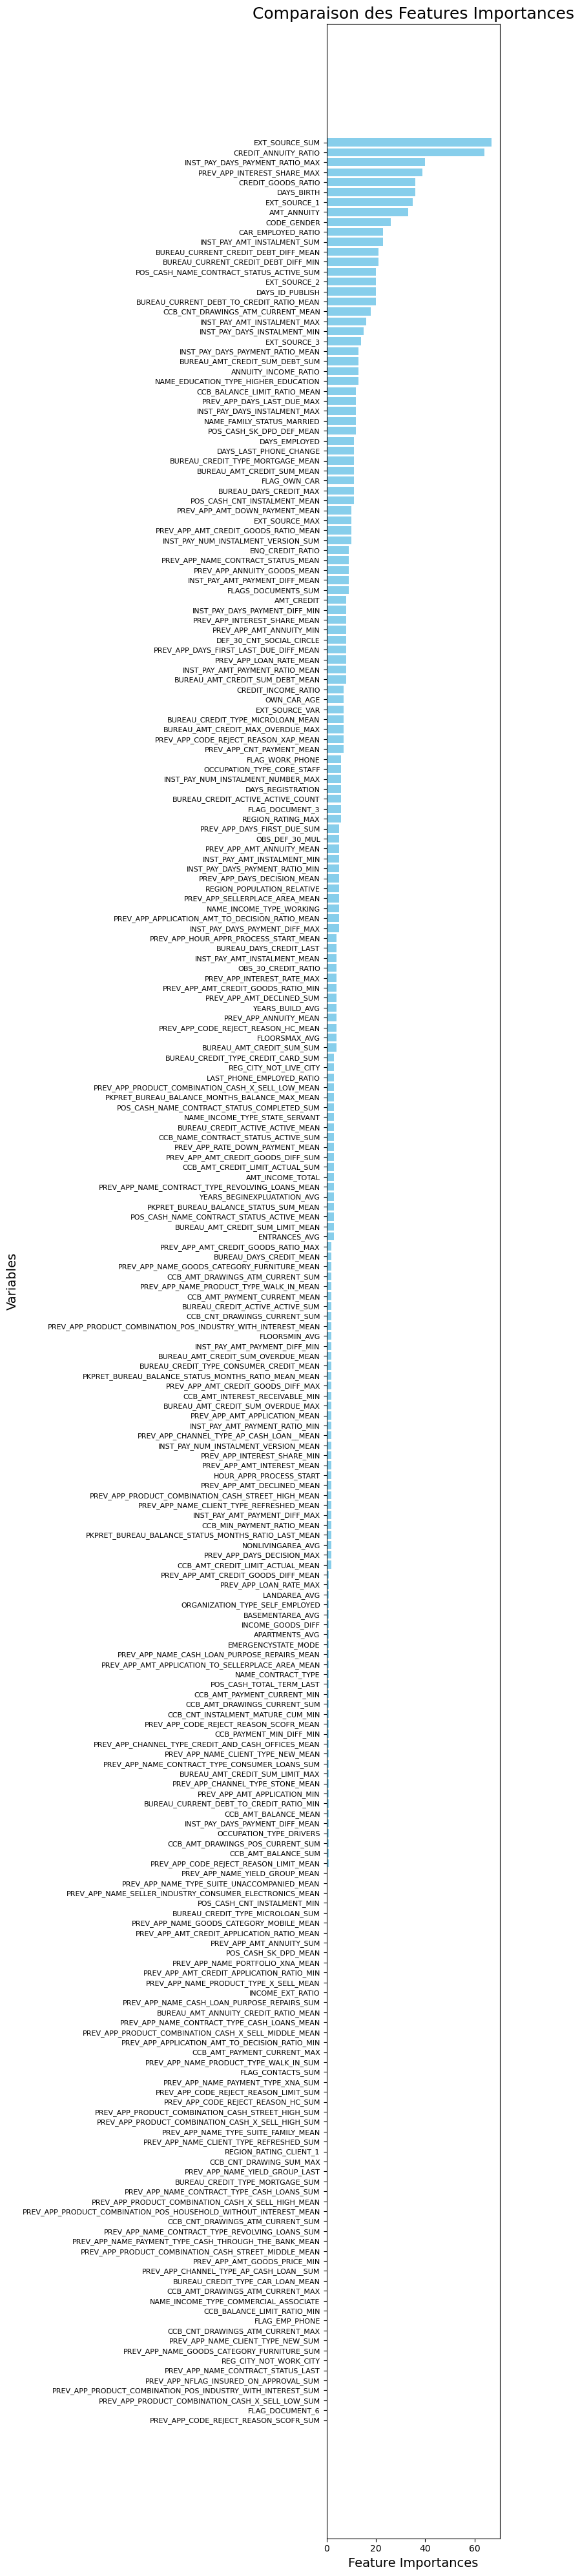

In [199]:
feature_importance_values = best_model.feature_importances_
feature_names = list(X_train.columns)
plot_features_importance(feature_importance_values,
                                      feature_names, (8, 40))

**Répartition des features importances**

In [205]:
def plot_cumulative_feature_importance(df, threshold = 0.7):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d variables nécessaires pour %0.2f de cummulative imortance' % (importance_index + 1, threshold))
    
    return df

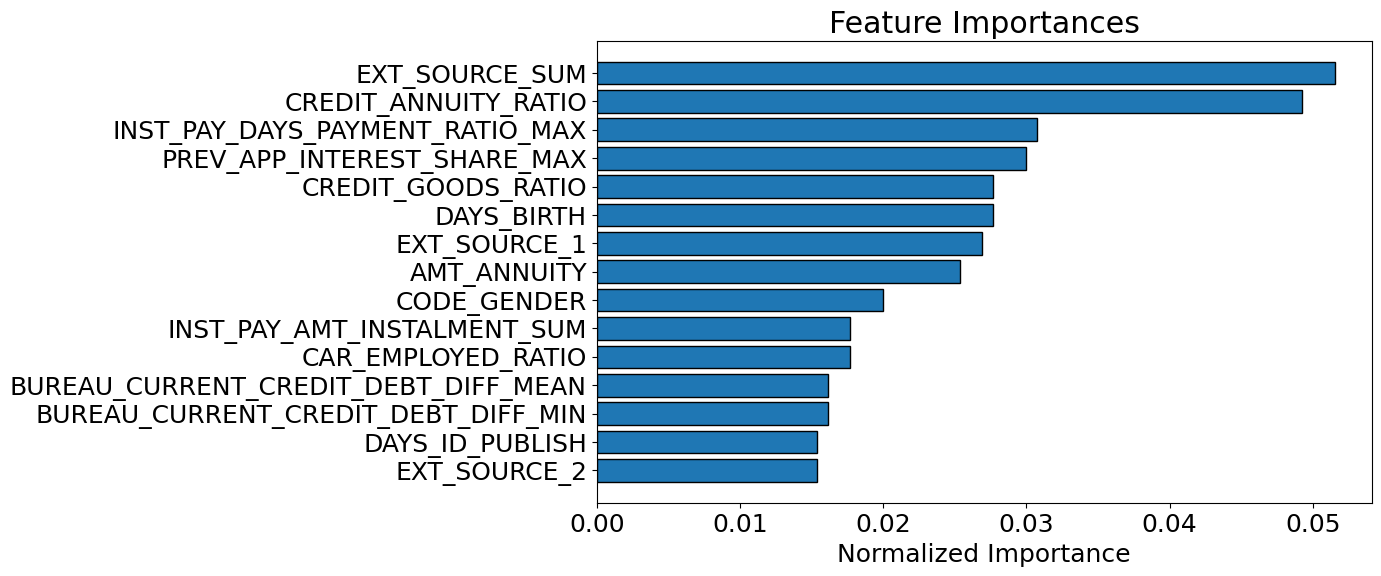

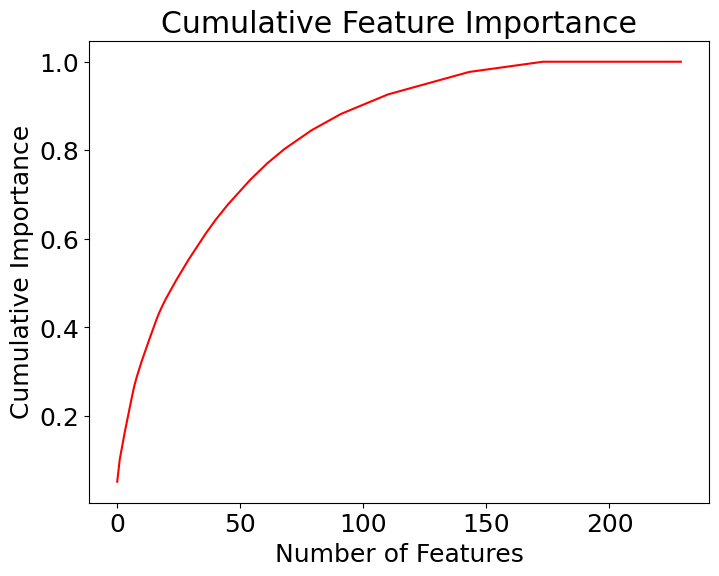

50 variables nécessaires pour 0.70 de cummulative imortance


In [206]:
# Impact des features importance cumulées
feature_importance_values = best_model.feature_importances_
feature_names = list(X_train.columns)
feature_importances = pd.DataFrame({'feature': feature_names,
                                    'importance': feature_importance_values})
# Show the feature importances for the new features
df_featimp = plot_cumulative_feature_importance(feature_importances)

In [204]:
df_featimp

index                                     feature  importance  \
0       55                              EXT_SOURCE_SUM          67   
1       57                        CREDIT_ANNUITY_RATIO          64   
2       73             INST_PAY_DAYS_PAYMENT_RATIO_MAX          40   
3        9                 PREV_APP_INTEREST_SHARE_MAX          39   
4        1                          CREDIT_GOODS_RATIO          36   
..     ...                                         ...         ...   
225    143  PREV_APP_NAME_GOODS_CATEGORY_FURNITURE_SUM           0   
226    140                      REG_CITY_NOT_WORK_CITY           0   
227    139          PREV_APP_NAME_CONTRACT_STATUS_LAST           0   
228    137      PREV_APP_NFLAG_INSURED_ON_APPROVAL_SUM           0   
229    229       PREV_APP_CODE_REJECT_REASON_SCOFR_SUM           0   

     importance_normalized  cumulative_importance  
0                 0.051538               0.051538  
1                 0.049231               0.100769  
2                 0.030769               0.131538  
3                 0.030000               0.161538  
4                 0.027692               0.189231  
..                     ...                    ...  
225               0.000000               1.000000  
226               0.000000               1.000000  
227               0.000000               1.000000  
228               0.000000               1.000000  
229               0.000000               1.000000  

[230 rows x 5 columns]

- 100 variables sont nécessaires pour représenter 90% des features importances et 50 variables pour 70%.

**Arbre de décision de LightGBM**

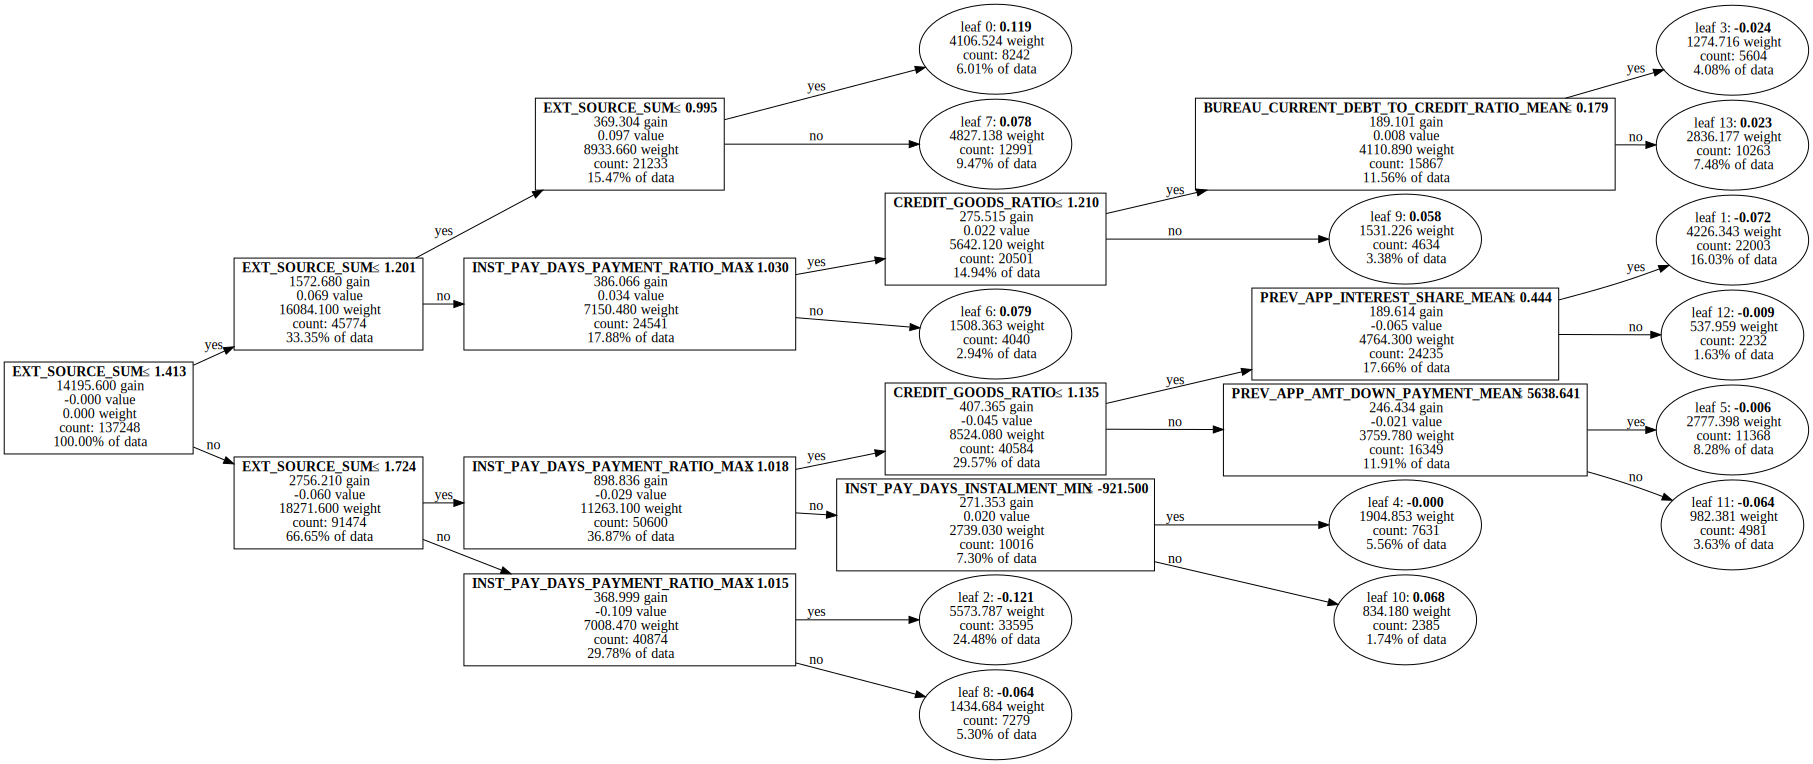

In [207]:
import lightgbm as lgb

lgb.create_tree_digraph(best_model, tree_index=0,
                        show_info=['split_gain', 'internal_value',
                                   'internal_count', 'internal_weight',
                                   'leaf_count', 'leaf_weight', 'data_percentage'])

### <span style='background:PowderBlue'>SHAP</span>

**Interprétabilité globale**

**Summary plot**

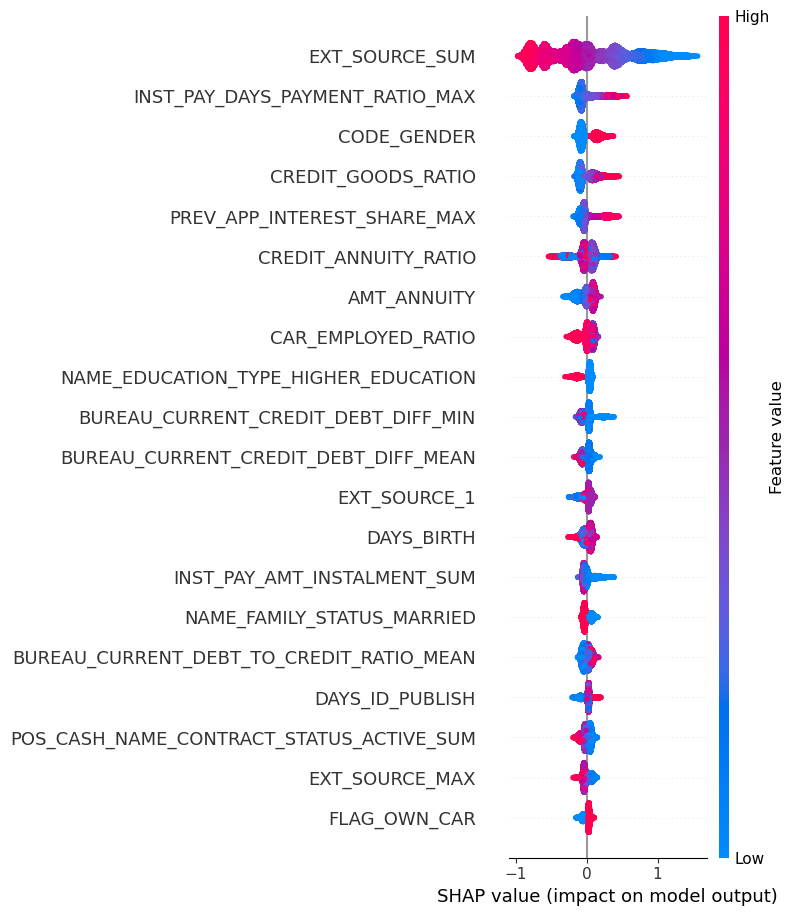

In [208]:
# Interprétation
import shap

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_valid)
# Summary plot
shap.summary_plot(shap_values, X_valid)

**Bar plot** : l'importance globale des caractéristiques, où l'importance globale de chaque caractéristique est considérée comme la valeur absolue moyenne pour cette caractéristique sur tous les échantillons donnés.

In [209]:
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_train, check_additivity=False)

100%|===================| 245811/246005 [09:58<00:00]        

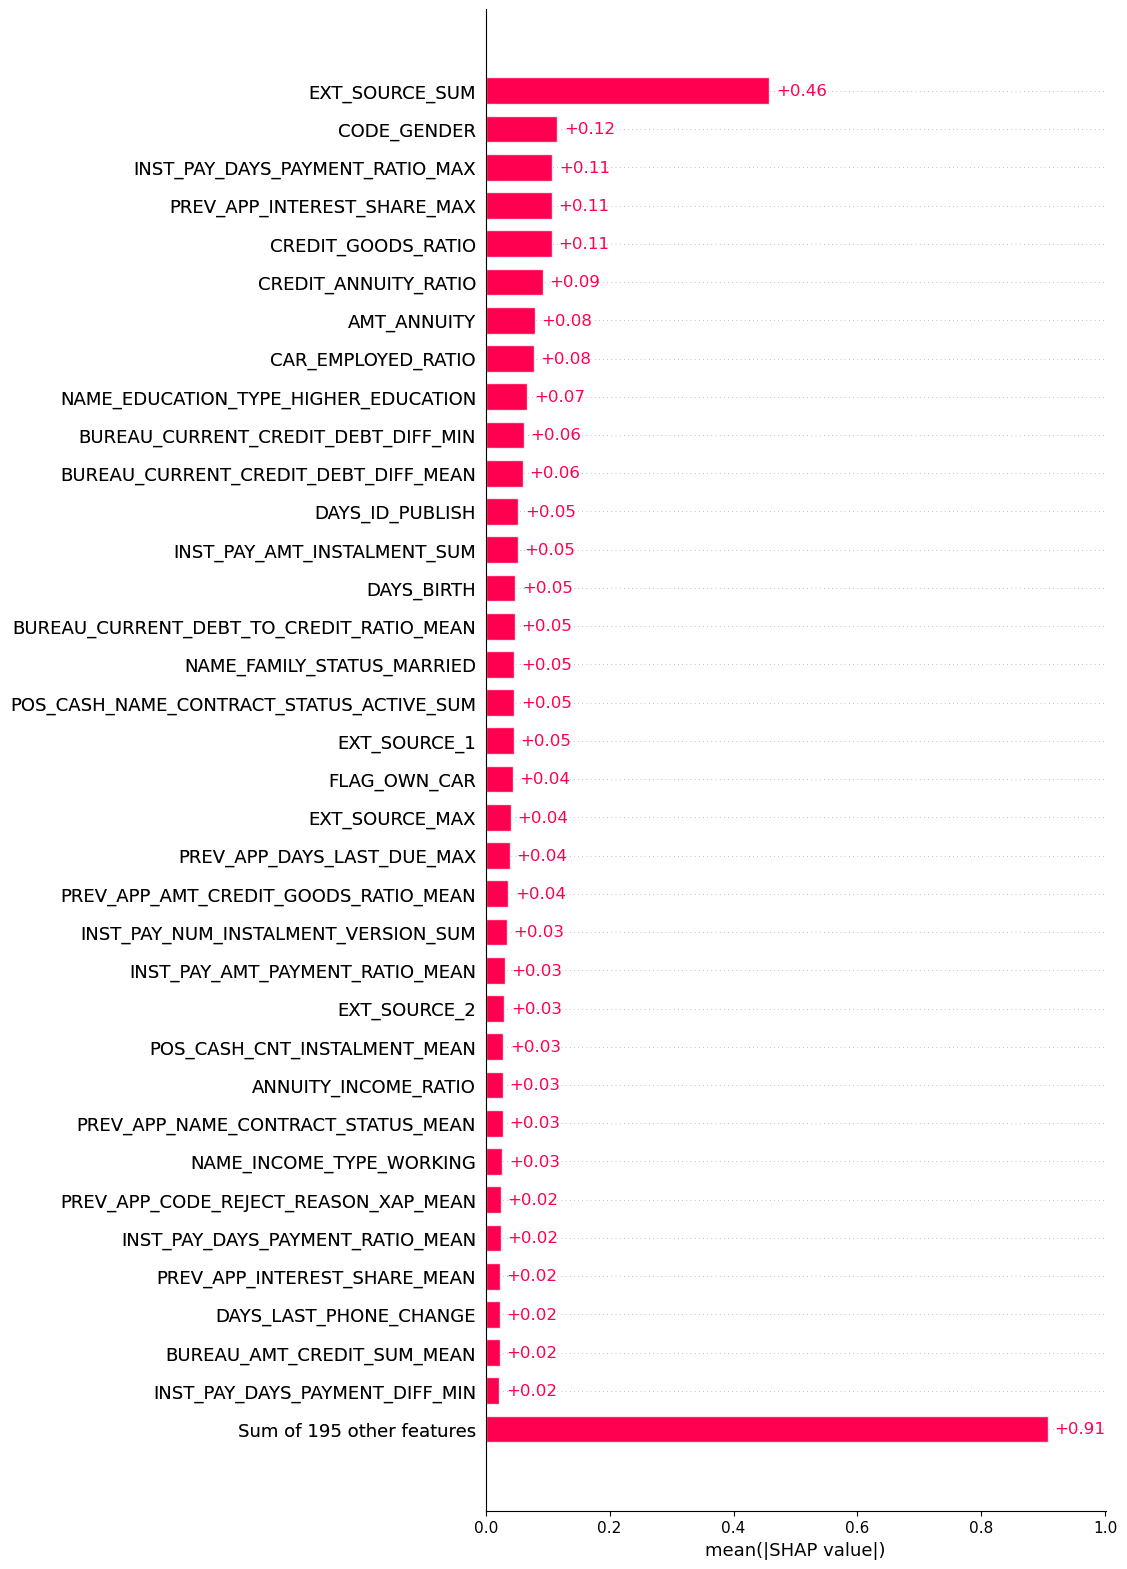

In [210]:
shap.plots.bar(shap_values, max_display=36)

**Beeswarm** : 
- ce graphique est conçu pour afficher un résumé dense en informations de la manière dont les principales caractéristiques d'un ensemble de données influencent la sortie du modèle. 
- Chaque instance de l'explication donnée est représentée par un seul point sur chaque graphique de caractéristiques. La position x du point est déterminée par la valeur SHAP (shap_values.value[instance,feature]) de cette caractéristique, et les points s'empilent le long de chaque ligne de caractéristique pour montrer la densité. 
- La couleur est utilisée pour afficher la valeur originale d'une caractéristique (shap_values.data[instance,feature]). 

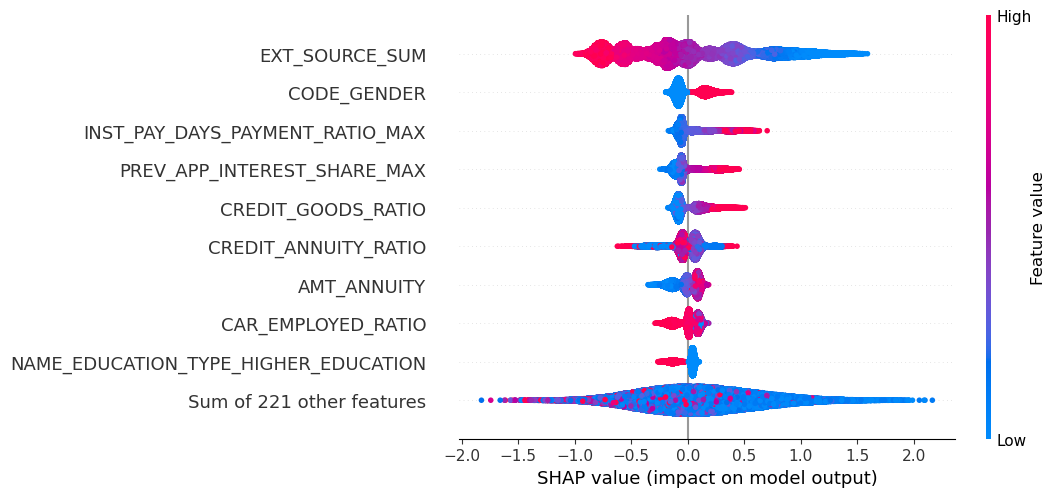

In [211]:
shap.plots.beeswarm(shap_values)

- Dans le graphique ci-dessous, nous pouvons voir que la variable EXT_SOURCE_SUM est la caractéristique la plus importante en moyenne, et que les hautes valeurs (en rouge) ont tendance avoir un impact négatif donc classe 1 défaillant alors que les basses valeurs ont tendance à avoir un impact positif donc classe 0 non-défaillant...

***
Le meilleur modèle est sélectionné et extrait. La suite concernera la préparation des données nécessaires au dashboard
***